# Project 1

------------------------------------------------------
Olga Bonachera del Pozo - 100472782

Daniel Kwapien - 100472421

Alejandro Sánchez - 100472892

------------------------------------------------------



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from torchvision import datasets, transforms
import copy
import random

## 1. Initial network architecture

In [ ]:
class Autoencoder_basic(nn.Module):

  def __init__(self, dimx, hidden, projected, layers):

    super().__init__()
    # Encoder layers (compression)
    encoder_layers = []
    encoder_layers.append(nn.Linear(dimx, hidden[0])) # Input layer to first hidden layer
    encoder_layers.append(nn.ReLU()) # Activation function for non-linearity
    for i in range(1, layers-1):
      encoder_layers.append(nn.Linear(hidden[i-1], hidden[i]))  # Hidden layers
      encoder_layers.append(nn.ReLU())  # Activation
    encoder_layers.append(nn.Linear(hidden[-1], projected))  # Last hidden layer
    encoder_layers.append(nn.ReLU())   # Activation
    self.encoder = nn.Sequential(*encoder_layers)  # Sequencial construction of the encoder

    # Decoder layers (reconstruction)
    decoder_layers = []
    i = 0
    decoder_layers.append(nn.Linear(projected, hidden[-(i+1)])) # Latent space to first hidden layer (reversed order)
    decoder_layers.append(nn.ReLU()) # Activation
    for i in range(1, layers-1):
      decoder_layers.append(nn.Linear(hidden[-i], hidden[-(i+1)]))  # Hidden layers (reversed order)
      decoder_layers.append(nn.ReLU())   # Activation
    decoder_layers.append(nn.Linear(hidden[-(layers-1)], dimx))  # Last hidden layer to output layer
    decoder_layers.append(nn.Tanh())  # Activation for output in range (-1, 1)
    self.decoder = nn.Sequential(*decoder_layers) # Sequential construction of the decoder

  def forward(self, x):
    # Encode the input
    encoded = self.encoder(x)
    # Decode the encoded representation
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
class Autoencoder_extended(Autoencoder_basic):

  def __init__(self, dimx, hidden, projected, layers, epochs=30, lr=0.01):
       """
        Inherits from the base Autoencoder_basic class and adds training and evaluation functionality.

        Args:
            dimx: Dimensionality of the input data.
            hidden: List specifying the number of units in each hidden layer.
            projected: Dimensionality of the latent space (bottleneck representation).
            layers: Number of layers in both the encoder and decoder (excluding input and output layers).
            epochs: Number of training epochs (default: 30).
            lr: Learning rate for the optimizer (default: 0.01).
        """

    super().__init__(dimx, hidden, projected, layers)
    # Training parameters
    self.lr = lr
    self.epochs = epochs
    # Optimizer and loss function
    self.optim = optim.Adam(self.parameters(), self.lr)
    self.criterion = nn.MSELoss()
    # Track training and validation losses during training
    self.loss_during_training = []
    self.valid_loss_during_training = []

  def trainloop(self, trainloader, validloader):
      """
      Trains the autoencoder model for a specified number of epochs.

      Args:
          trainloader: PyTorch DataLoader object for training data.
          validloader: PyTorch DataLoader object for validation data.
     """

    for e in range(self.epochs):
      running_loss = 0.
      for (inputs, _ ) in trainloader:
        # Reshape inputs to flatten dimensions for the model
        inputs = inputs.reshape(inputs.shape[0],-1)
        # Get model reconstructions
        out = self.forward(inputs)
        # Calculate loss (reconstruction error)
        loss = self.criterion(out, inputs)
        # Track average training loss per epoch
        running_loss += loss.item()

        # Update model weights
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
      # Track average training loss per epoch
      self.loss_during_training.append(running_loss/len(trainloader))

      # Validation loop (evaluate model on validation data)
      with torch.no_grad():  # Disable gradients for validation
        running_loss = 0.
        for (inputs, _) in validloader:
          inputs = inputs.reshape(inputs.shape[0],-1)
          out = self.forward(inputs)
          loss = self.criterion(out, inputs)
          running_loss += loss.item()
        # Calculate average validation loss for the epoch
        self.valid_loss_during_training.append(running_loss/len(validloader))

      if(e % 1 == 0):
        print(f'Epoch {e}. Training loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}')

  def testloop(self, dataloader):
     """
    Evaluates the model's reconstruction performance on a given dataset.

    Args:
        dataloader: PyTorch DataLoader object for the test dataset.

    Returns:
        float: Average reconstruction loss on the test dataset.
    """
    total_loss = 0
    with torch.no_grad():
      for (inputs, _) in dataloader:
        inputs = inputs.reshape(inputs.shape[0], -1)
        out = self.forward(inputs)
        loss = self.criterion(out, inputs)
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    print(f'Average reconstrucion loss: {avg_loss}')
    return avg_loss

  def plot_reconstructions(self, dataloader, num_images=10):

    """
    Visualizes the model's reconstruction performance by plotting original
    and reconstructed images from a given dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object for the dataset.
        num_images (int, optional): Number of image pairs (original and reconstructed)
            to display in the plot (default: 10).
    """

    inputs_list = []
    out_list = []

    # Variable to track the number of collected samples
    num_samples_collected = 0
    # Disable gradient calculation for efficiency (not needed for visualization)
    with torch.no_grad():
      # Iterate over batches in the dataloader
        for inputs, _ in dataloader:
            # Get model reconstructions for the current batch
            out = self.forward(inputs.view(inputs.shape[0], -1))
            # Reshape inputs to a flattened format suitable for the model
            inputs_list.append(inputs.cpu().numpy())
            out_list.append(out.cpu().numpy())
            # Update the collected sample count
            num_samples_collected += len(inputs)
            # Stop collecting samples if the desired number is reached
            if num_samples_collected >= num_images:
                break
    # Concatenate collected original and reconstructed images (up to num_images)
    inputs = np.concatenate(inputs_list)[:num_images]
    out = np.concatenate(out_list)[:num_images]
    # Create a Matplotlib figure for plotting
    plt.figure(figsize=(1.5*num_images, 4))
    # Set the colormap to grayscale for better visualization
    plt.gray()

    for k in range(num_images):
        # Create subplots for original and reconstructed images
        plt.subplot(2, num_images, k + 1)  # Top row for originals, bottom for reconstructions
        plt.imshow(inputs[k].reshape(28, 28))  # Reshape to original image size (assuming 28x28)
        plt.title('Original')
        plt.axis('off') # Hide axes for cleaner presentation

        plt.subplot(2, num_images, num_images + k + 1)
        plt.imshow(out[k].reshape(28, 28))
        plt.title('Reconstructed')
        plt.axis('off')
    # Adjust layout to prevent overlapping elements
    plt.tight_layout()
    plt.show()


## 2. Validate networks and study of the influence of the projected dimension (15,30,50,100)

### 2.1. MNIST dataset

#### 2.1.1. Import and load data

In [ ]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=600, height=400)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

100%|██████████| 9912422/9912422 [00:00<00:00, 304311979.36it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 61365599.71it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 107362943.94it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10636811.15it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


#### 2.1.2. Establish hyperparameters and perform cross validation

------------- AUTOENCODER: 3 layers and 15 projected dimensions ---------
Epoch 0. Training loss: 0.18814585568510334. Validation loss: 0.12473711663104119
Epoch 1. Training loss: 0.10834531287070025. Validation loss: 0.10021904066522071
Epoch 2. Training loss: 0.09376307277389886. Validation loss: 0.09099625650238484
Epoch 3. Training loss: 0.0863105358704078. Validation loss: 0.08626130939798152
Epoch 4. Training loss: 0.08118868424472483. Validation loss: 0.08049316447465978
Epoch 5. Training loss: 0.07768025327029383. Validation loss: 0.07898942783791968
Epoch 6. Training loss: 0.0749712404742075. Validation loss: 0.07590349259528707
Epoch 7. Training loss: 0.07270487448179418. Validation loss: 0.07350768640320351
Epoch 8. Training loss: 0.07036618717988445. Validation loss: 0.07056742316864907
Epoch 9. Training loss: 0.06812354597919197. Validation loss: 0.06987701052046837


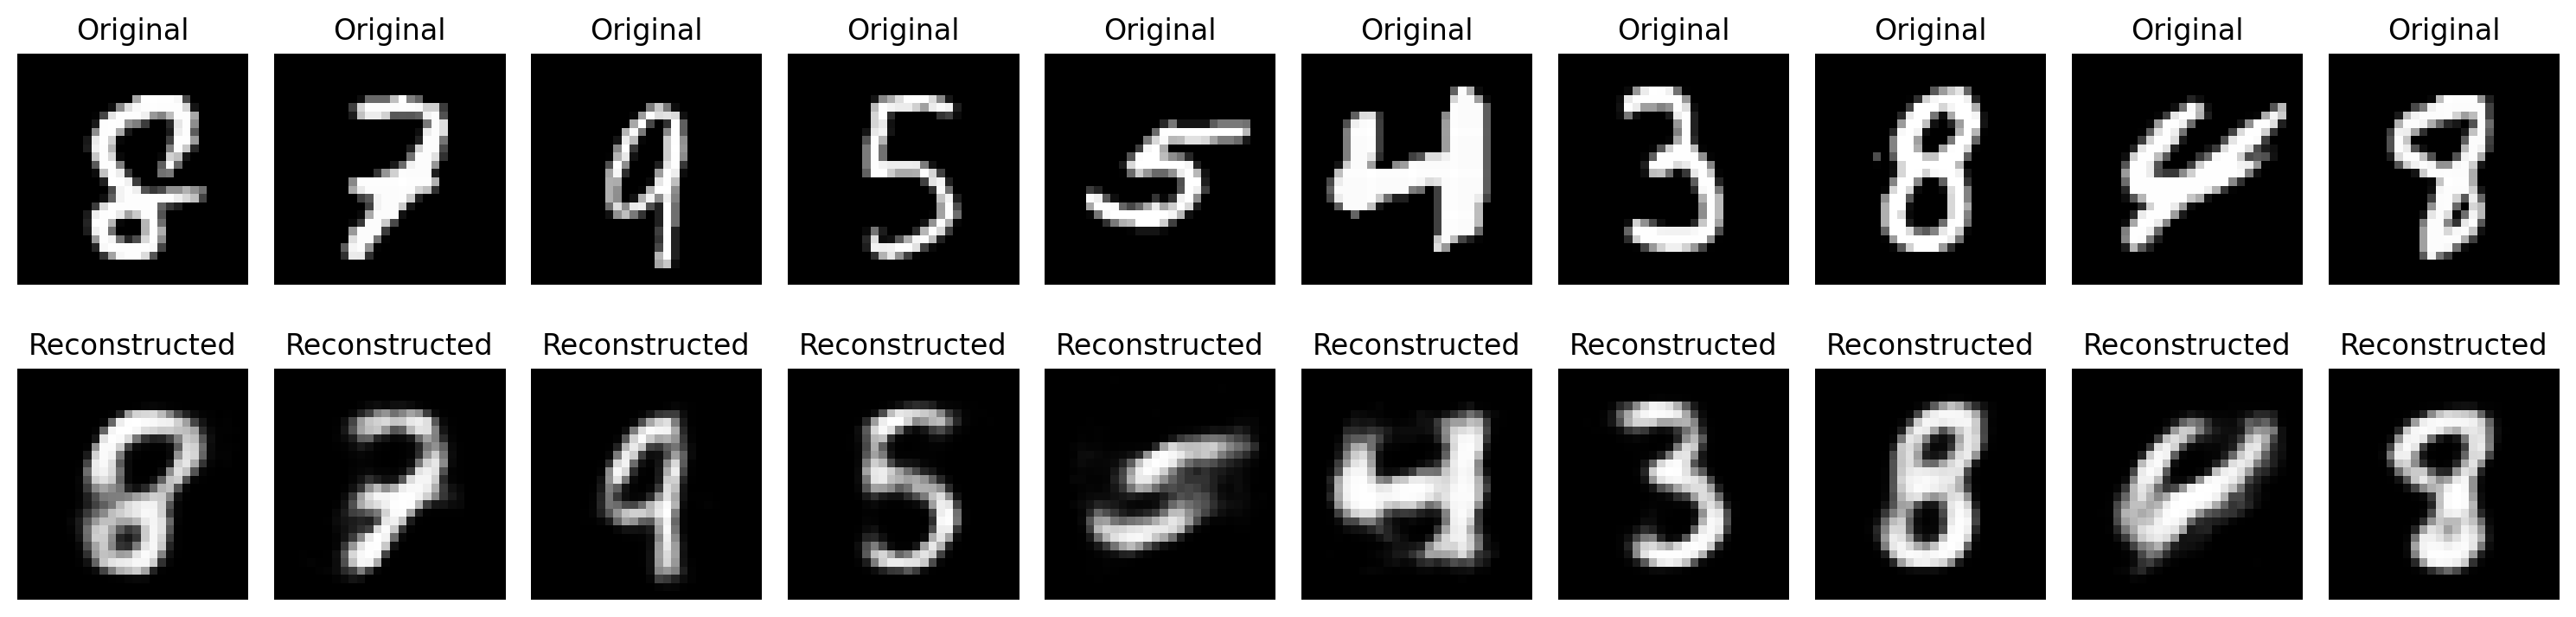

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 30 projected dimensions ---------
Epoch 0. Training loss: 0.1767864111726257. Validation loss: 0.11623465139815148
Epoch 1. Training loss: 0.10084307526068931. Validation loss: 0.09362550396868523
Epoch 2. Training loss: 0.0855555621356788. Validation loss: 0.0817926545726492
Epoch 3. Training loss: 0.07491766048108482. Validation loss: 0.07278486043214798
Epoch 4. Training loss: 0.06843197413995354. Validation loss: 0.06757887249931376
Epoch 5. Training loss: 0.0641702224436978. Validation loss: 0.06460909946484769
Epoch 6. Training loss: 0.061437006034380334. Validation loss: 0.061425802951797524
Epoch 7. Training loss: 0.059364058474205776. Validation loss: 0.06019427923763052
Epoch 8. Training loss: 0.057495775833641266. Validation loss: 0.0592831589757128
Epoch 9. Training loss: 0.055520054513842544. Validation loss: 0.05819185195451087


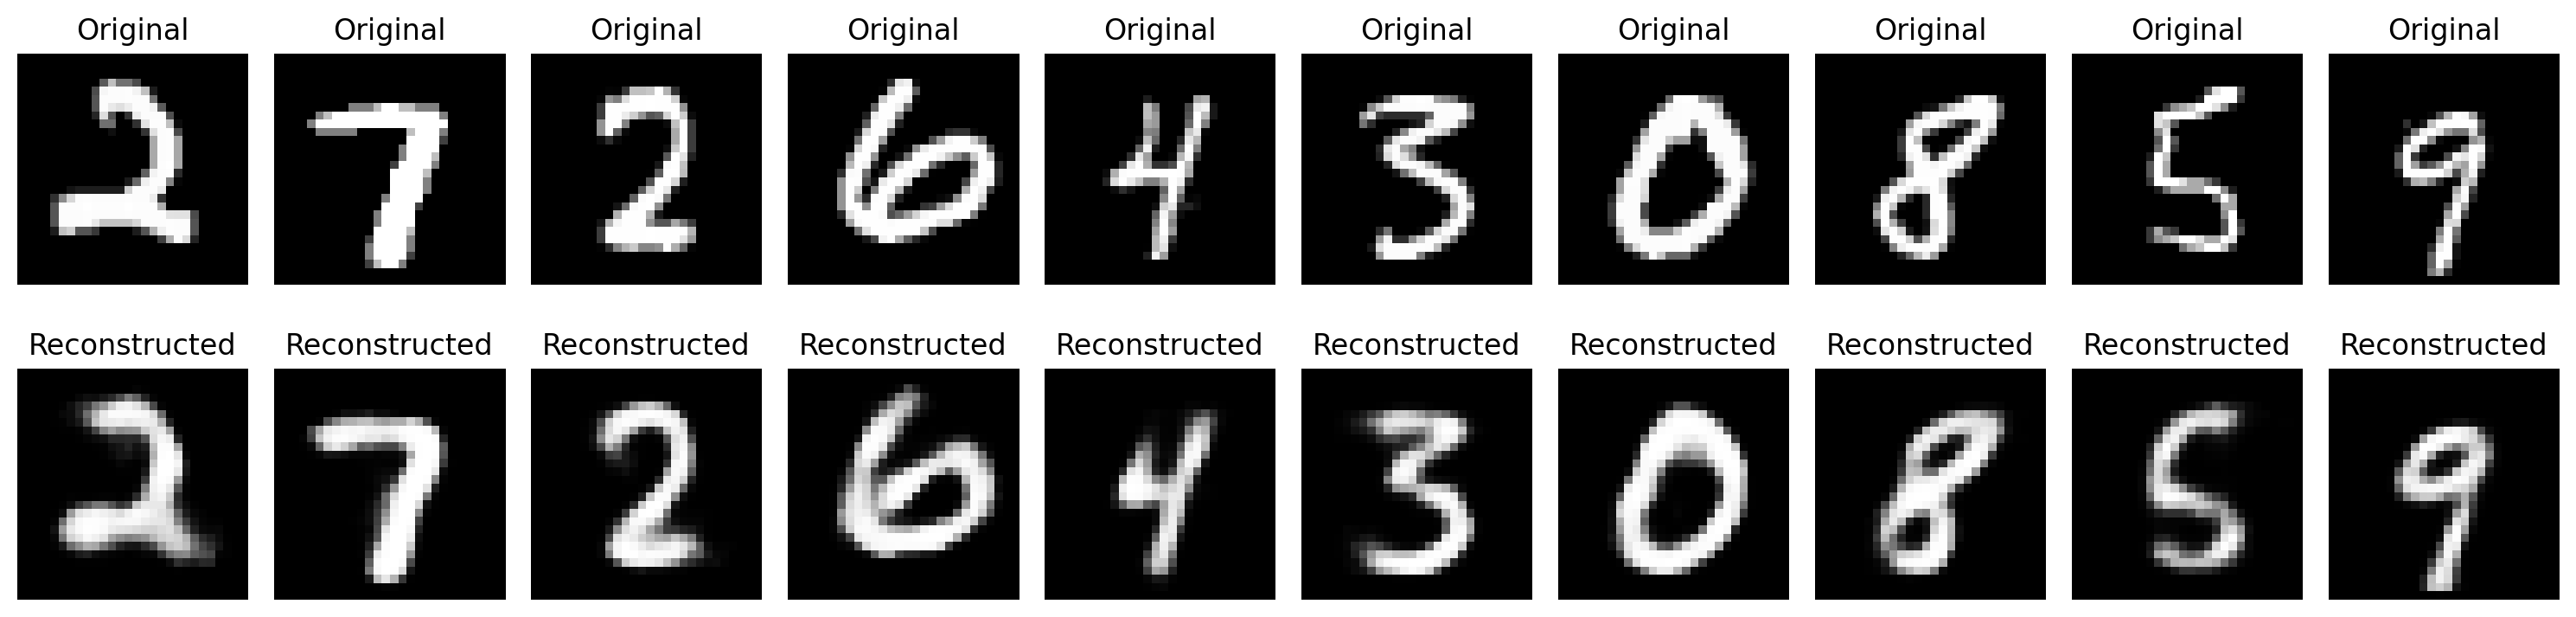

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 50 projected dimensions ---------
Epoch 0. Training loss: 0.1711914773331955. Validation loss: 0.10700867394817637
Epoch 1. Training loss: 0.0905932966217568. Validation loss: 0.08233301306658602
Epoch 2. Training loss: 0.07202336072540758. Validation loss: 0.07009074296405975
Epoch 3. Training loss: 0.06301625303140926. Validation loss: 0.0618040199926559
Epoch 4. Training loss: 0.056047089736570015. Validation loss: 0.05544623046162281
Epoch 5. Training loss: 0.05104746247789907. Validation loss: 0.05099968385506184
Epoch 6. Training loss: 0.04749202796533196. Validation loss: 0.04871825694720796
Epoch 7. Training loss: 0.044855564684522425. Validation loss: 0.04580665563649319
Epoch 8. Training loss: 0.04291342958723279. Validation loss: 0.0440587358747391
Epoch 9. Training loss: 0.04129817117725245. Validation loss: 0.045079783492899955


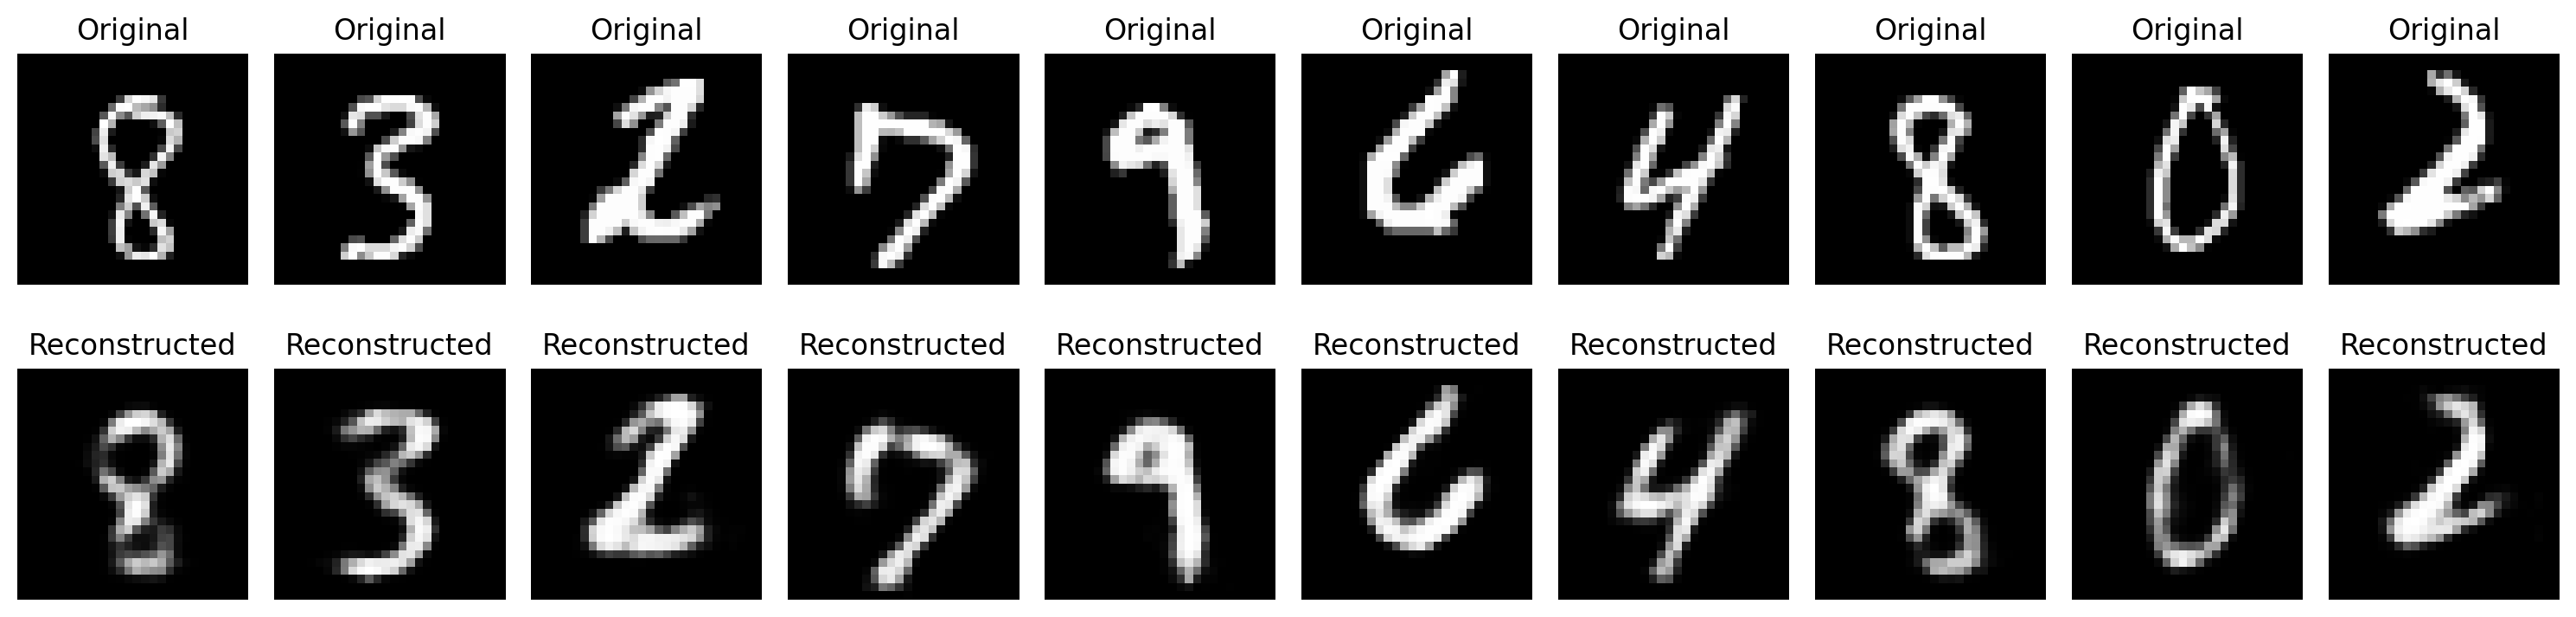

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 100 projected dimensions ---------
Epoch 0. Training loss: 0.1536400797671046. Validation loss: 0.090273798336374
Epoch 1. Training loss: 0.07425691118590873. Validation loss: 0.06769230105775467
Epoch 2. Training loss: 0.05745829088317061. Validation loss: 0.054343740626218474
Epoch 3. Training loss: 0.048869833768218414. Validation loss: 0.049581559905980496
Epoch 4. Training loss: 0.043145332056817344. Validation loss: 0.04419155702628988
Epoch 5. Training loss: 0.03933369592943398. Validation loss: 0.04208307044303163
Epoch 6. Training loss: 0.036449619812298224. Validation loss: 0.03778243316931928
Epoch 7. Training loss: 0.0343562705701598. Validation loss: 0.03532799563192306
Epoch 8. Training loss: 0.032592072847447445. Validation loss: 0.03527865615930963
Epoch 9. Training loss: 0.03134383417041549. Validation loss: 0.03353319301250133


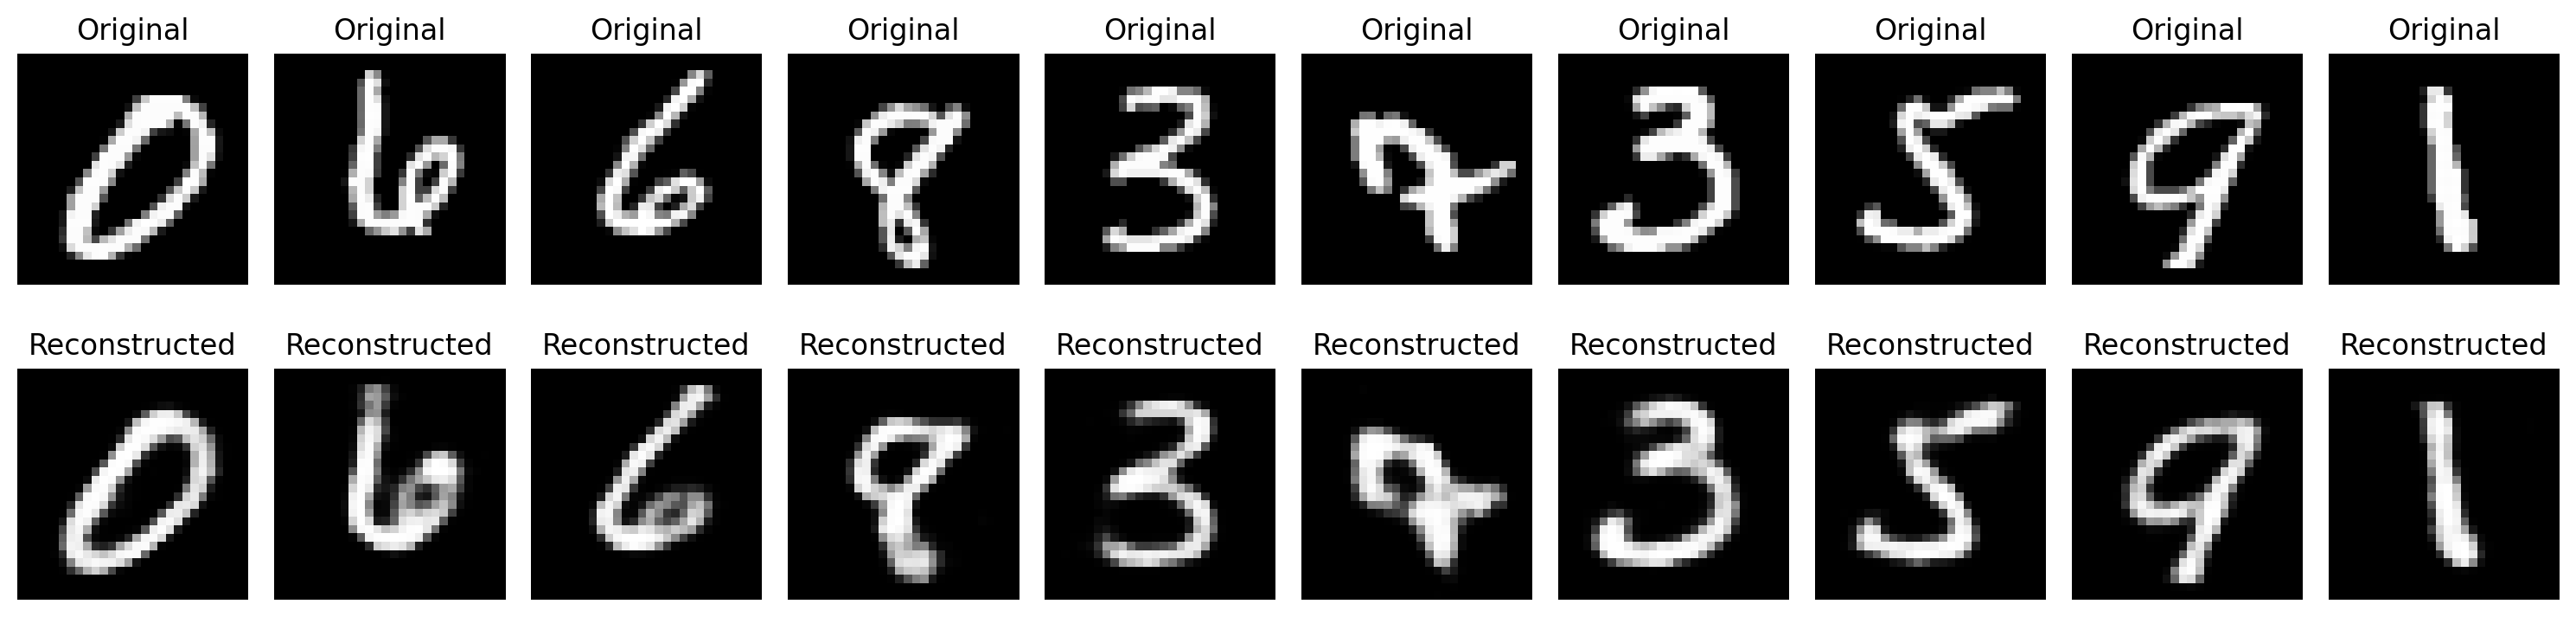

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 15 projected dimensions ---------
Epoch 0. Training loss: 0.21913989800536496. Validation loss: 0.16034401496674153
Epoch 1. Training loss: 0.1371745081851259. Validation loss: 0.12653673196092566
Epoch 2. Training loss: 0.11454216940116814. Validation loss: 0.11093547071548218
Epoch 3. Training loss: 0.10514006735122. Validation loss: 0.10574405957409676
Epoch 4. Training loss: 0.0994336308318783. Validation loss: 0.09873903463495538
Epoch 5. Training loss: 0.0942587884650989. Validation loss: 0.09427416435581573
Epoch 6. Training loss: 0.09011330517982556. Validation loss: 0.09005503822514352
Epoch 7. Training loss: 0.08674588918008587. Validation loss: 0.0879068801060636
Epoch 8. Training loss: 0.08427652734628116. Validation loss: 0.08674913660642948
Epoch 9. Training loss: 0.08225171166387471. Validation loss: 0.0834762620640562


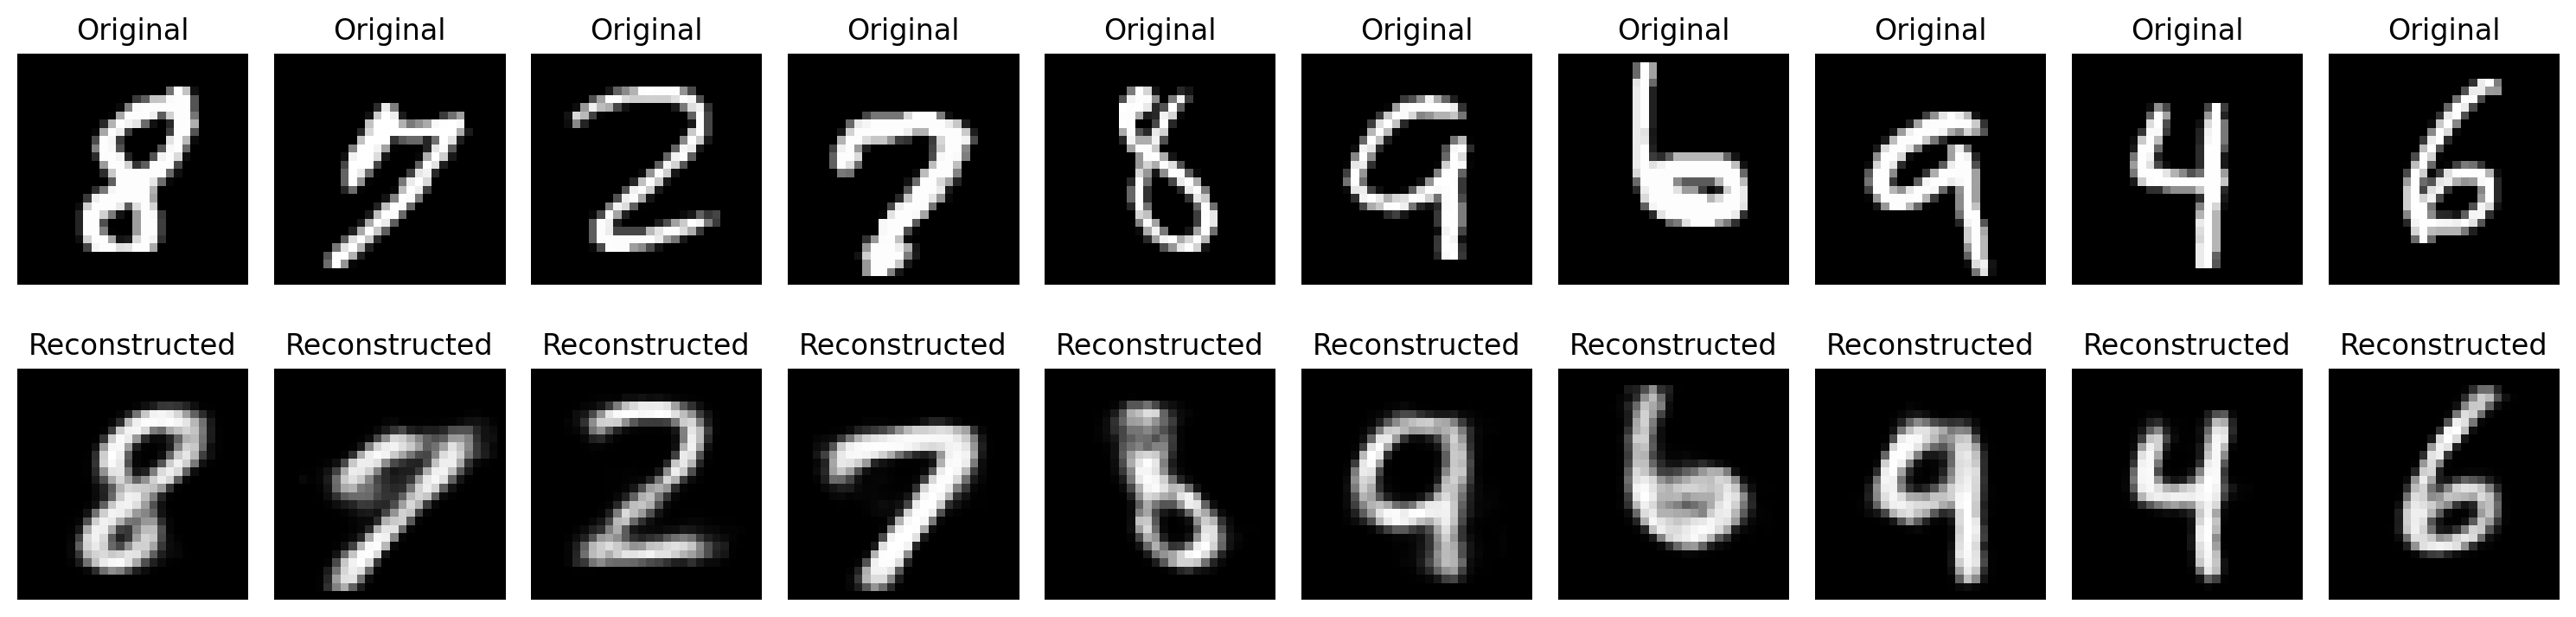

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 30 projected dimensions ---------
Epoch 0. Training loss: 0.21781286182390017. Validation loss: 0.14669905216135878
Epoch 1. Training loss: 0.1304586087776856. Validation loss: 0.12095727980770964
Epoch 2. Training loss: 0.11111152115997604. Validation loss: 0.10663028146992339
Epoch 3. Training loss: 0.09958249527368356. Validation loss: 0.09887100978100553
Epoch 4. Training loss: 0.09359285291495988. Validation loss: 0.09621725072886081
Epoch 5. Training loss: 0.08946115751115774. Validation loss: 0.0917343129502966
Epoch 6. Training loss: 0.08640840301417153. Validation loss: 0.0874574566141088
Epoch 7. Training loss: 0.08374591984532097. Validation loss: 0.08598233664289434
Epoch 8. Training loss: 0.08128703967668116. Validation loss: 0.08391173624611915
Epoch 9. Training loss: 0.07877398674926636. Validation loss: 0.08104176140846091


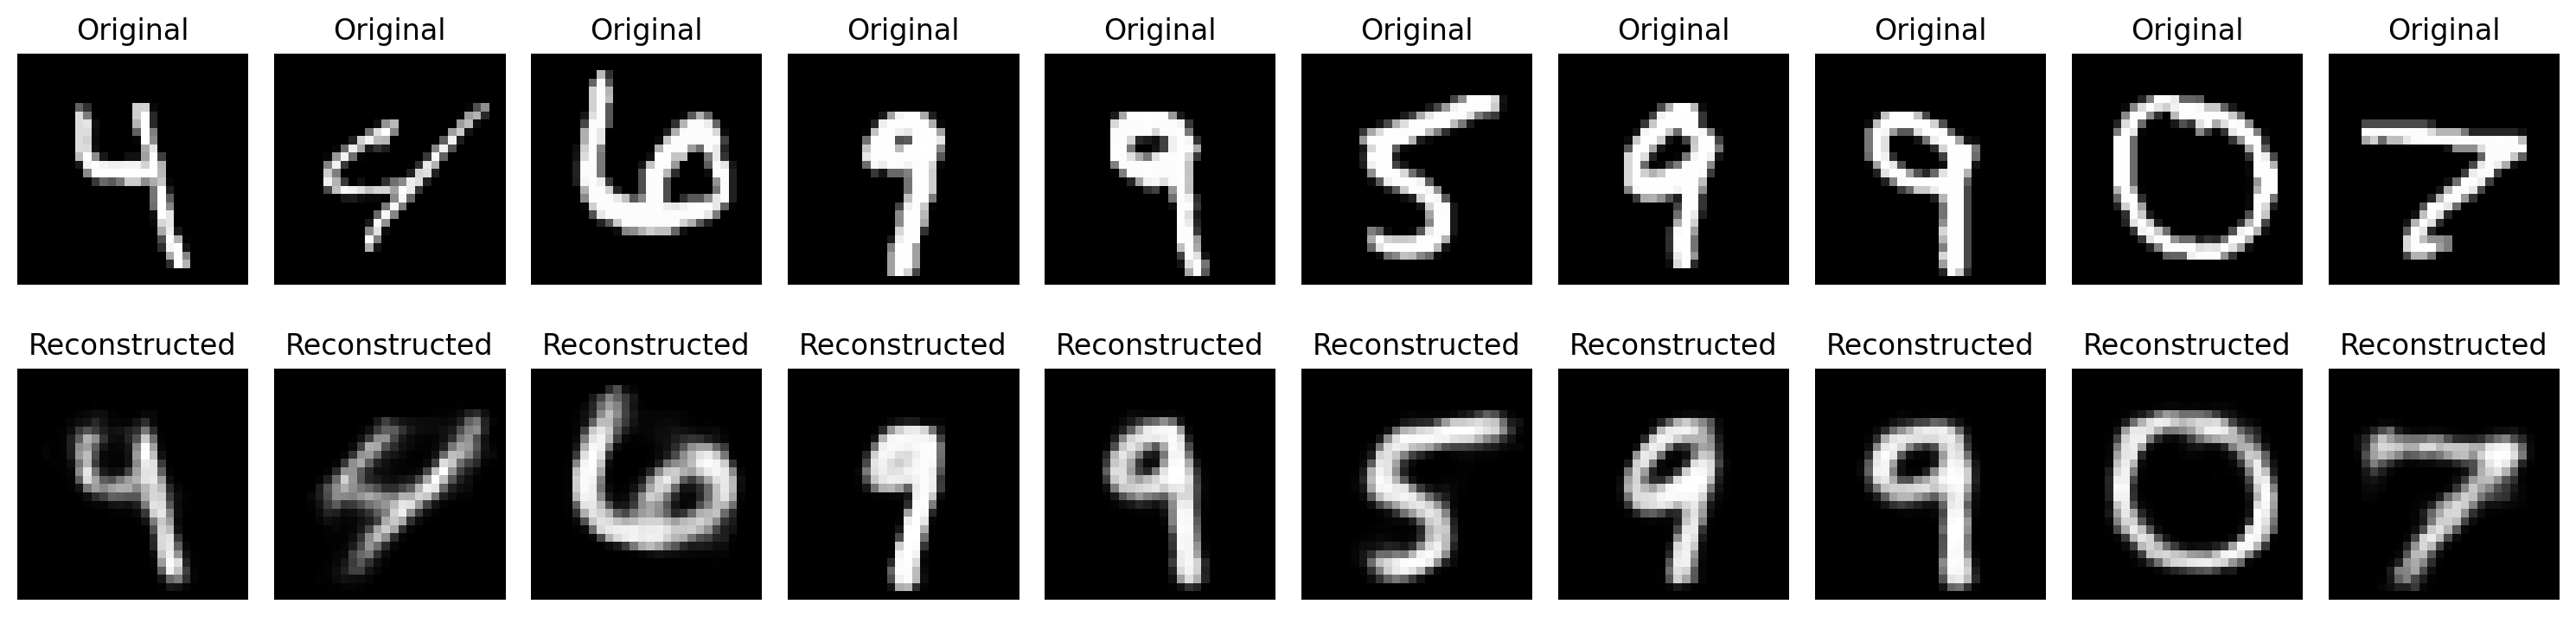

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 50 projected dimensions ---------
Epoch 0. Training loss: 0.2185648529240015. Validation loss: 0.15146909571708517
Epoch 1. Training loss: 0.1237297051755542. Validation loss: 0.11469524550311108
Epoch 2. Training loss: 0.10525313109709797. Validation loss: 0.10157311999417366
Epoch 3. Training loss: 0.09599767431659116. Validation loss: 0.0956313467406212
Epoch 4. Training loss: 0.08988158791114322. Validation loss: 0.08989372319997625
Epoch 5. Training loss: 0.08445898771540007. Validation loss: 0.08603098506623126
Epoch 6. Training loss: 0.07999933206222275. Validation loss: 0.08124646985150398
Epoch 7. Training loss: 0.0758231760066172. Validation loss: 0.08209428597003855
Epoch 8. Training loss: 0.07222551195247268. Validation loss: 0.07394373187042297
Epoch 9. Training loss: 0.0698590840117752. Validation loss: 0.07231064621121325


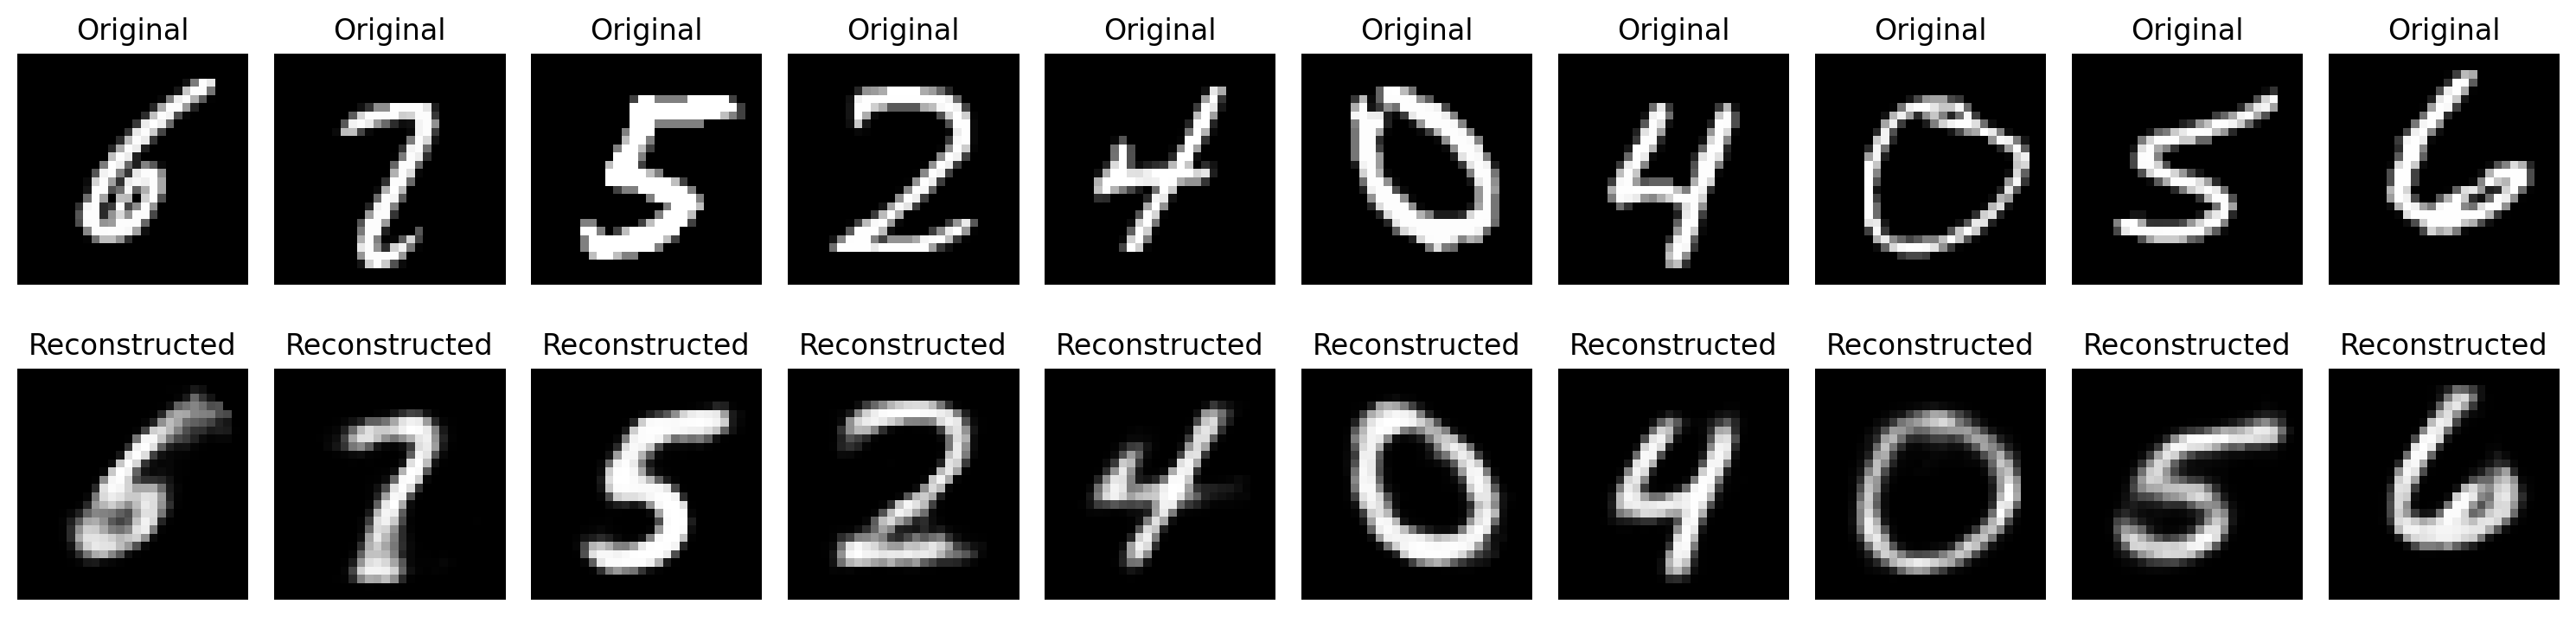

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 100 projected dimensions ---------
Epoch 0. Training loss: 0.19897551272614775. Validation loss: 0.13468471261415077
Epoch 1. Training loss: 0.1100121038775383. Validation loss: 0.10031562913605507
Epoch 2. Training loss: 0.09384729610544375. Validation loss: 0.09177398998686608
Epoch 3. Training loss: 0.08688289403322745. Validation loss: 0.08661998618156352
Epoch 4. Training loss: 0.08254038808147678. Validation loss: 0.08347513726417055
Epoch 5. Training loss: 0.07968706306366419. Validation loss: 0.08100691567710105
Epoch 6. Training loss: 0.07716070871736685. Validation loss: 0.08002024375377817
Epoch 7. Training loss: 0.07471519741441378. Validation loss: 0.07965098175596684
Epoch 8. Training loss: 0.0727828036443415. Validation loss: 0.07553509213822954
Epoch 9. Training loss: 0.0699505609809421. Validation loss: 0.07235540371943028


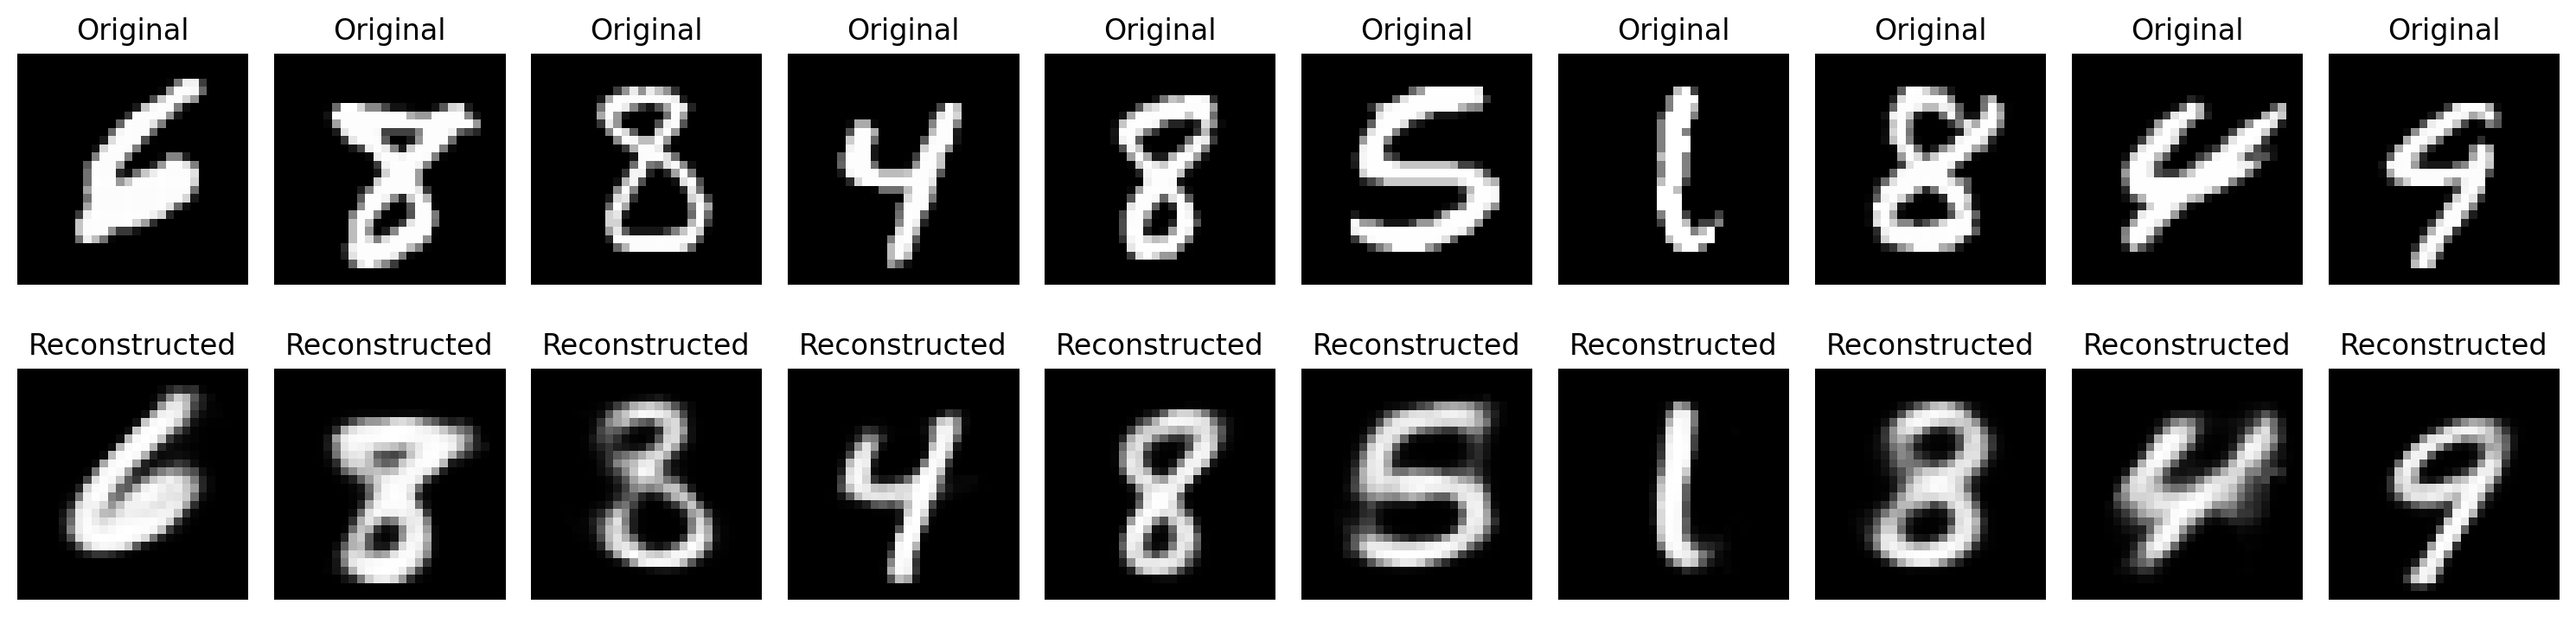

-----------------------------------------------------------------------------


In [ ]:
hyperparameter = {
    'layers': [3, 5],
    'projected': [15,30,50,100]
}

hidden = {
    '3': {
        '15': [128, 32],
        '30': [128, 64],
        '50': [128, 96],
        '100': [256, 128]
    },
    '5': {
        '15': [256, 128, 64, 32],
        '30': [256, 128, 96, 64],
        '50': [256, 128, 96, 64],
        '100': [512, 256, 192, 128]
    }
}

results_train = {}
results_valid = {}

for i in hyperparameter['layers']:
  for j in hyperparameter['projected']:
    print(f'------------- AUTOENCODER: {i} layers and {j} projected dimensions ---------')
    autoencoder =  Autoencoder_extended(dimx=784, hidden=hidden[str(i)][str(j)], projected=j, layers=i, epochs=10, lr=1e-3)
    autoencoder.trainloop(trainloader, validloader)
    autoencoder.plot_reconstructions(testloader)
    if str(i) not in results_train:
      results_train[str(i)] = {}
    results_train[str(i)][str(j)] = autoencoder.loss_during_training
    if str(i) not in results_valid:
      results_valid[str(i)] = {}
    results_valid[str(i)][str(j)] = autoencoder.valid_loss_during_training
    print(f'-----------------------------------------------------------------------------')


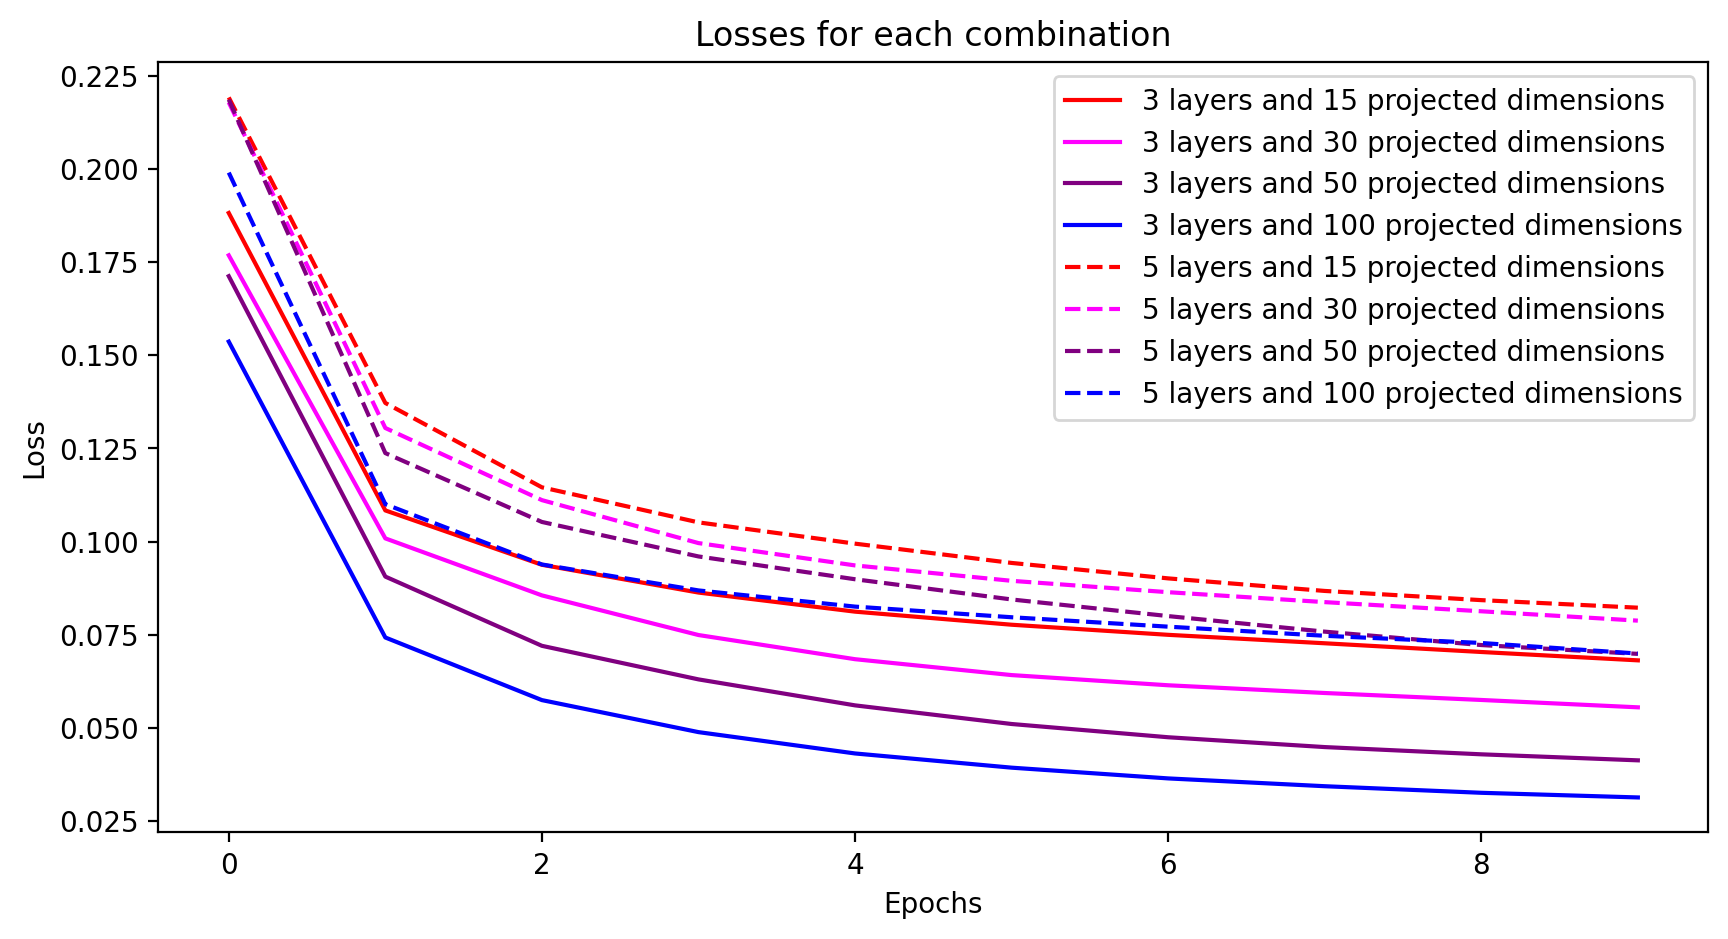

In [ ]:
plt.figure(figsize=(10,5))
colors = ['red', 'magenta', 'purple', 'blue']
plt.gca().set_prop_cycle(color=colors)
for layer, projected_dict in results_train.items():
  for projected, array in projected_dict.items():
    if layer == '3':
      plt.plot(array, label=f'{layer} layers and {projected} projected dimensions')
    else:
      plt.plot(array, label=f'{layer} layers and {projected} projected dimensions', linestyle = '--')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses for each combination')

# Show plot
plt.show()

#### 2.1.3. Study learning rate

------------- AUTOENCODER: $alpha$ = 1e-05 -----------------------------------
Epoch 0. Training loss: 0.4942677964625711. Validation loss: 0.264627672129489
Epoch 1. Training loss: 0.26248284918256104. Validation loss: 0.2573122576196143
Epoch 2. Training loss: 0.25054821700111707. Validation loss: 0.23712715569962847
Epoch 3. Training loss: 0.22554840890436686. Validation loss: 0.2132932779002697
Epoch 4. Training loss: 0.2027310862375254. Validation loss: 0.19085824876389604
Epoch 5. Training loss: 0.1800339799374342. Validation loss: 0.17100936852871104
Epoch 6. Training loss: 0.16384263334541835. Validation loss: 0.1589606133547235


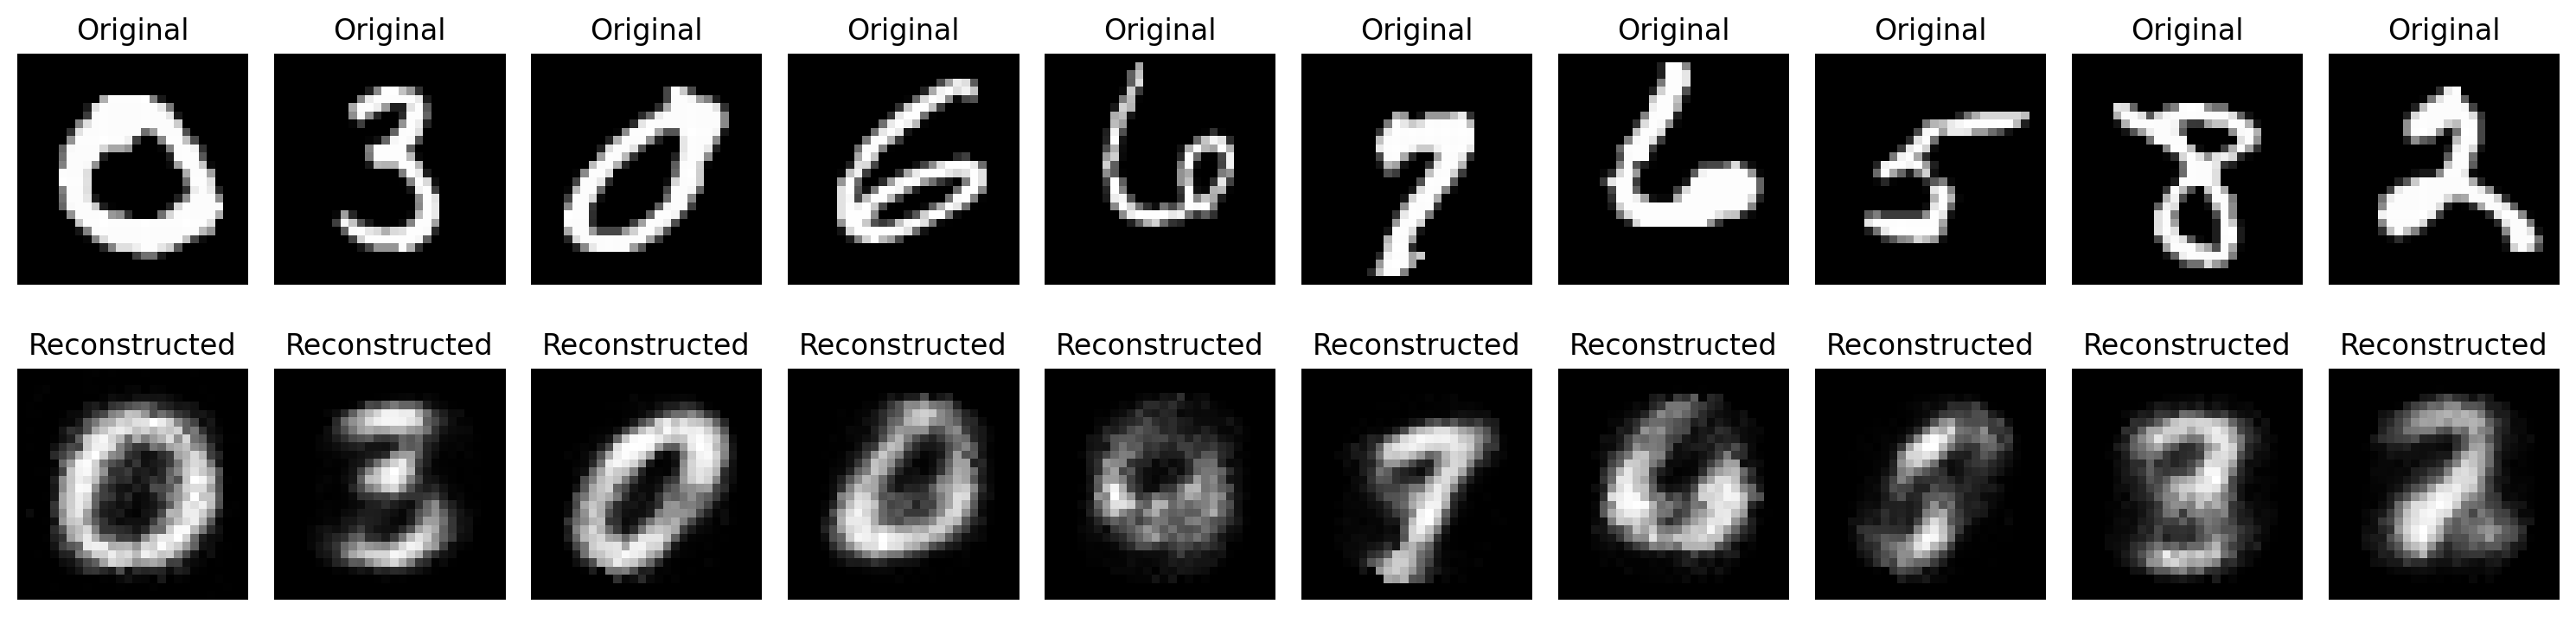

-----------------------------------------------------------------------------
------------- AUTOENCODER: $alpha$ = 0.00017782794100389227 -----------------------------------
Epoch 0. Training loss: 0.22705071763431822. Validation loss: 0.13358381625185622
Epoch 1. Training loss: 0.10911555109884251. Validation loss: 0.09523140734180491
Epoch 2. Training loss: 0.08466575620695949. Validation loss: 0.07808880230530779
Epoch 3. Training loss: 0.07209226764230565. Validation loss: 0.06934378667080655
Epoch 4. Training loss: 0.06435833190864121. Validation loss: 0.06239208702711349
Epoch 5. Training loss: 0.05791940510442311. Validation loss: 0.05697492814444481
Epoch 6. Training loss: 0.05345109615220942. Validation loss: 0.053312589814688296


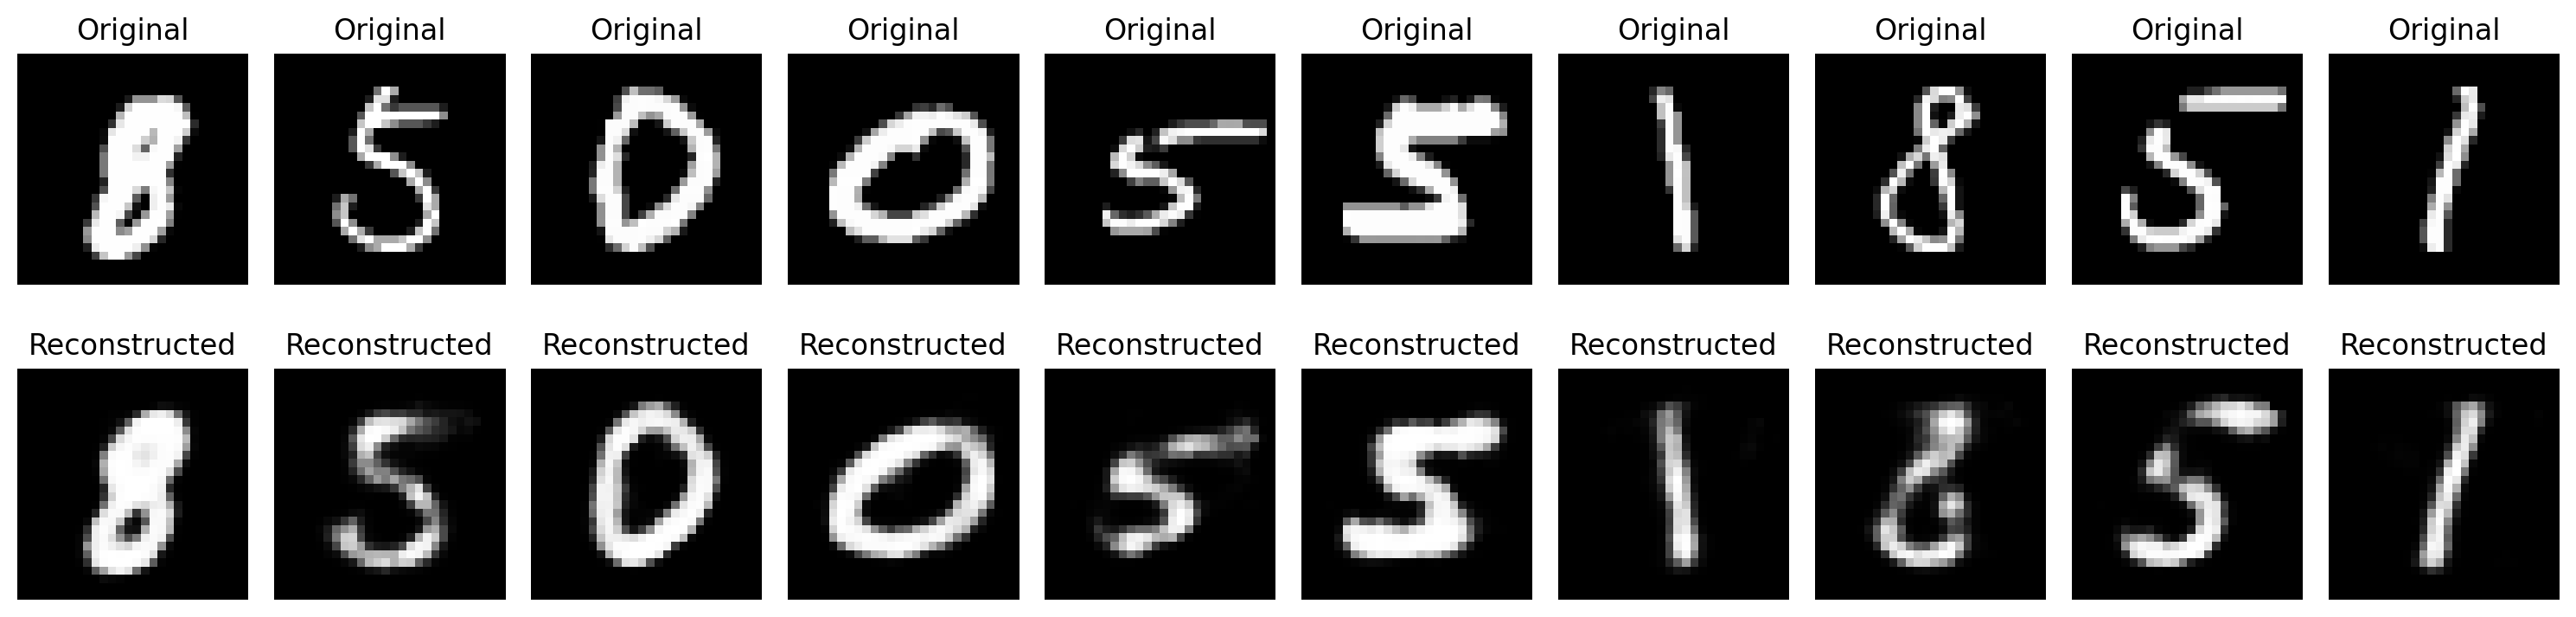

-----------------------------------------------------------------------------
------------- AUTOENCODER: $alpha$ = 0.0031622776601683794 -----------------------------------
Epoch 0. Training loss: 0.14306027280293743. Validation loss: 0.09603284949317892
Epoch 1. Training loss: 0.07788968289969489. Validation loss: 0.07558326492918299
Epoch 2. Training loss: 0.0634717954989438. Validation loss: 0.06507467161467735
Epoch 3. Training loss: 0.05616366462147033. Validation loss: 0.05594509264573138
Epoch 4. Training loss: 0.05125203022775664. Validation loss: 0.05585092677080885
Epoch 5. Training loss: 0.0472716810234653. Validation loss: 0.05257165668175576
Epoch 6. Training loss: 0.04460328100355004. Validation loss: 0.050951591784015614


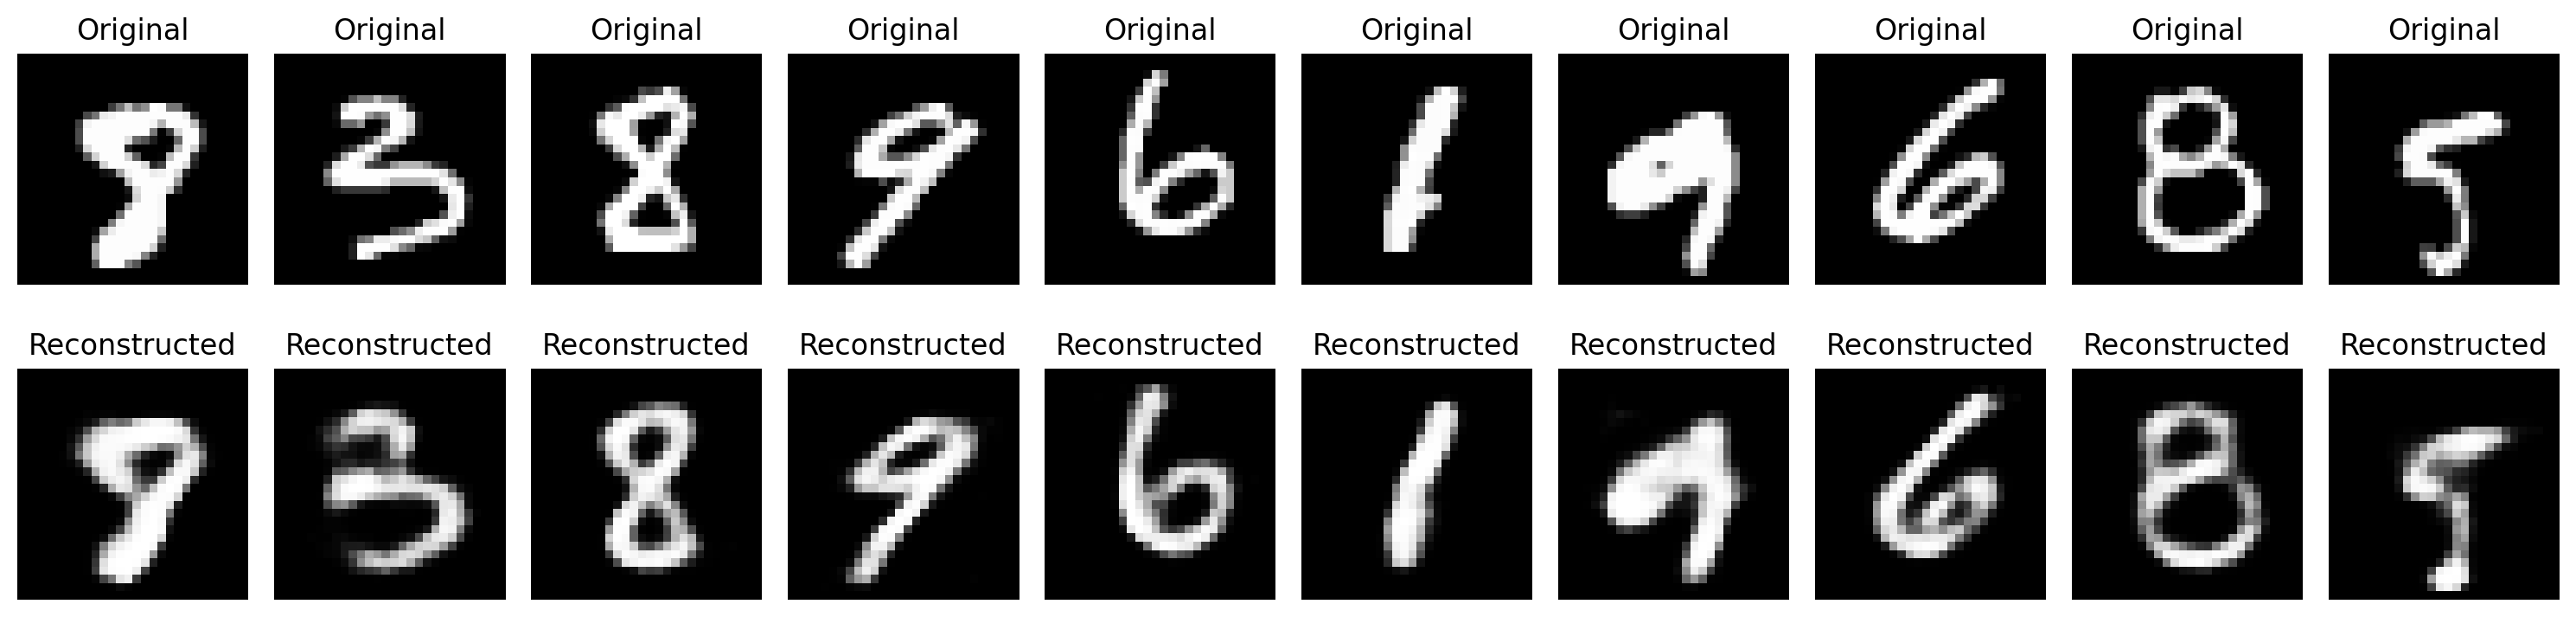

-----------------------------------------------------------------------------
------------- AUTOENCODER: $alpha$ = 0.05623413251903491 -----------------------------------
Epoch 0. Training loss: 0.45595307229086757. Validation loss: 0.45134072823727384
Epoch 1. Training loss: 0.45525688280097465. Validation loss: 0.4512158726124053
Epoch 2. Training loss: 0.45522486909546633. Validation loss: 0.4511058656459159
Epoch 3. Training loss: 0.45537538530135696. Validation loss: 0.45122556141082276
Epoch 4. Training loss: 0.45516711833294143. Validation loss: 0.4510662332494208
Epoch 5. Training loss: 0.4553304271433841. Validation loss: 0.4512077992266797
Epoch 6. Training loss: 0.45539744989946485. Validation loss: 0.45122454749776963


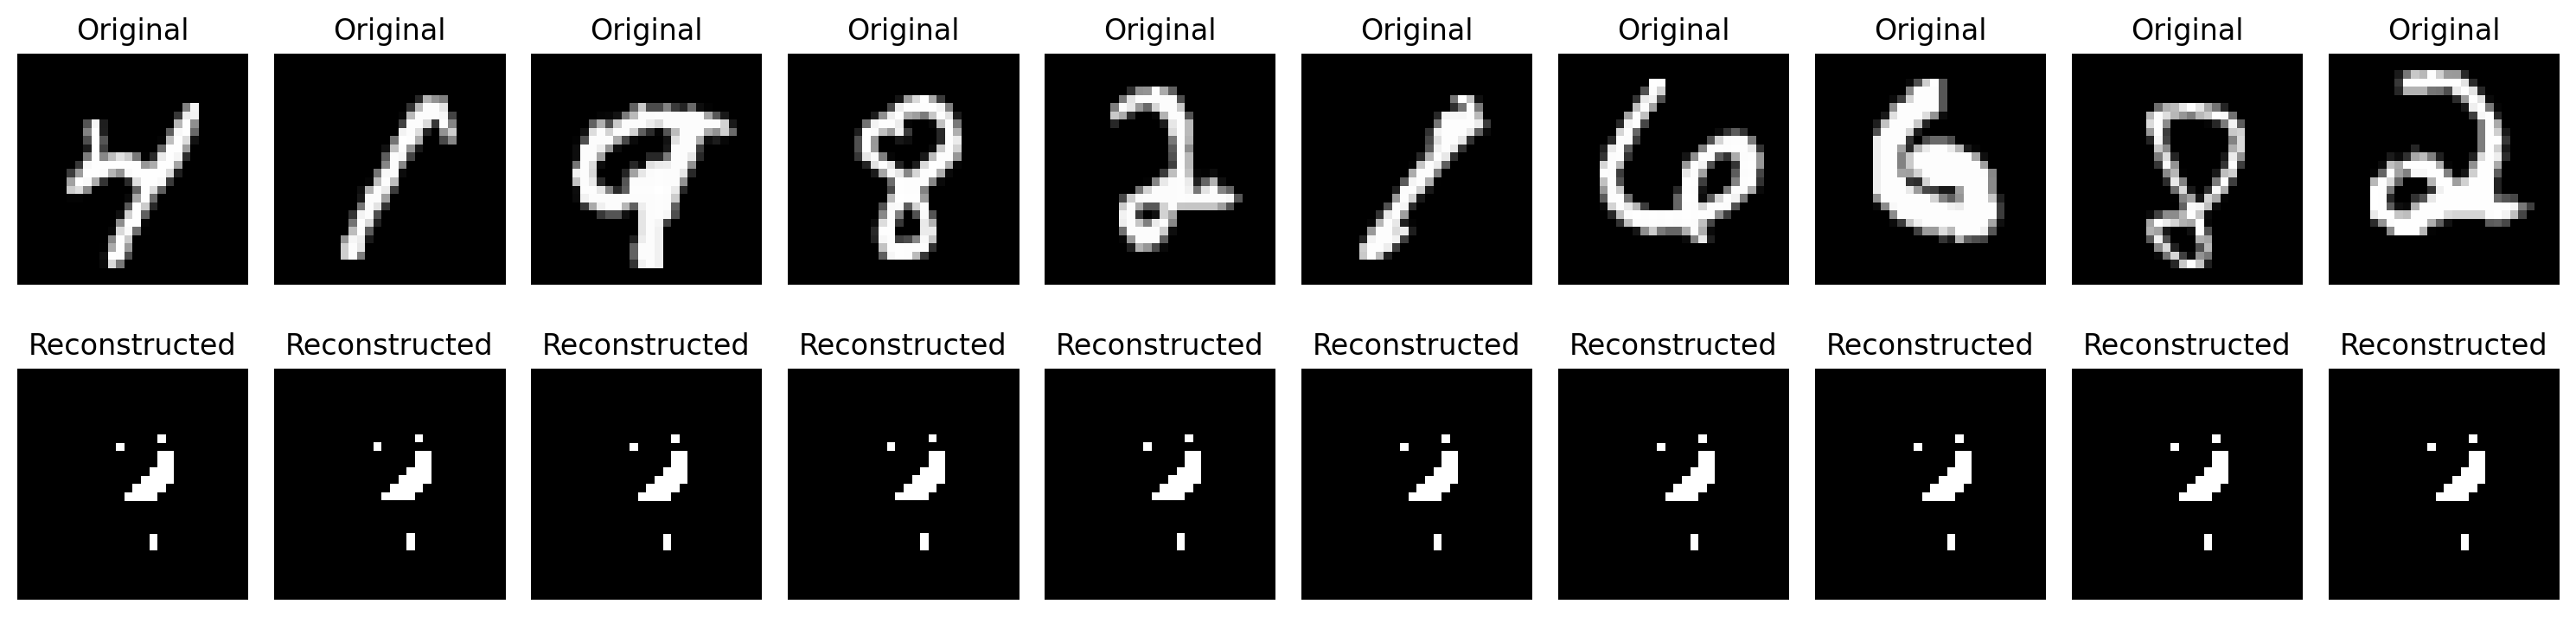

-----------------------------------------------------------------------------
------------- AUTOENCODER: $alpha$ = 1.0 -----------------------------------
Epoch 0. Training loss: 0.45191889882765035. Validation loss: 0.4472766526201938
Epoch 1. Training loss: 0.4510708254423331. Validation loss: 0.44749794234620766
Epoch 2. Training loss: 0.45118572342802177. Validation loss: 0.4473573909160939
Epoch 3. Training loss: 0.451212589755993. Validation loss: 0.4474049327221323
Epoch 4. Training loss: 0.45110619584606454. Validation loss: 0.4473971903324127
Epoch 5. Training loss: 0.4510308310643516. Validation loss: 0.44747473635572066
Epoch 6. Training loss: 0.4510837906378914. Validation loss: 0.4473848512832155


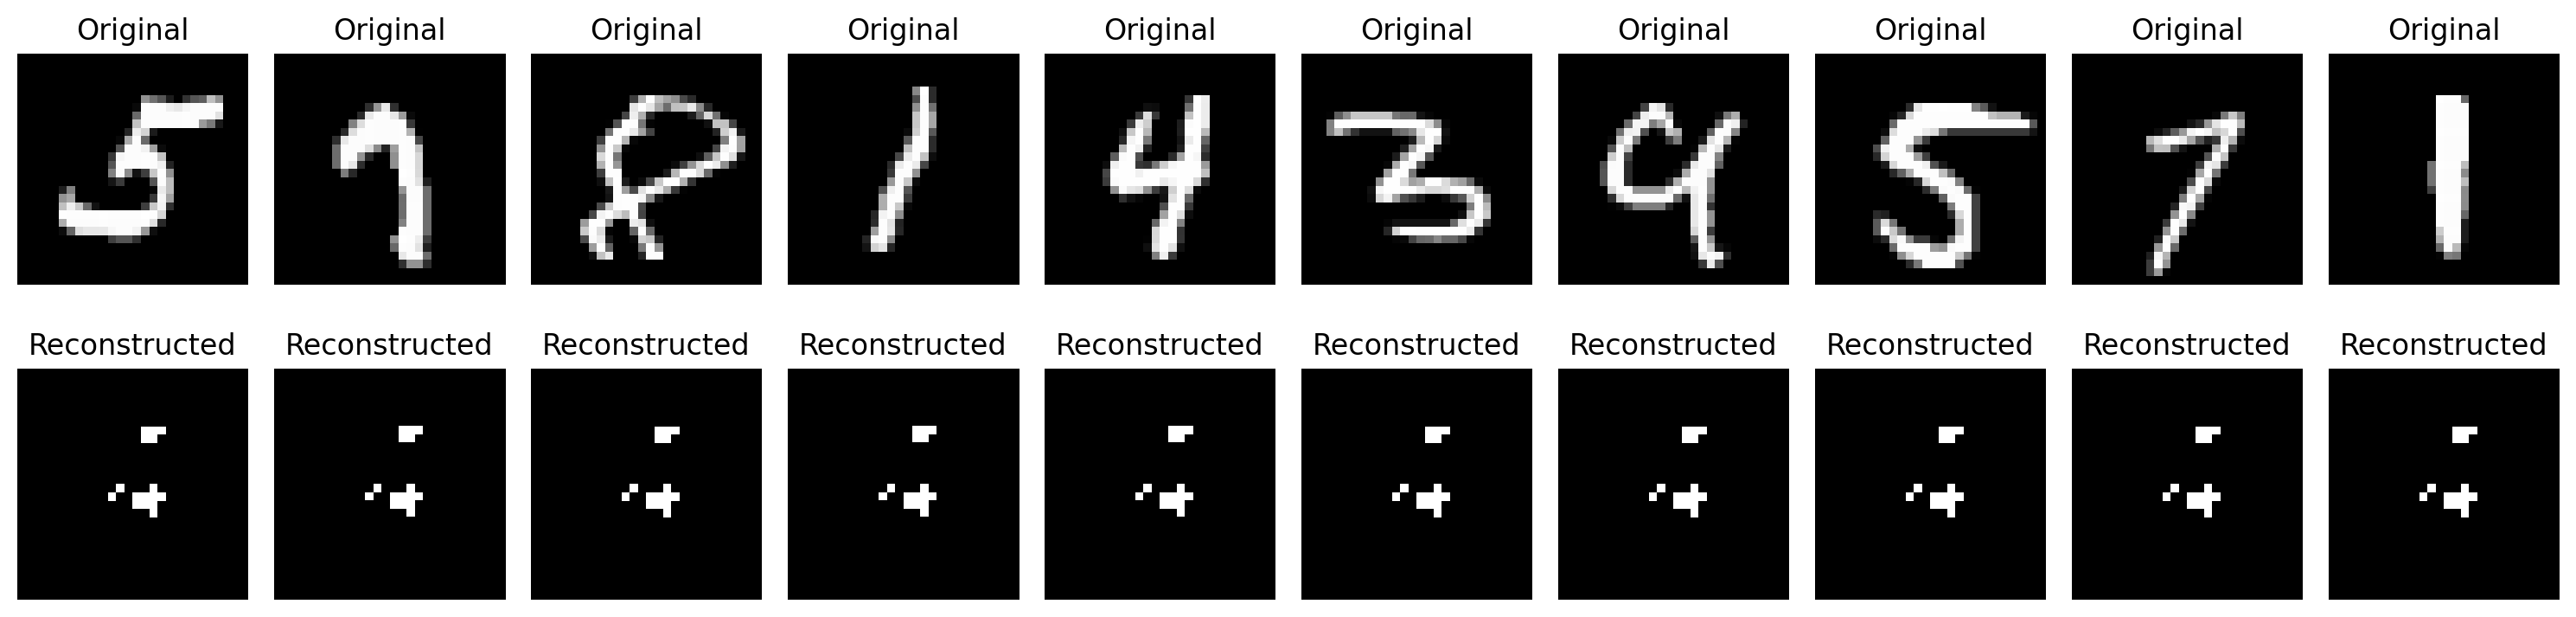

-----------------------------------------------------------------------------


In [ ]:
learning_rates = np.geomspace(1e-5, 1, 5)

results_train_lr = {}
results_valid_lr = {}

for lr in learning_rates:
  autoencoder =  Autoencoder_extended(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=7, lr=lr)
  print(f'------------- AUTOENCODER: $alpha$ = {lr} -----------------------------------')
  autoencoder.trainloop(trainloader, validloader)
  autoencoder.plot_reconstructions(testloader)
  results_train_lr[str(lr)] = autoencoder.loss_during_training
  results_valid_lr[str(lr)] = autoencoder.valid_loss_during_training
  print(f'-----------------------------------------------------------------------------')

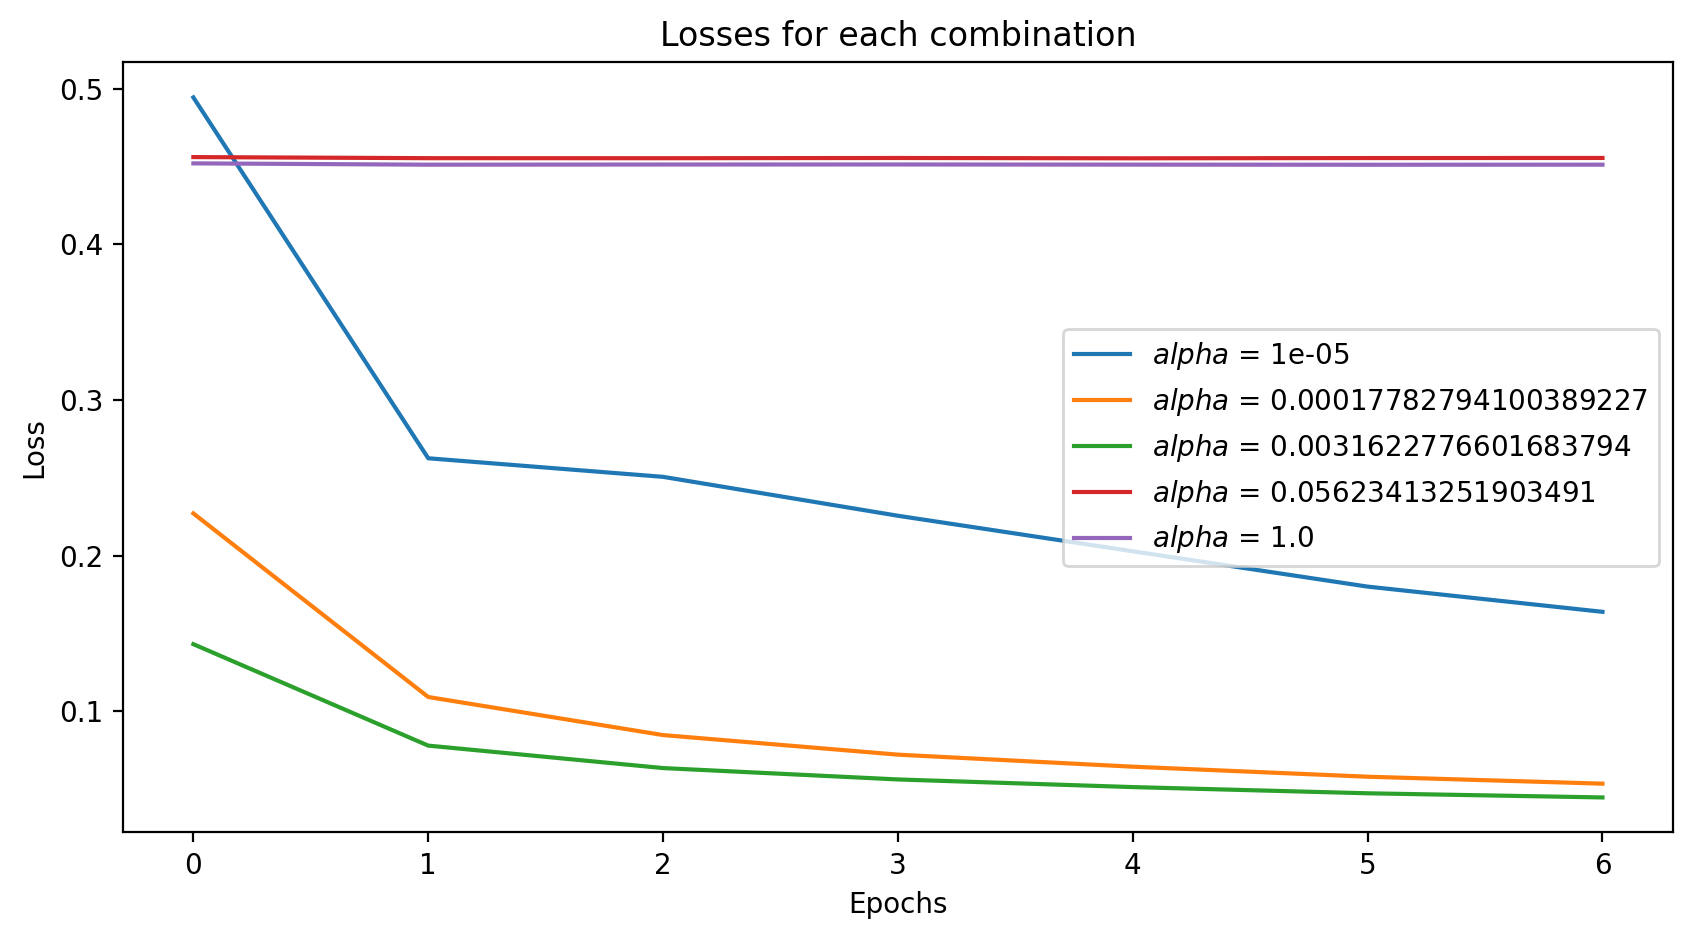

In [ ]:
plt.figure(figsize=(10,5))
for lr, array in results_train_lr.items():
    plt.plot(array, label=f'$alpha$ = {lr}')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses for each combination')

# Show plot
plt.show()

#### 2.1.4. Train selected model

Epoch 0. Training loss: 0.14766940802589737. Validation loss: 0.08825886078337405
Epoch 1. Training loss: 0.07114418679636648. Validation loss: 0.063508789986372
Epoch 2. Training loss: 0.055264310144015. Validation loss: 0.053752685702861625
Epoch 3. Training loss: 0.04709455905355175. Validation loss: 0.04670017754777949
Epoch 4. Training loss: 0.04204925118458711. Validation loss: 0.043969741622184186
Epoch 5. Training loss: 0.03809313924020072. Validation loss: 0.03952709567990709
Epoch 6. Training loss: 0.03527286378613843. Validation loss: 0.03744244578670948
Epoch 7. Training loss: 0.03310662342383611. Validation loss: 0.03840882250286163
Epoch 8. Training loss: 0.03151121945120394. Validation loss: 0.03262240914429756
Epoch 9. Training loss: 0.030008996545802802. Validation loss: 0.033527716019369186
Epoch 10. Training loss: 0.02890615764507939. Validation loss: 0.031058005203909063
Epoch 11. Training loss: 0.027855539054144174. Validation loss: 0.030855388566851615
Epoch 12. T

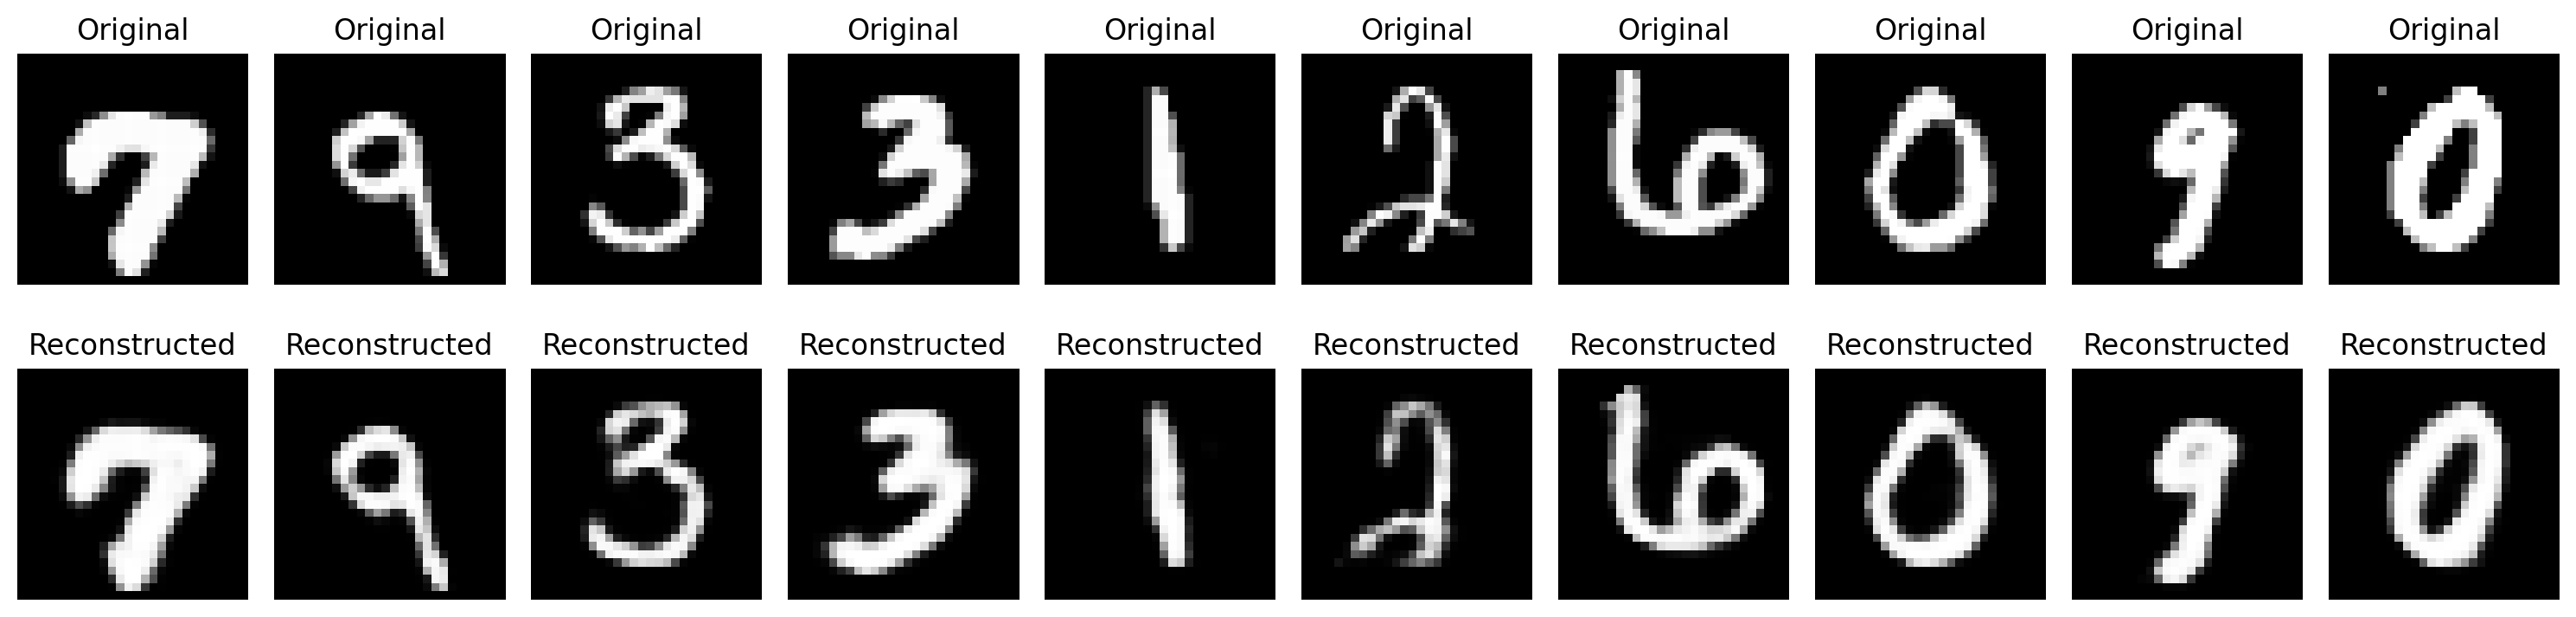

Average reconstrucion loss: 0.018296892713209625


In [ ]:
autoencoder =  Autoencoder_extended(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=50, lr=1e-3)
autoencoder.trainloop(trainloader, validloader)
autoencoder.plot_reconstructions(testloader)
avg_loss = autoencoder.testloop(testloader)

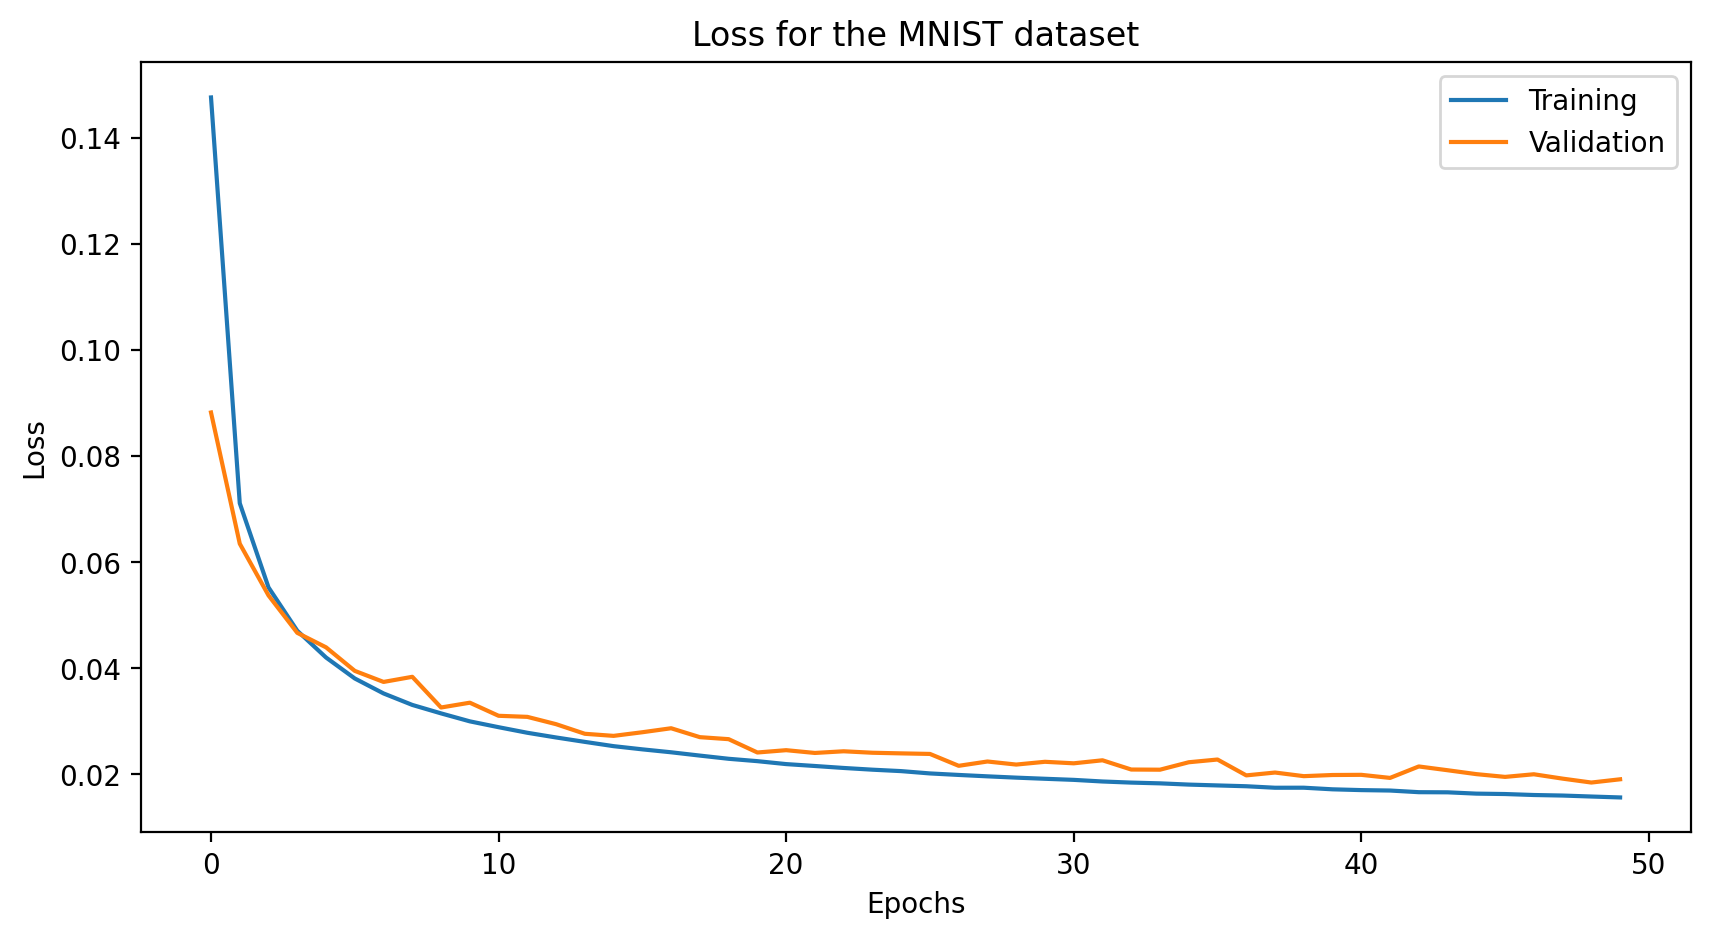

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(autoencoder.loss_during_training, label='Training')
plt.plot(autoencoder.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for the MNIST dataset')

plt.show()

### 2.2. FMNIST

#### 2.2.1. Import and load data

In [ ]:
Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

100%|██████████| 26421880/26421880 [00:01<00:00, 16237871.86it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 260708.62it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5094928.85it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12597594.51it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


#### 2.2.2. Establish hyperparameters and perform cross validation

------------- AUTOENCODER: 3 layers and 15 projected dimensions ---------
Epoch 0. Training loss: 0.1250979054444046. Validation loss: 0.08638136792690196
Epoch 1. Training loss: 0.07957528706174344. Validation loss: 0.07558725276525985
Epoch 2. Training loss: 0.07207858701638709. Validation loss: 0.0714856947831651
Epoch 3. Training loss: 0.06769571533765305. Validation loss: 0.0668733041178673
Epoch 4. Training loss: 0.06492415435654535. Validation loss: 0.06465810993884472


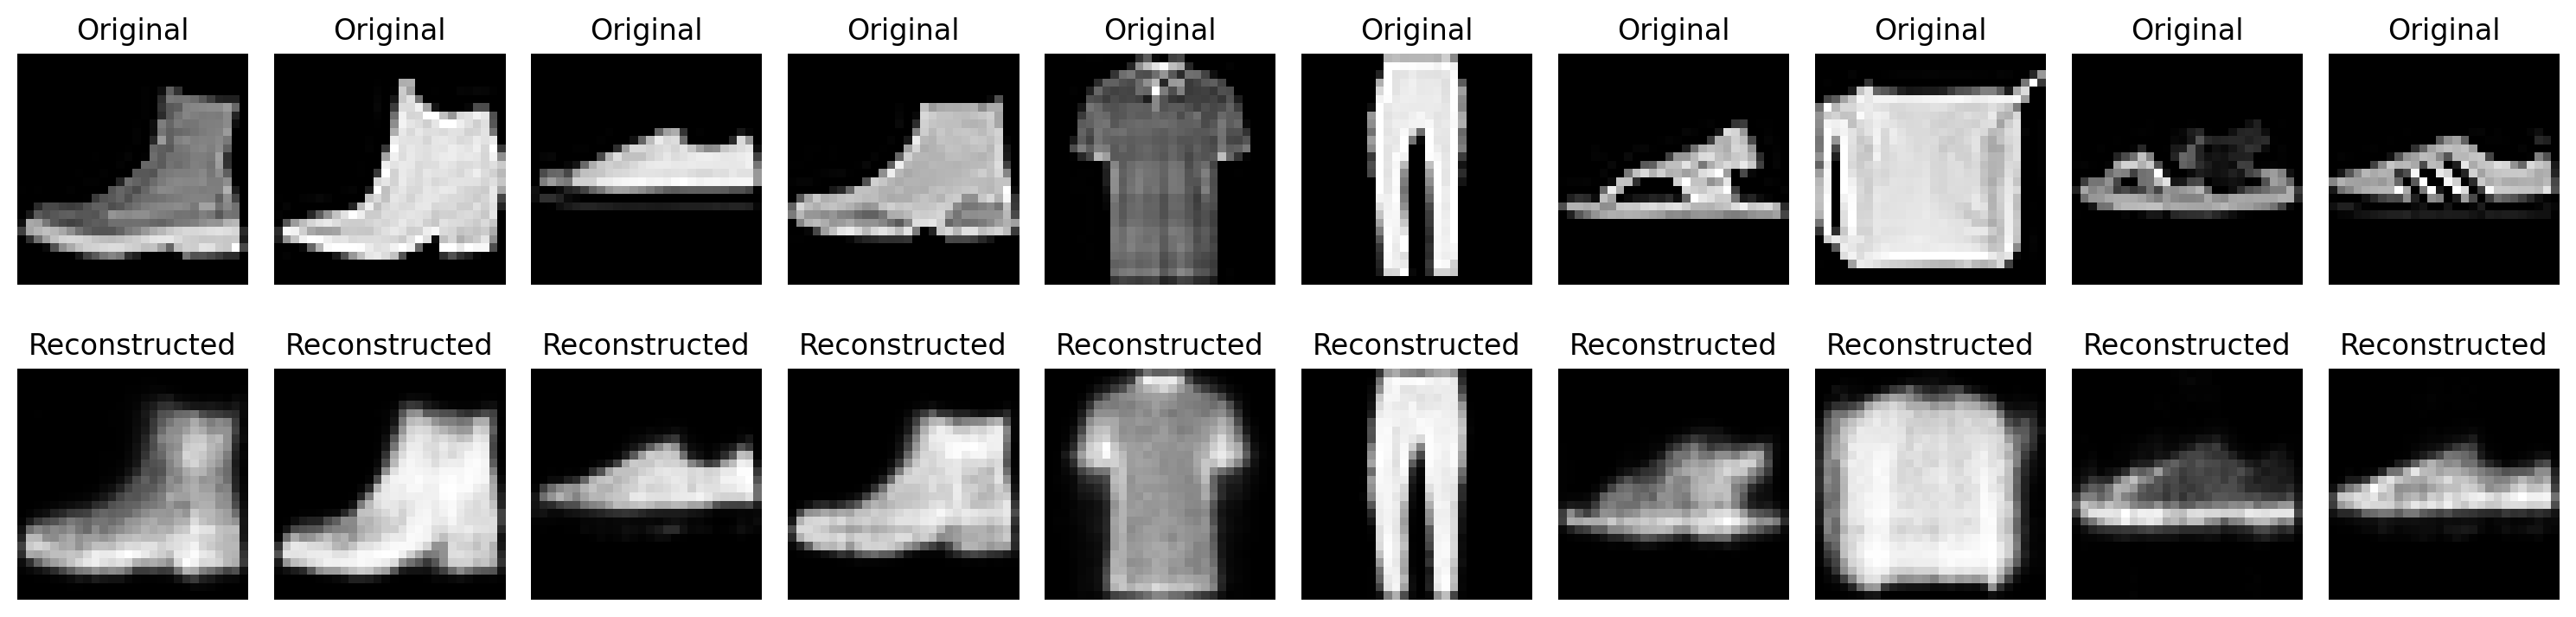

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 30 projected dimensions ---------
Epoch 0. Training loss: 0.1176451465157284. Validation loss: 0.07917652719832481
Epoch 1. Training loss: 0.07200980602911758. Validation loss: 0.0678323968769388
Epoch 2. Training loss: 0.06366103224519809. Validation loss: 0.06130627623580872
Epoch 3. Training loss: 0.058928292519836264. Validation loss: 0.058730648901868375
Epoch 4. Training loss: 0.05615848366340453. Validation loss: 0.056708291141276665


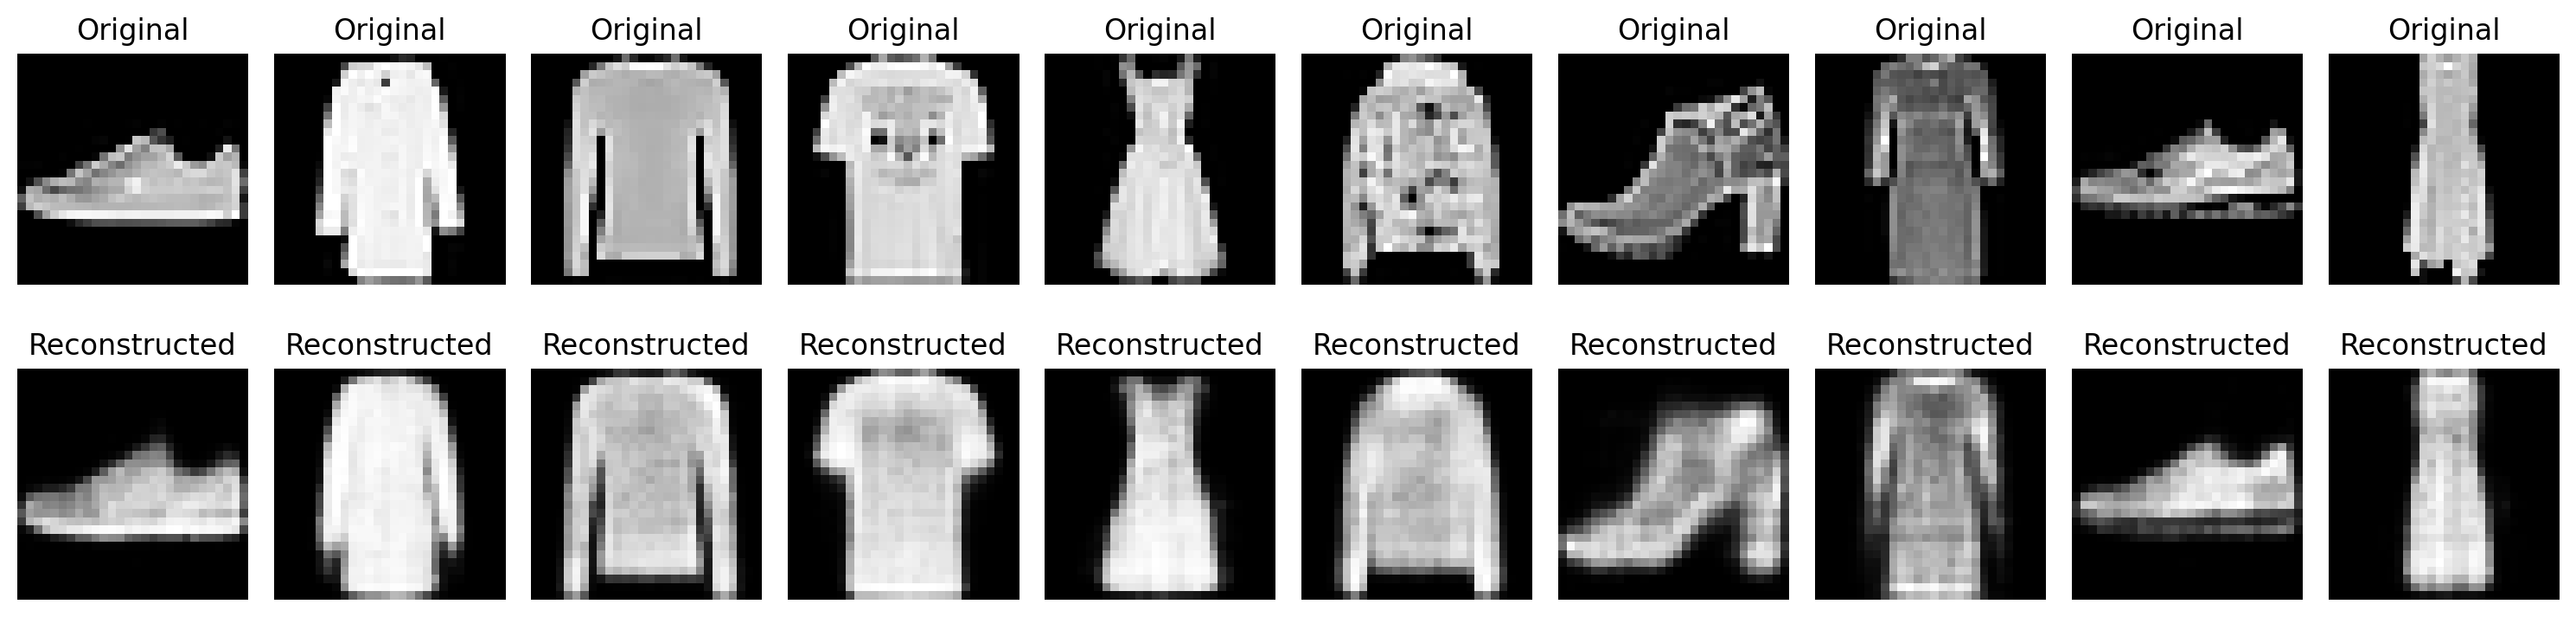

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 50 projected dimensions ---------
Epoch 0. Training loss: 0.11537504191933708. Validation loss: 0.07751348380078661
Epoch 1. Training loss: 0.07010132338936356. Validation loss: 0.0679637279916317
Epoch 2. Training loss: 0.06126262224808505. Validation loss: 0.059764338253026315
Epoch 3. Training loss: 0.0558938851992769. Validation loss: 0.054966787565895854
Epoch 4. Training loss: 0.05224967437309467. Validation loss: 0.05213180686882202


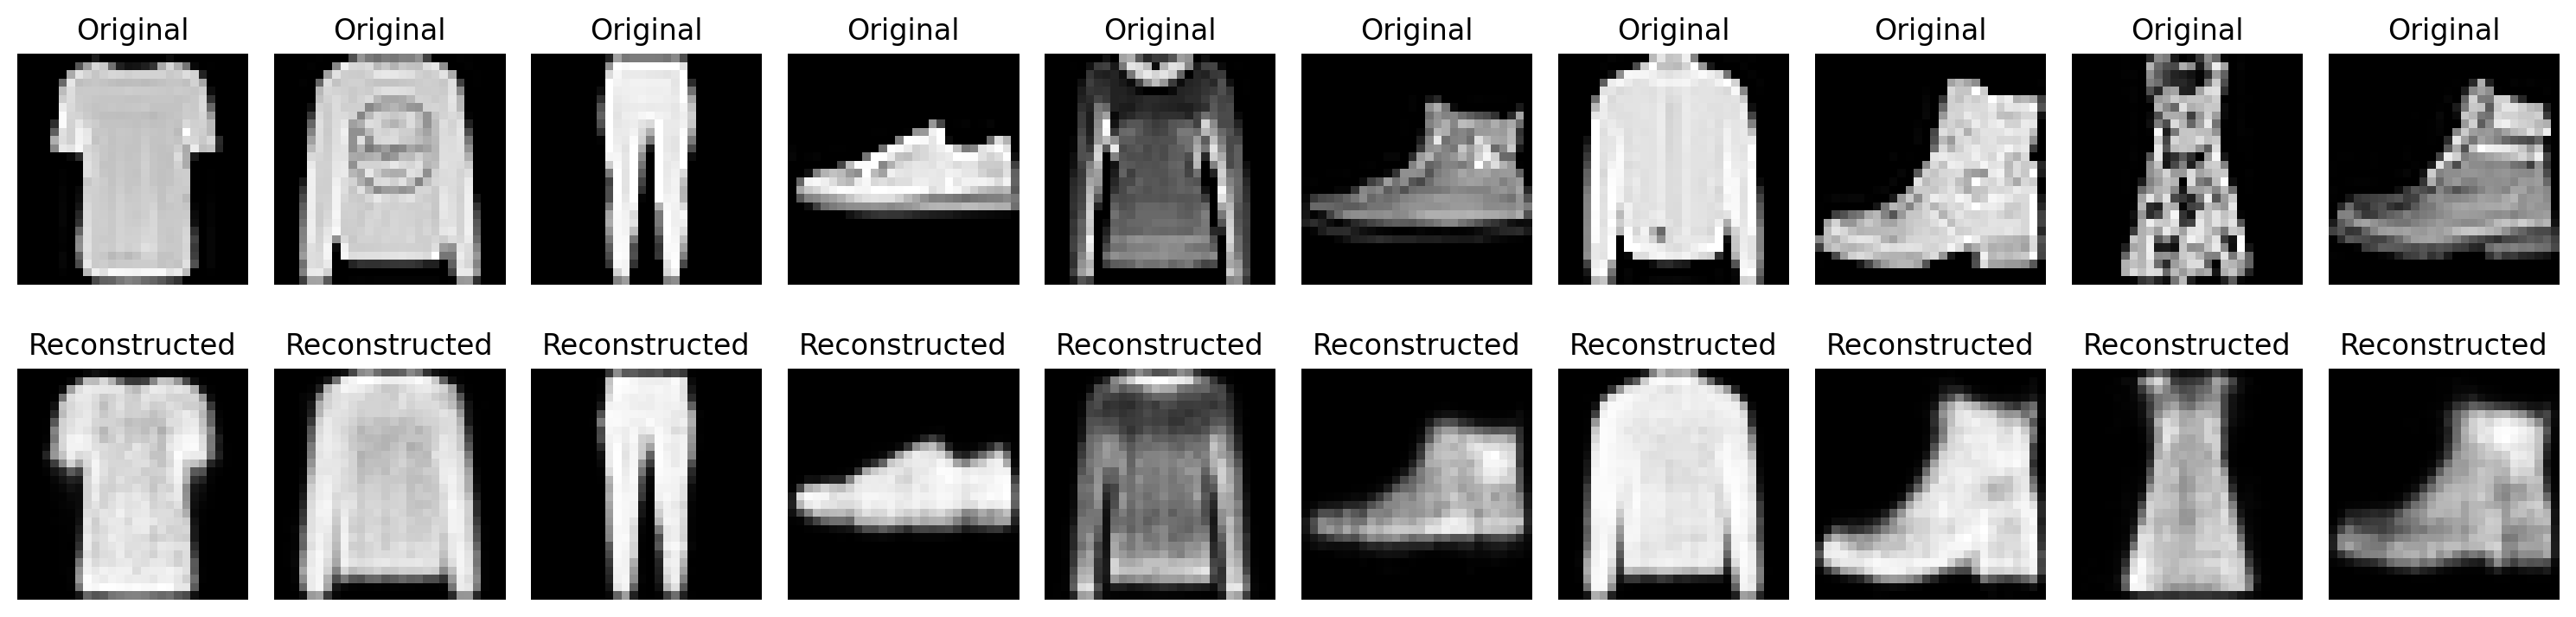

-----------------------------------------------------------------------------
------------- AUTOENCODER: 3 layers and 100 projected dimensions ---------
Epoch 0. Training loss: 0.10729559252186763. Validation loss: 0.07354055433831316
Epoch 1. Training loss: 0.06408067850861698. Validation loss: 0.05941347801621924
Epoch 2. Training loss: 0.05448869691463187. Validation loss: 0.05335435910110778
Epoch 3. Training loss: 0.04945566596738486. Validation loss: 0.04839543120024052
Epoch 4. Training loss: 0.04629736017986116. Validation loss: 0.04696823260251512


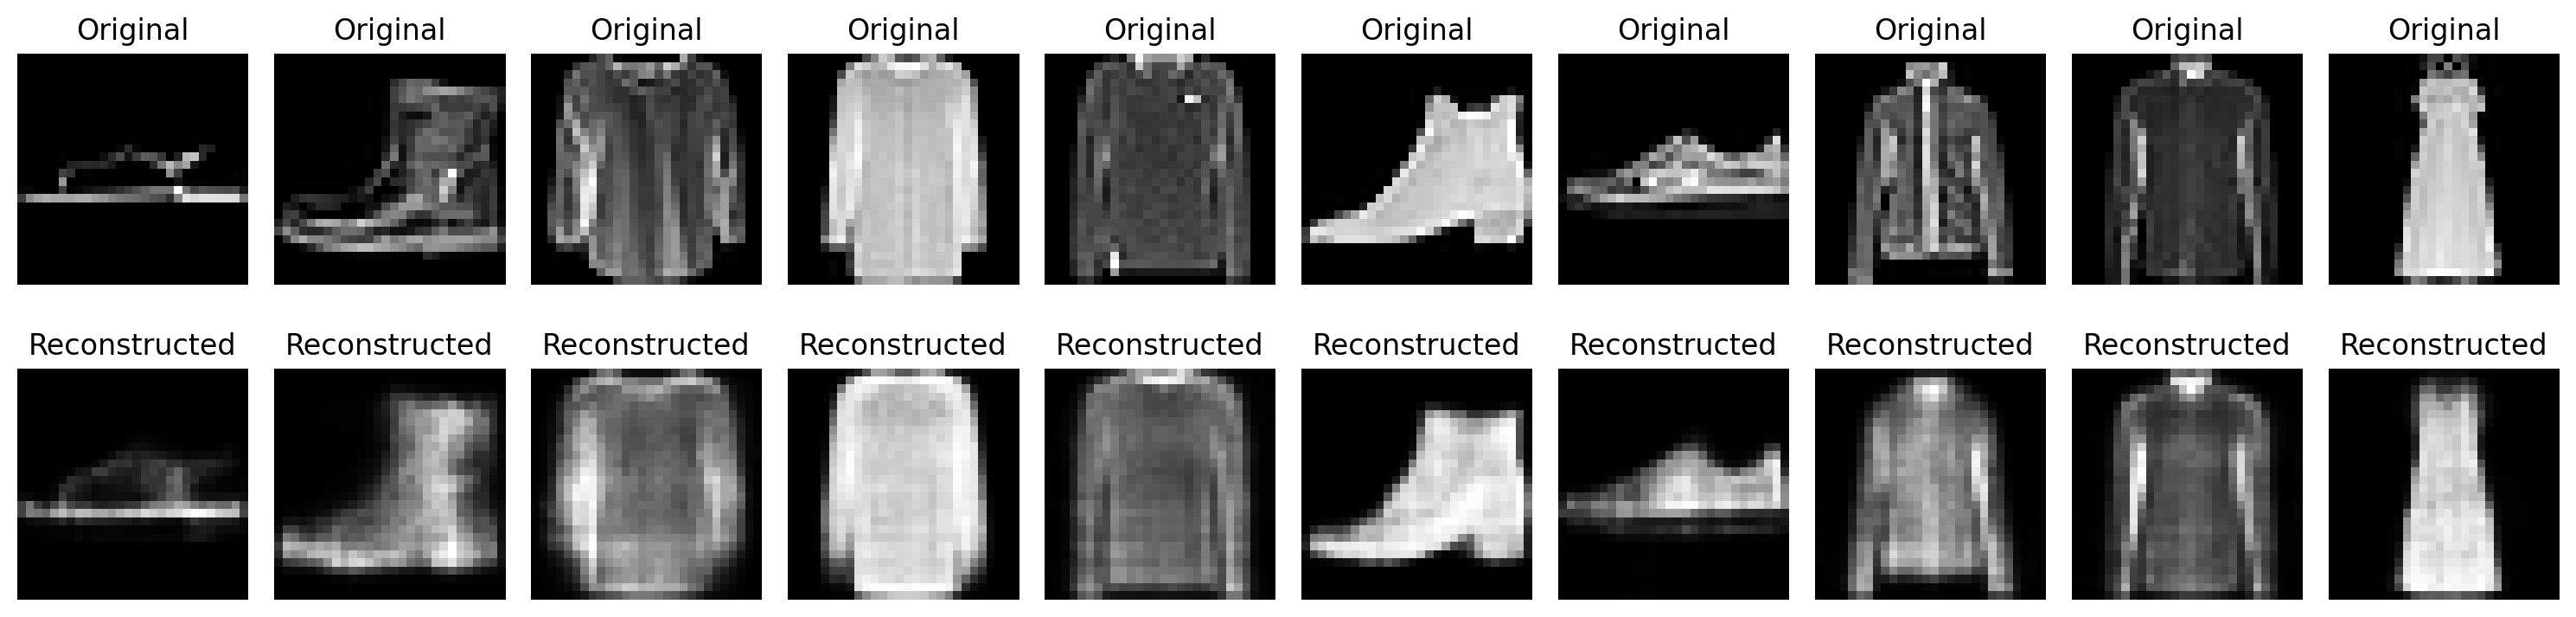

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 15 projected dimensions ---------
Epoch 0. Training loss: 0.15145663522310893. Validation loss: 0.10039983658080405
Epoch 1. Training loss: 0.08718143290818924. Validation loss: 0.08221975270103901
Epoch 2. Training loss: 0.07806908797515048. Validation loss: 0.07723773270845413
Epoch 3. Training loss: 0.0731385222223418. Validation loss: 0.07360694153194731
Epoch 4. Training loss: 0.07016362399074504. Validation loss: 0.06914481485777713


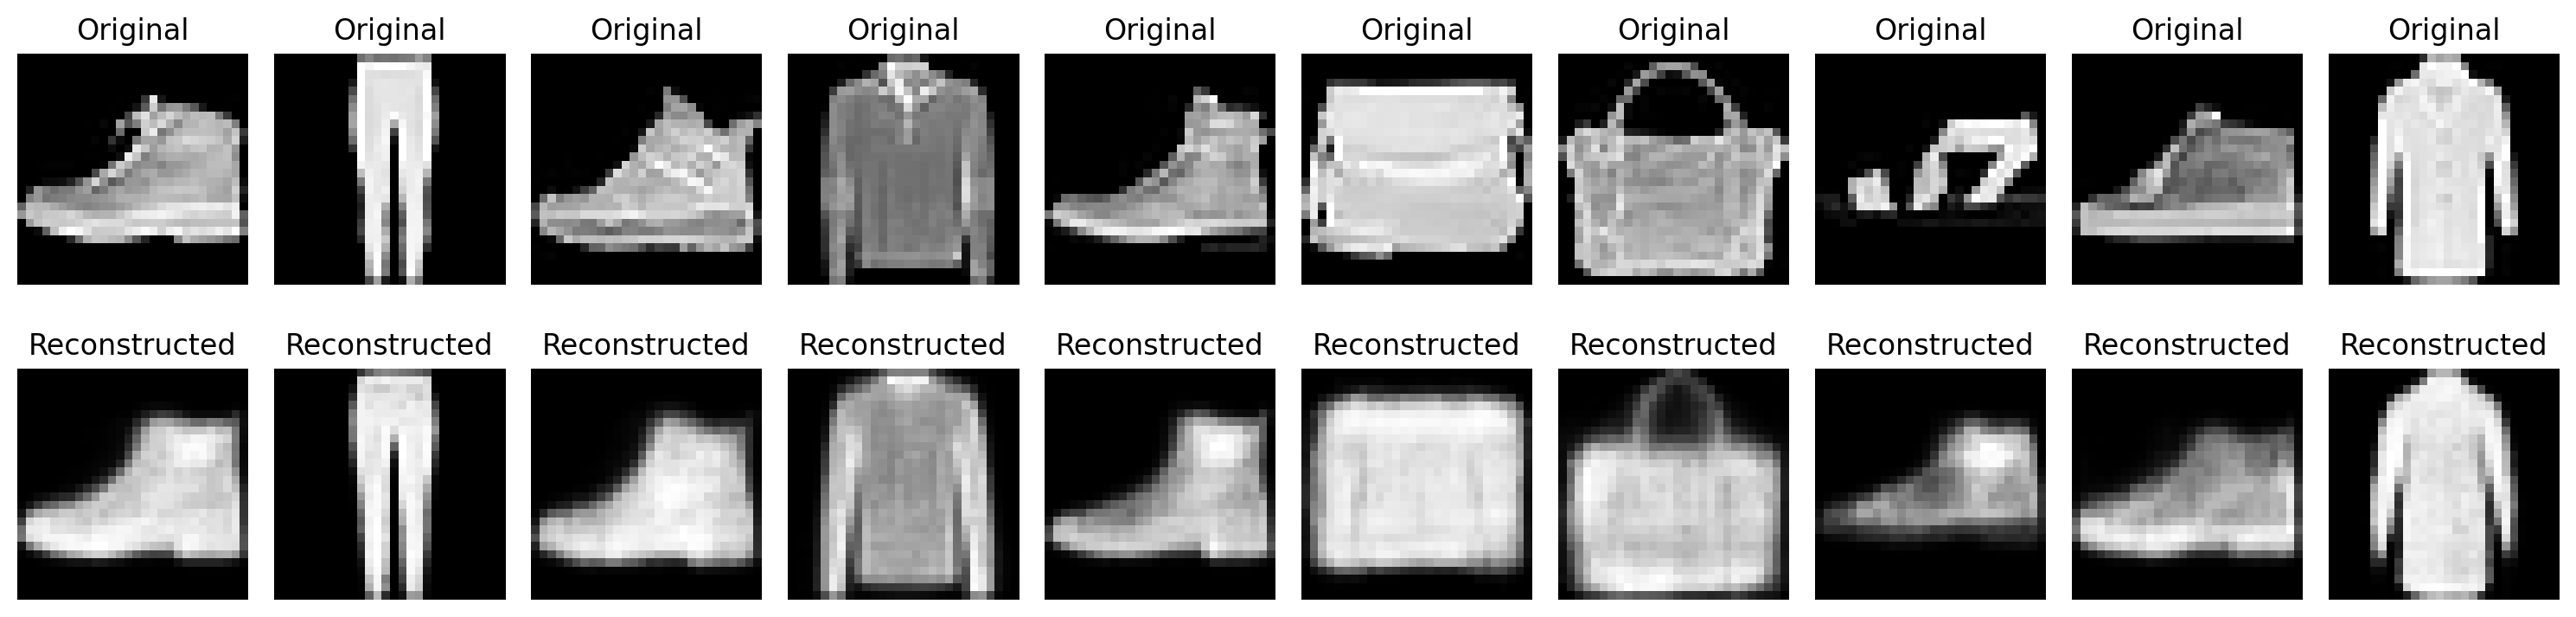

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 30 projected dimensions ---------
Epoch 0. Training loss: 0.150640829550949. Validation loss: 0.09583059872718568
Epoch 1. Training loss: 0.08822488908613609. Validation loss: 0.08406008811707193
Epoch 2. Training loss: 0.0796768063552339. Validation loss: 0.08044637235555242
Epoch 3. Training loss: 0.07586466451175511. Validation loss: 0.07563490717017904
Epoch 4. Training loss: 0.0728644069802778. Validation loss: 0.07113003871859389


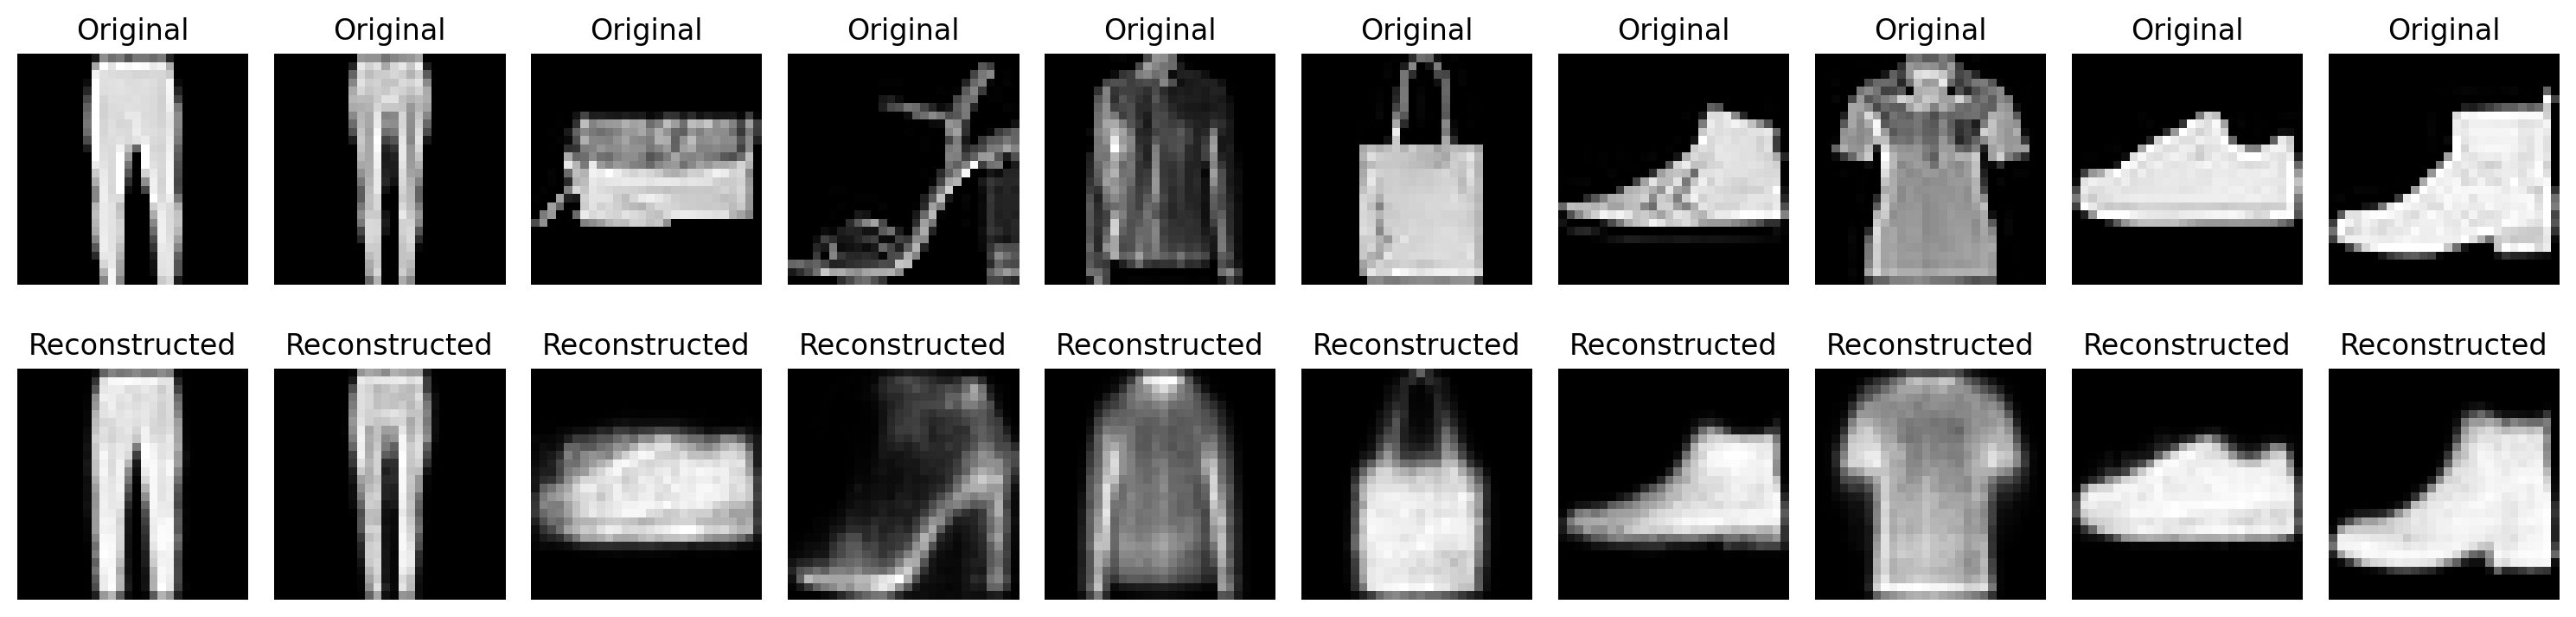

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 50 projected dimensions ---------
Epoch 0. Training loss: 0.1491471103667705. Validation loss: 0.09538784065145127
Epoch 1. Training loss: 0.08889929137446663. Validation loss: 0.08510497852842859
Epoch 2. Training loss: 0.08224618198900399. Validation loss: 0.08113546542664792
Epoch 3. Training loss: 0.07665340481749312. Validation loss: 0.07470454828853303
Epoch 4. Training loss: 0.07178572120293128. Validation loss: 0.07102391578732653


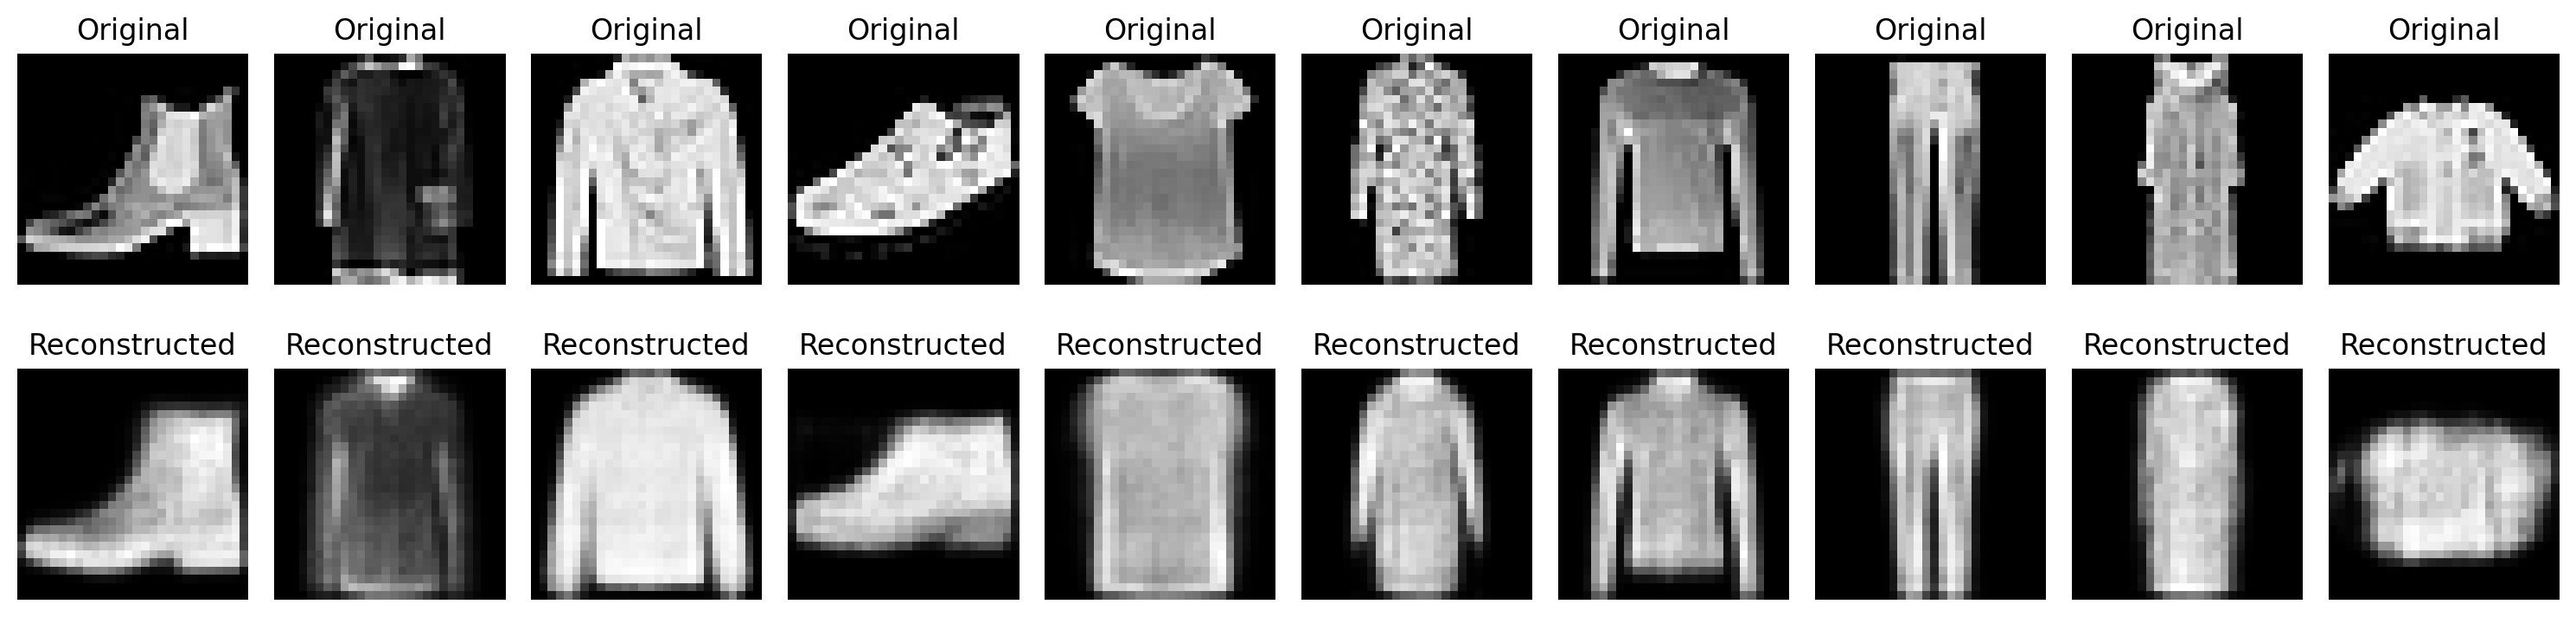

-----------------------------------------------------------------------------
------------- AUTOENCODER: 5 layers and 100 projected dimensions ---------
Epoch 0. Training loss: 0.14269818044902588. Validation loss: 0.09505387081744823
Epoch 1. Training loss: 0.08621893573383038. Validation loss: 0.08321202035914076
Epoch 2. Training loss: 0.08079410701016472. Validation loss: 0.07915469011727799
Epoch 3. Training loss: 0.077645660684952. Validation loss: 0.07807236282115287
Epoch 4. Training loss: 0.07356201841982758. Validation loss: 0.07671219059761535


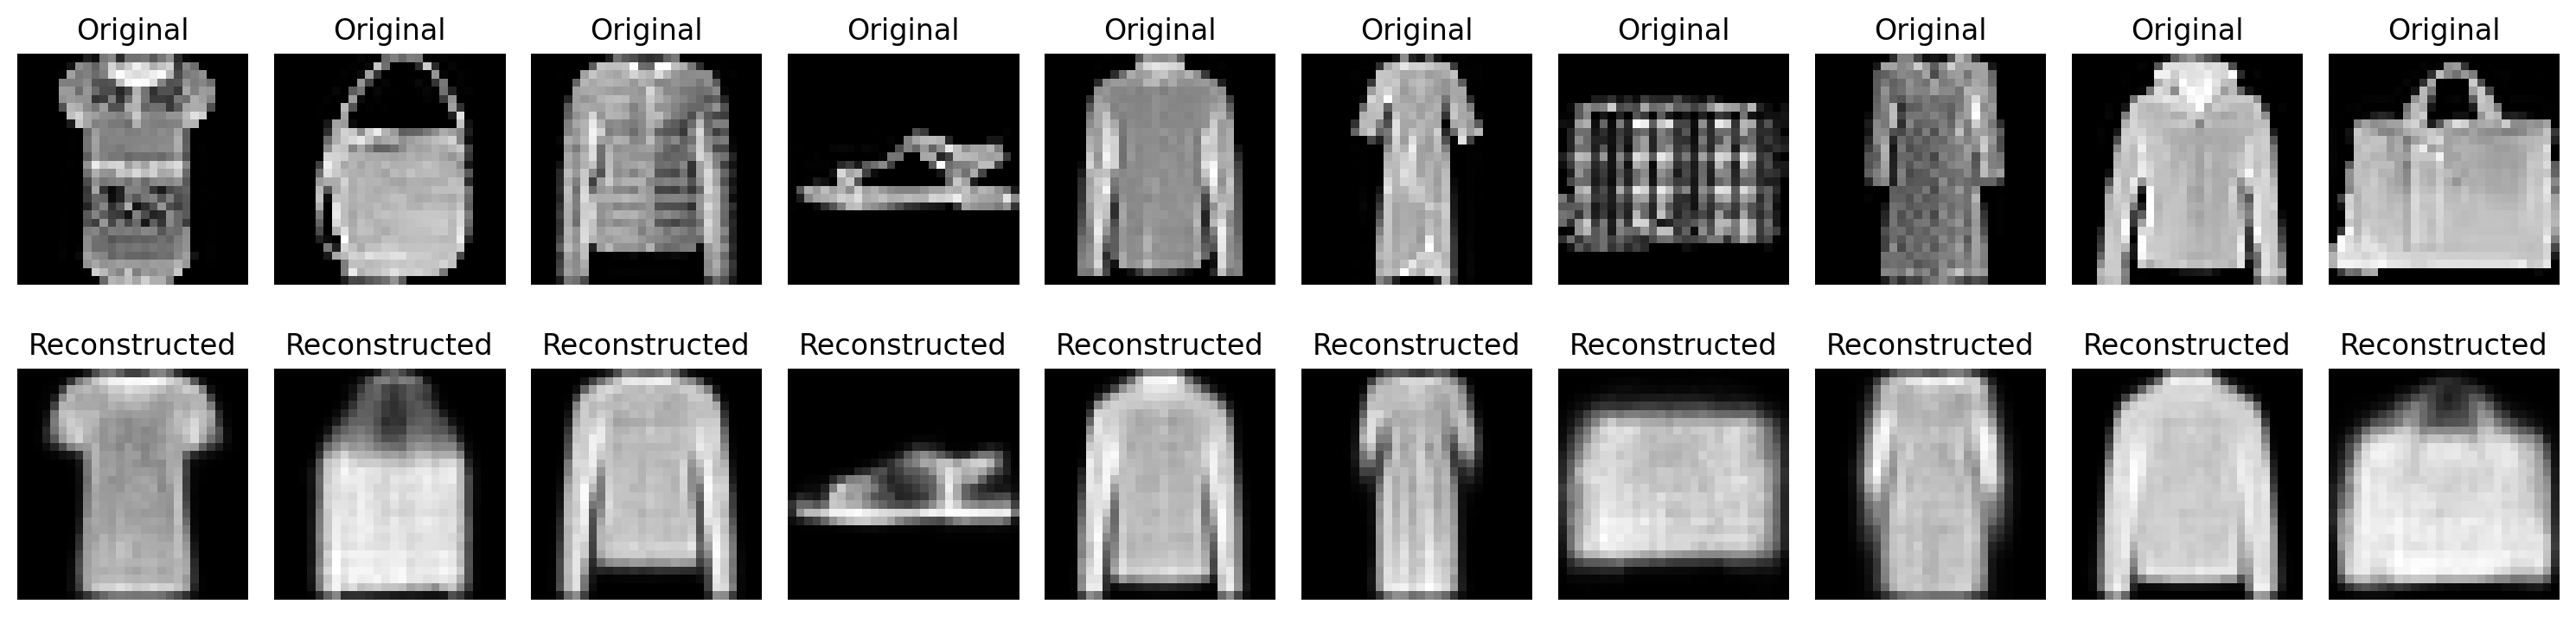

-----------------------------------------------------------------------------


In [ ]:
hyperparameter = {
    'layers': [3,5],
    'projected': [15,30,50,100]
}

hidden = {
    '3': {
        '15': [128, 32],
        '30': [128, 64],
        '50': [128, 96],
        '100': [256, 128]
    },
    '5': {
        '15': [256, 128, 64, 32],
        '30': [256, 128, 96, 64],
        '50': [256, 128, 96, 64],
        '100': [512, 256, 192, 128]
    }
}

results_train = {}
results_valid = {}

for i in hyperparameter['layers']:
  for j in hyperparameter['projected']:
    print(f'------------- AUTOENCODER: {i} layers and {j} projected dimensions ---------')
    autoencoder =  Autoencoder_extended(dimx=784, hidden=hidden[str(i)][str(j)], projected=j, layers=i, epochs=5, lr=1e-3)
    autoencoder.trainloop(trainloader, validloader)
    autoencoder.plot_reconstructions(testloader)
    if str(i) not in results_train:
      results_train[str(i)] = {}
    results_train[str(i)][str(j)] = autoencoder.loss_during_training
    if str(i) not in results_valid:
      results_valid[str(i)] = {}
    results_valid[str(i)][str(j)] = autoencoder.valid_loss_during_training
    print(f'-----------------------------------------------------------------------------')


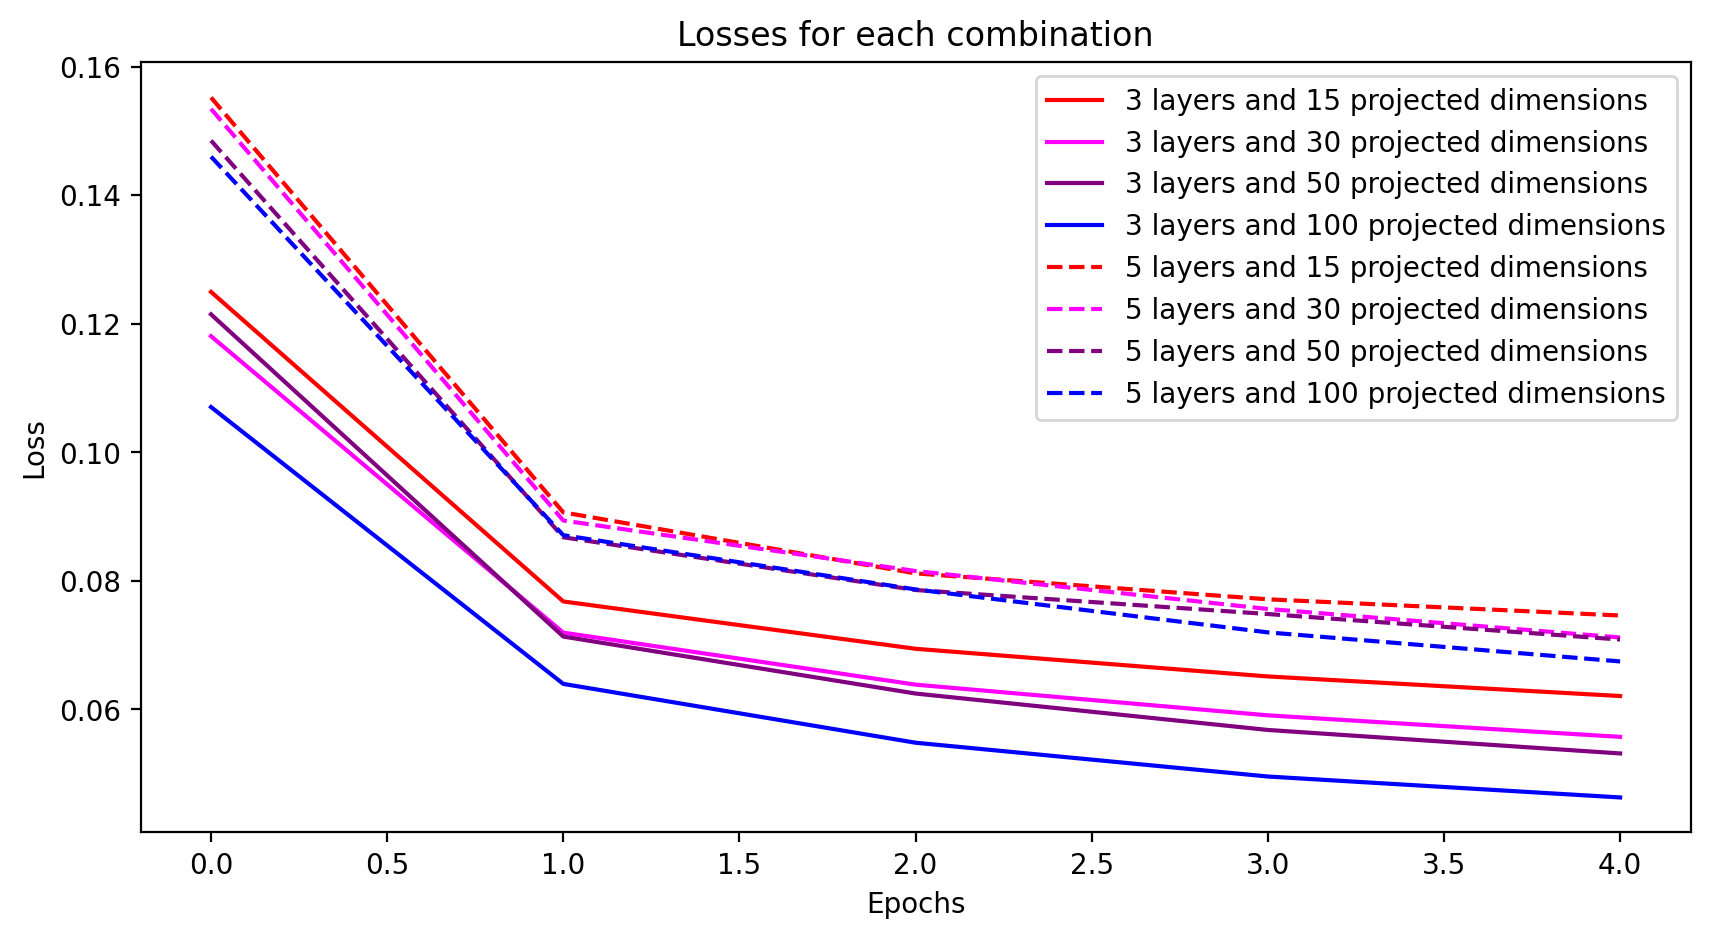

In [ ]:
plt.figure(figsize=(10,5))
colors = ['red', 'magenta', 'purple', 'blue']
plt.gca().set_prop_cycle(color=colors)
for layer, projected_dict in results_train.items():
  for projected, array in projected_dict.items():
    if layer == '3':
      plt.plot(array, label=f'{layer} layers and {projected} projected dimensions')
    else:
      plt.plot(array, label=f'{layer} layers and {projected} projected dimensions', linestyle = '--')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses for each combination')

# Show plot
plt.show()

#### 2.2.3. Train selected model

Epoch 0. Training loss: 0.1044247736519372. Validation loss: 0.07216876125399102
Epoch 1. Training loss: 0.06338871151886204. Validation loss: 0.0589520403837904
Epoch 2. Training loss: 0.054557793017011136. Validation loss: 0.053388361490153254
Epoch 3. Training loss: 0.04944100947415626. Validation loss: 0.04901179988333519
Epoch 4. Training loss: 0.04588950821198523. Validation loss: 0.0466602392415417
Epoch 5. Training loss: 0.04334040518998253. Validation loss: 0.0443825272010996
Epoch 6. Training loss: 0.041386143648361955. Validation loss: 0.04359350957451983
Epoch 7. Training loss: 0.039827514400134205. Validation loss: 0.04199959727677893
Epoch 8. Training loss: 0.03860245599273846. Validation loss: 0.04273916638277946
Epoch 9. Training loss: 0.037588603715200654. Validation loss: 0.03924070602243251
Epoch 10. Training loss: 0.036735789823896164. Validation loss: 0.038380075697886186
Epoch 11. Training loss: 0.036019715557234704. Validation loss: 0.03684748047368323
Epoch 12. 

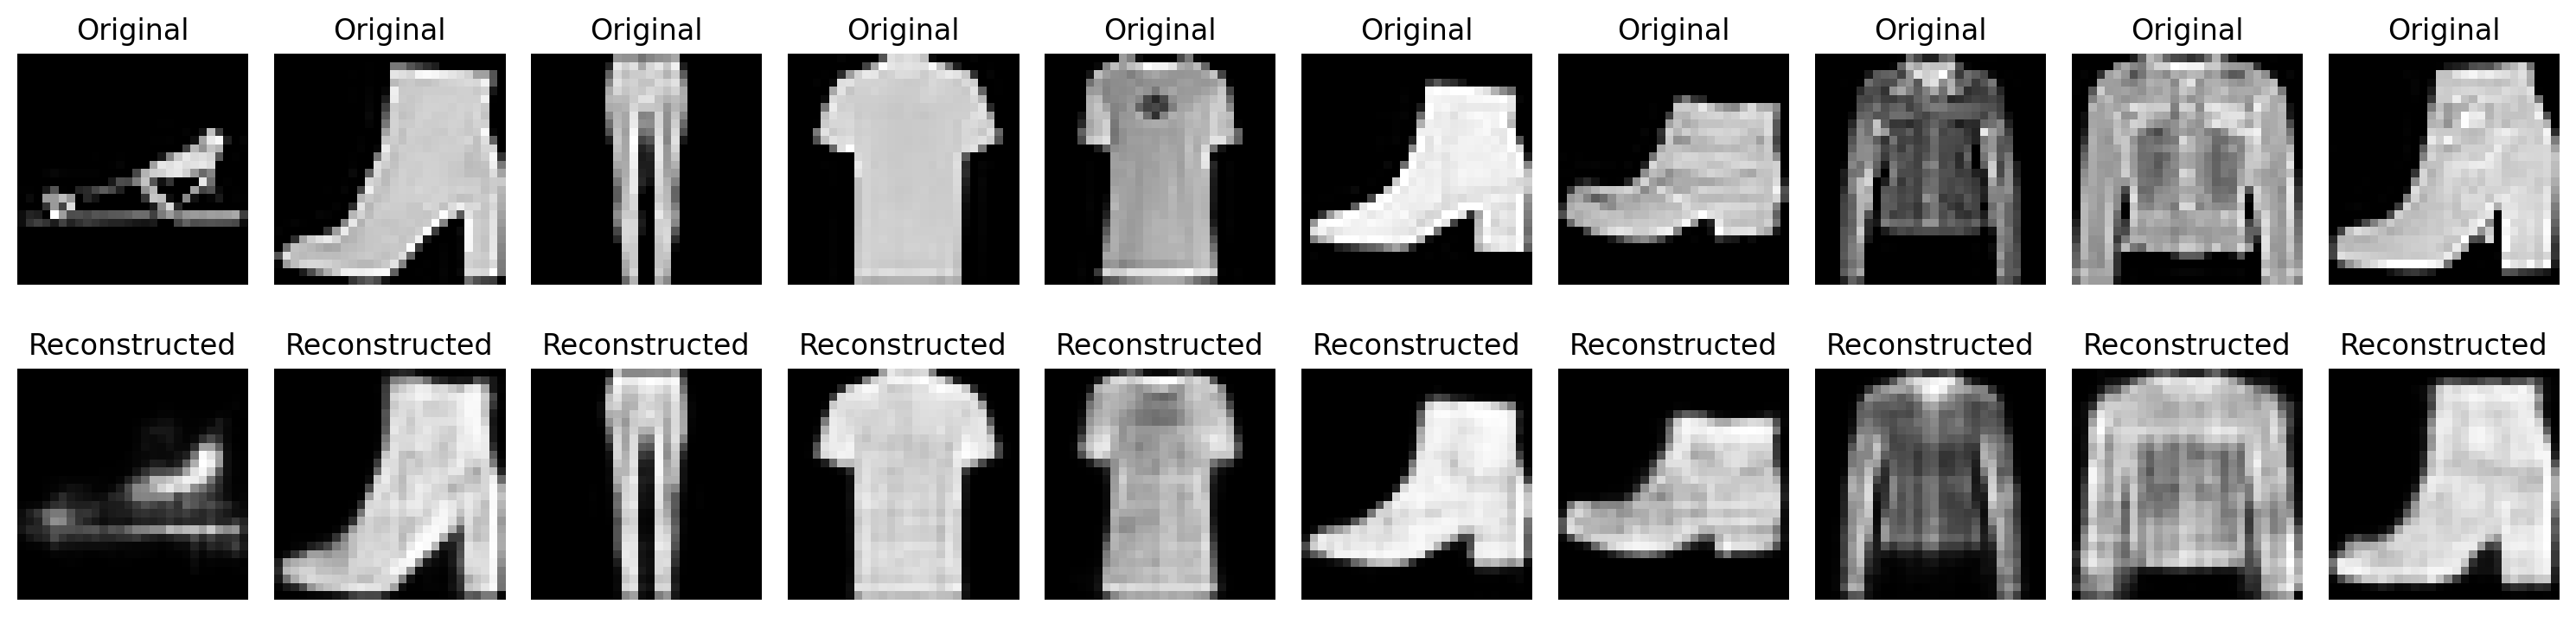

Average reconstrucion loss: 0.03130065069599136


In [ ]:
autoencoder =  Autoencoder_extended(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=30, lr=1e-3)
autoencoder.trainloop(trainloader, validloader)
autoencoder.plot_reconstructions(testloader)
avg_loss = autoencoder.testloop(testloader)

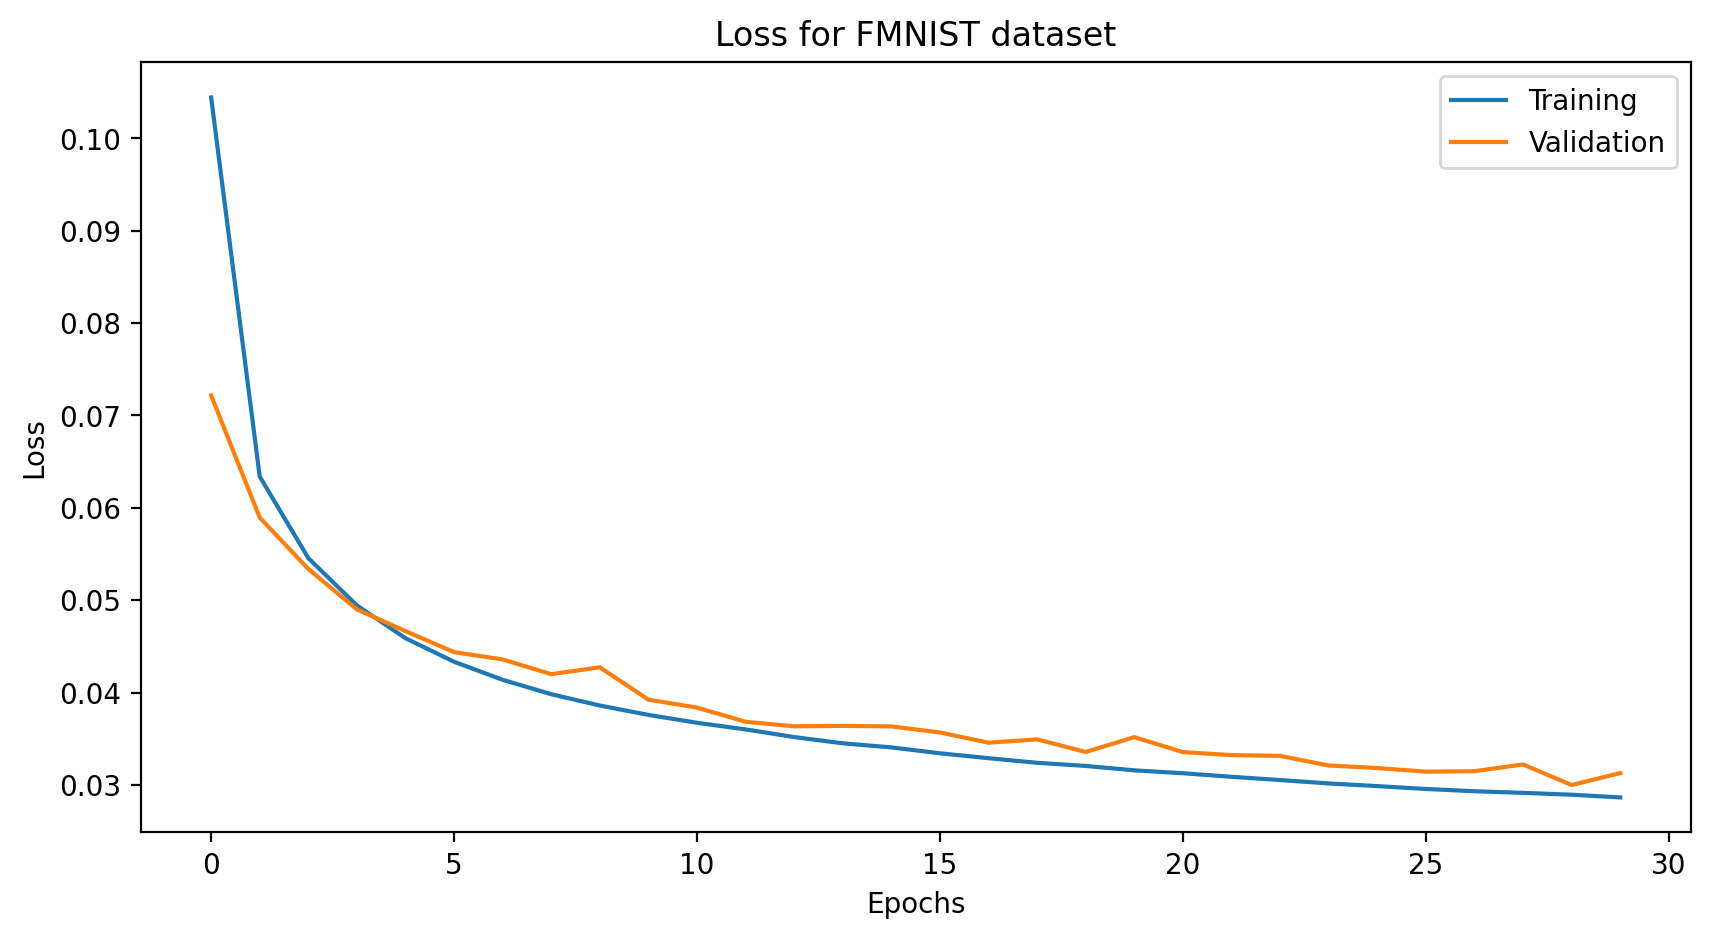

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(autoencoder.loss_during_training, label='Training')
plt.plot(autoencoder.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for FMNIST dataset')

plt.show()

## 3. Implementing regularization techniques

### Lasso regularizarion

In [ ]:
class Autoencoder_extended_regularized(Autoencoder_extended):

    def __init__(self, dimx, hidden, projected, layers, epochs=30, lr=0.01, dropout_prob=0, l1_lambda=0):
        super().__init__(dimx, hidden, projected, layers, epochs, lr)

        self.dropout_prob = dropout_prob
        self.l1_lambda = l1_lambda


    def trainloop(self, trainloader, validloader):
        # Loop through training epochs
        for e in range(self.epochs):
            running_loss = 0.

            # Iterate through training data batches
            for (inputs, _) in trainloader:
                inputs = inputs.reshape(inputs.shape[0], -1)
                out = self.forward(inputs)
                mse = self.criterion(out, inputs)

                l1_reg = 0
                # Iterate through parameters of the second-to-last encoder layer
                for param in self.encoder[-2].parameters():
                    l1_reg += torch.norm(param, p=1)

                # Combine MSE loss with L1 regularization term weighted by lambda
                loss = mse + self.l1_lambda * l1_reg

                running_loss += loss.item()

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            with torch.no_grad():
                running_loss = 0.
                for (inputs, _) in validloader:
                    inputs = inputs.reshape(inputs.shape[0], -1)
                    out = self.forward(inputs)
                    loss = self.criterion(out, inputs)
                    running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss / len(validloader))

            if (e % 1 == 0):
                print(f'Epoch {e}. Training loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}')


------------- AUTOENCODER: $lambda$ = 1e-06 -----------------------------------
Epoch 0. Training loss: 0.1494642912029204. Validation loss: 0.0893290158598981
Epoch 1. Training loss: 0.07276177570879967. Validation loss: 0.06614745525603599
Epoch 2. Training loss: 0.0574429847871546. Validation loss: 0.055308950042470974
Epoch 3. Training loss: 0.0499139469307424. Validation loss: 0.048924270224698044
Epoch 4. Training loss: 0.0445877302554436. Validation loss: 0.044998874975011705
Epoch 5. Training loss: 0.04099539128947072. Validation loss: 0.0423642763590559
Epoch 6. Training loss: 0.038203975405353544. Validation loss: 0.03893961565608674
Epoch 7. Training loss: 0.03635698321158998. Validation loss: 0.03726304398572191
Epoch 8. Training loss: 0.034792760058983484. Validation loss: 0.036376940950434256
Epoch 9. Training loss: 0.03344411488400179. Validation loss: 0.03640227896418977


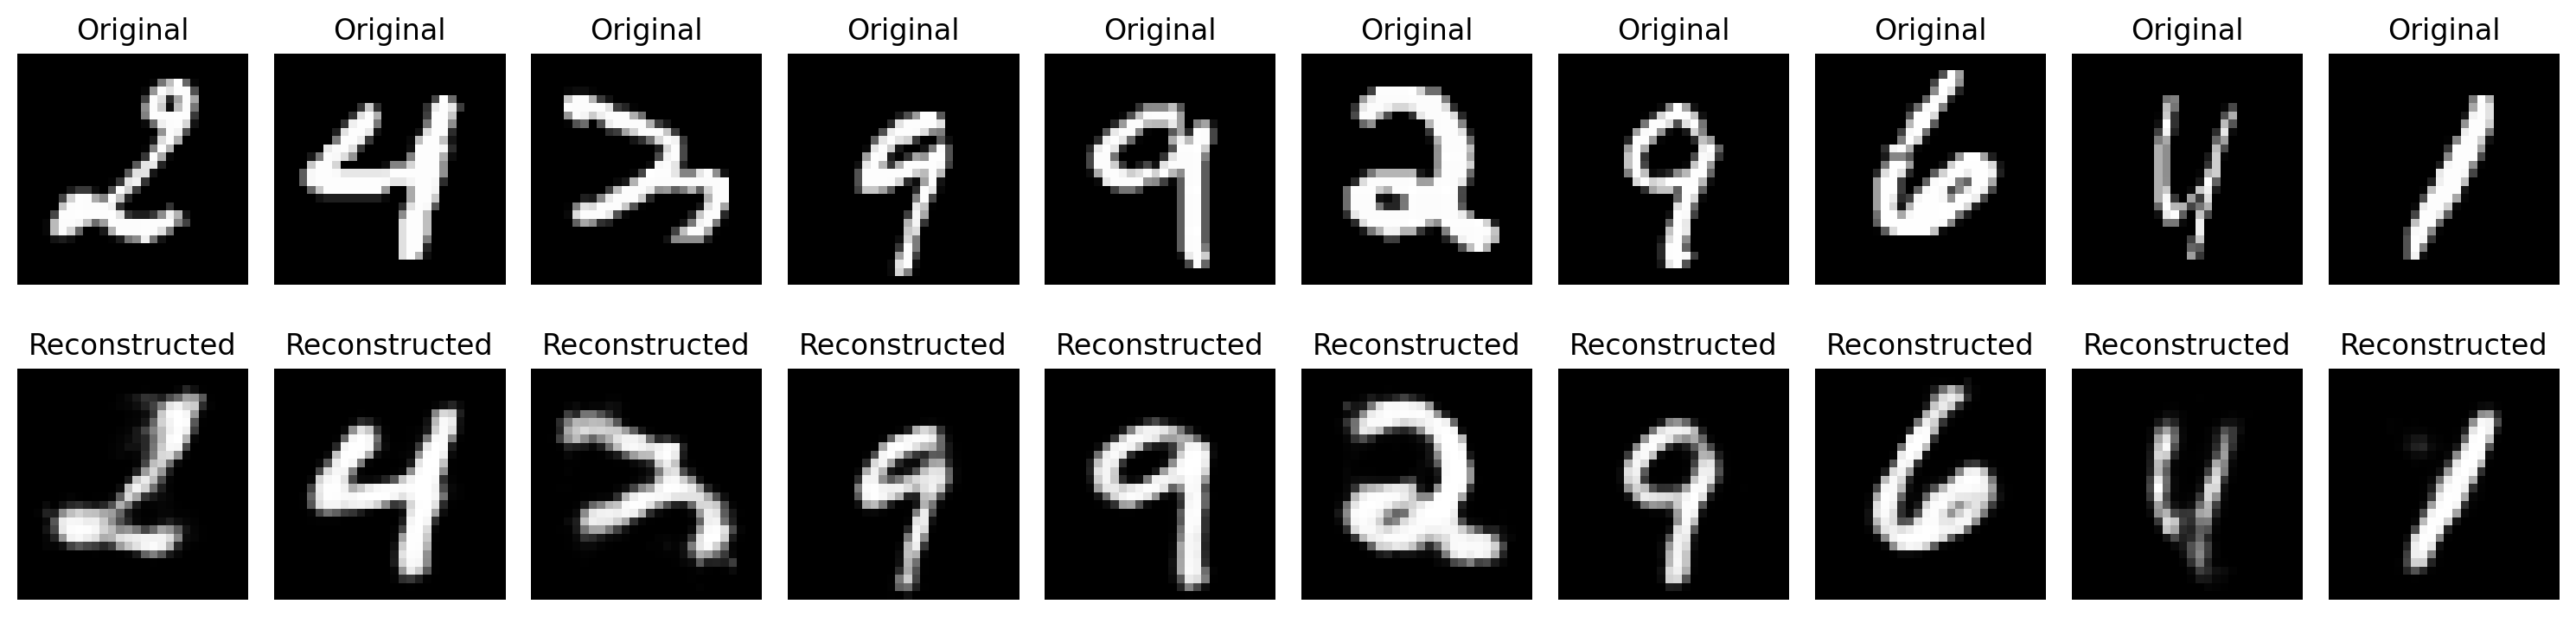


-----------------------------------------------------------------------------
------------- AUTOENCODER: $lambda$ = 1e-05 -----------------------------------
Epoch 0. Training loss: 0.15395257162692194. Validation loss: 0.09680496162556587
Epoch 1. Training loss: 0.07879565633431246. Validation loss: 0.07217873065395558
Epoch 2. Training loss: 0.061970257189717486. Validation loss: 0.05615614334002454
Epoch 3. Training loss: 0.05277566317024387. Validation loss: 0.0521330641780762
Epoch 4. Training loss: 0.047122012368742035. Validation loss: 0.04814207314493808
Epoch 5. Training loss: 0.0430542740769769. Validation loss: 0.04350639228174027
Epoch 6. Training loss: 0.04011046043226749. Validation loss: 0.04035322084388834
Epoch 7. Training loss: 0.03793033940548247. Validation loss: 0.03847731464403741
Epoch 8. Training loss: 0.036115172604860905. Validation loss: 0.03775447275727353
Epoch 9. Training loss: 0.034730120522329926. Validation loss: 0.03572831103934886


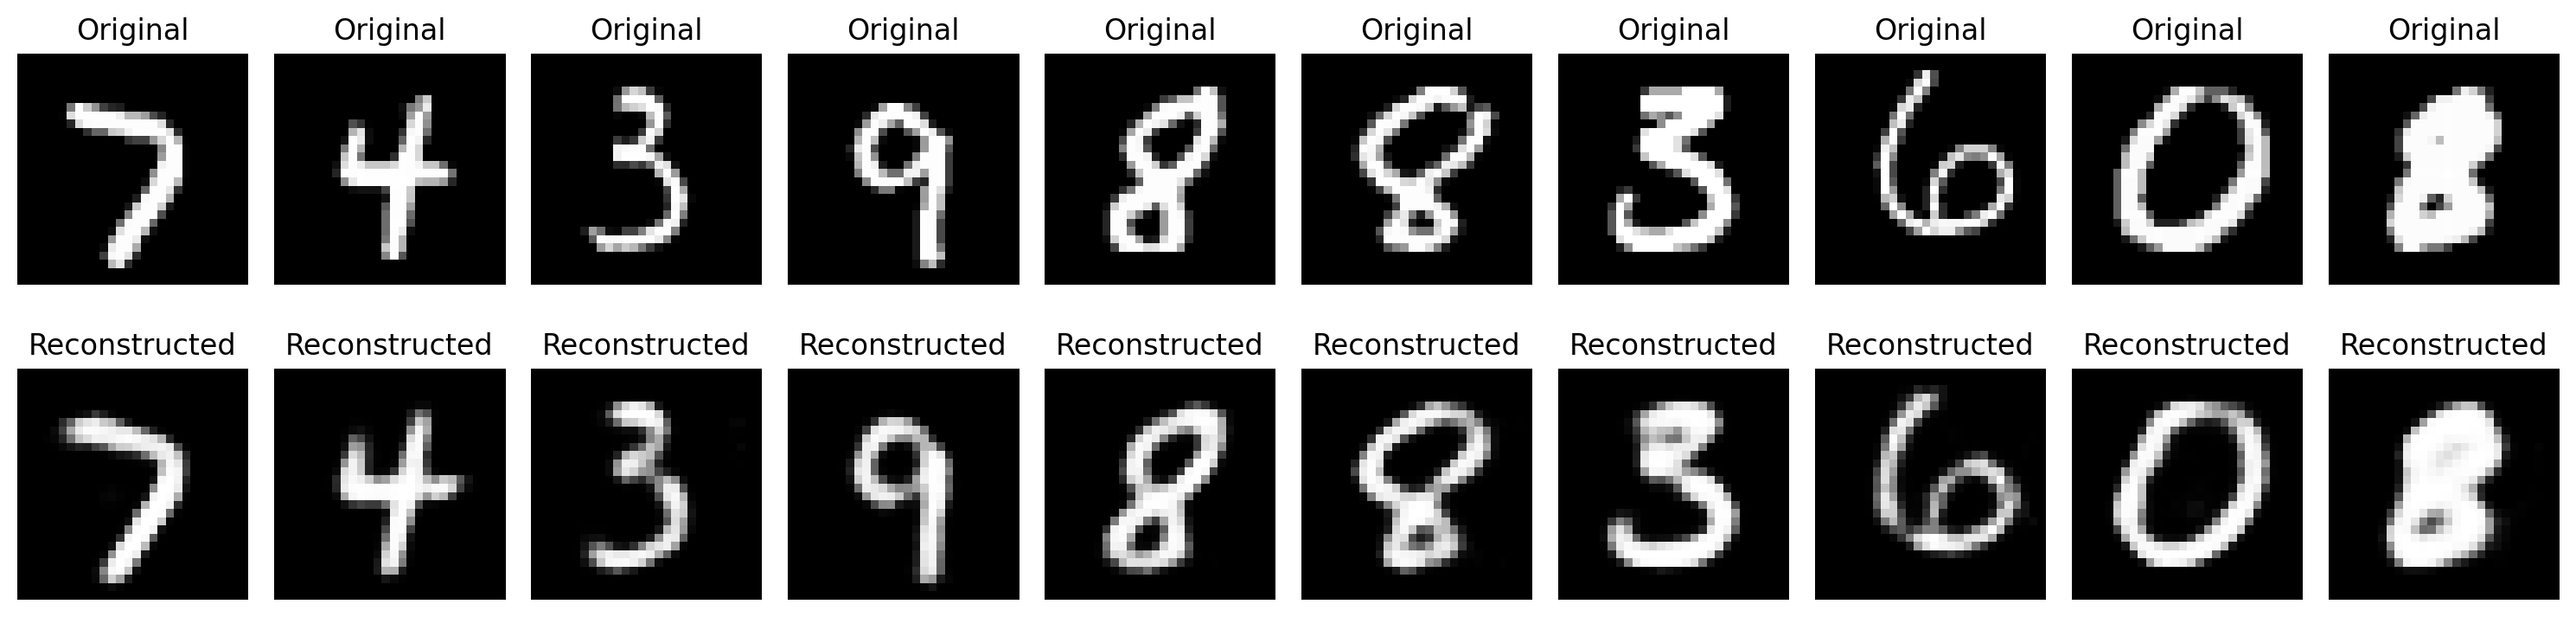


-----------------------------------------------------------------------------
------------- AUTOENCODER: $lambda$ = 0.0001 -----------------------------------
Epoch 0. Training loss: 0.16885943997609007. Validation loss: 0.10386056865149355
Epoch 1. Training loss: 0.09381211137356744. Validation loss: 0.0804057056282429
Epoch 2. Training loss: 0.07586835221048784. Validation loss: 0.06893607176681782
Epoch 3. Training loss: 0.0673290342039598. Validation loss: 0.06412749357045965
Epoch 4. Training loss: 0.06109069742325863. Validation loss: 0.05624917956425789
Epoch 5. Training loss: 0.05587695935338905. Validation loss: 0.05399994168509828
Epoch 6. Training loss: 0.05235674447612837. Validation loss: 0.052496842818057284
Epoch 7. Training loss: 0.0494219363370741. Validation loss: 0.048920869652895216
Epoch 8. Training loss: 0.04687875856391408. Validation loss: 0.04641150966920751
Epoch 9. Training loss: 0.04475584043062885. Validation loss: 0.043657401711382764


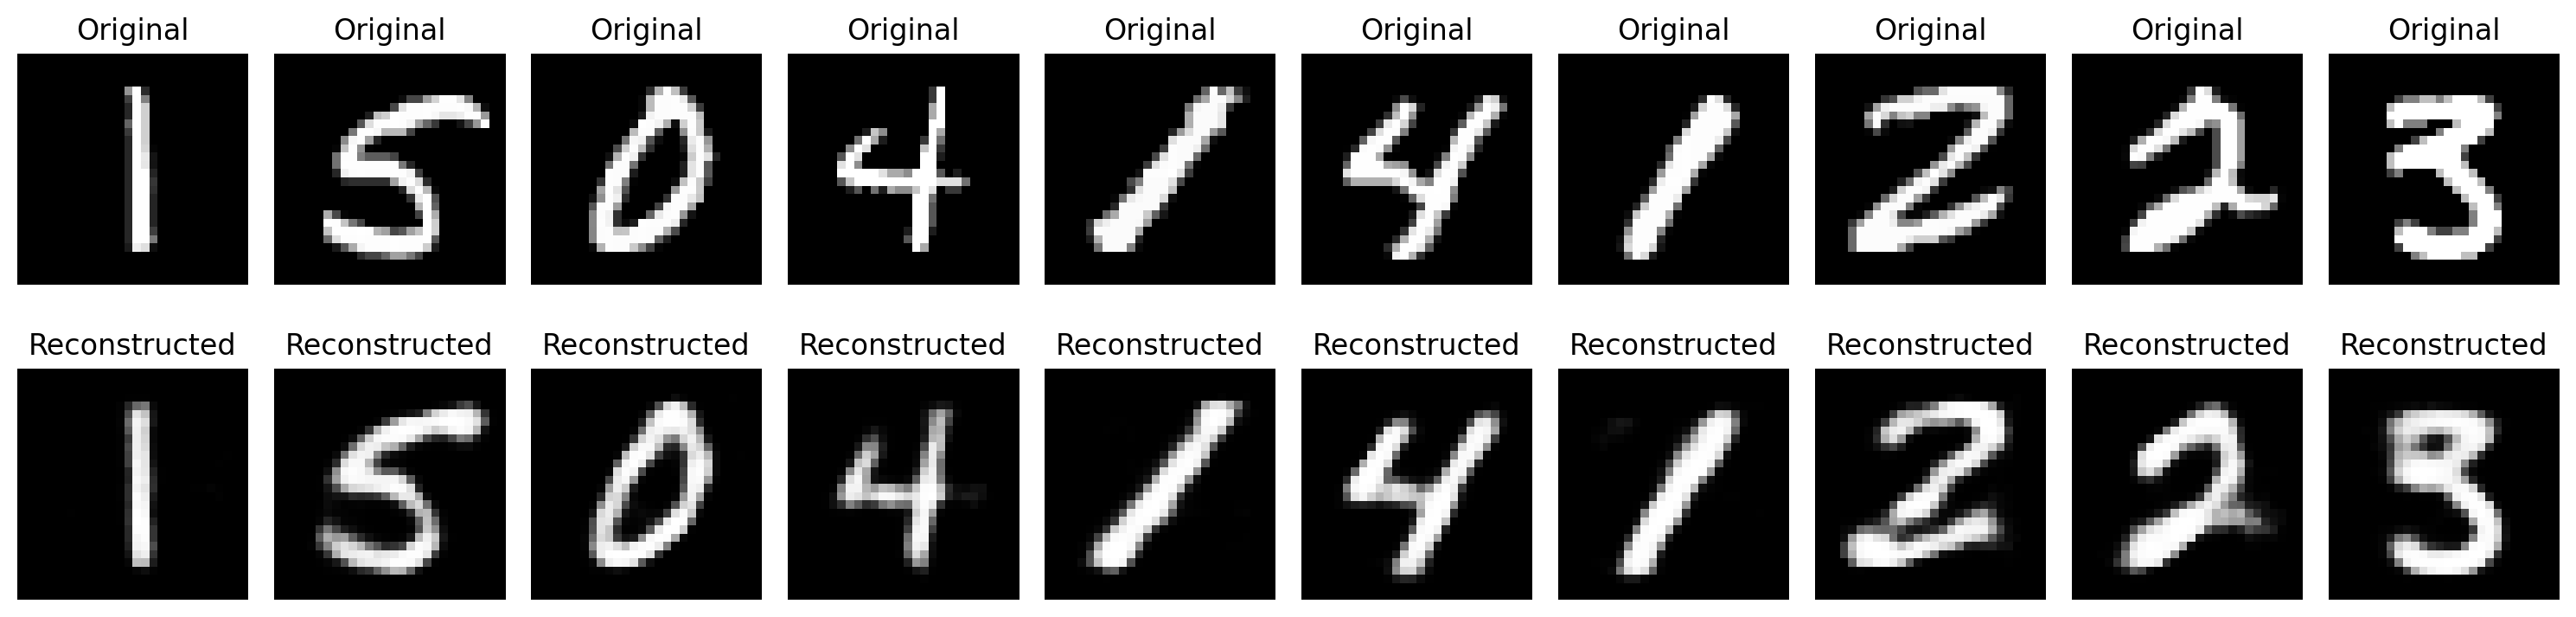


-----------------------------------------------------------------------------
------------- AUTOENCODER: $lambda$ = 0.001 -----------------------------------
Epoch 0. Training loss: 0.2304092429218475. Validation loss: 0.14188932491109726
Epoch 1. Training loss: 0.13171435488303276. Validation loss: 0.11793091842468749
Epoch 2. Training loss: 0.11274097907483917. Validation loss: 0.10404438791756934
Epoch 3. Training loss: 0.1000042044007304. Validation loss: 0.0912764477285933
Epoch 4. Training loss: 0.08986469376197254. Validation loss: 0.08298070383198718
Epoch 5. Training loss: 0.08289105056742714. Validation loss: 0.07964470396016507
Epoch 6. Training loss: 0.07852919902440837. Validation loss: 0.07588467293597283
Epoch 7. Training loss: 0.0755430119514296. Validation loss: 0.07304250780255236
Epoch 8. Training loss: 0.07316517327192494. Validation loss: 0.07164097743782591
Epoch 9. Training loss: 0.07125284685753286. Validation loss: 0.06975260394367766


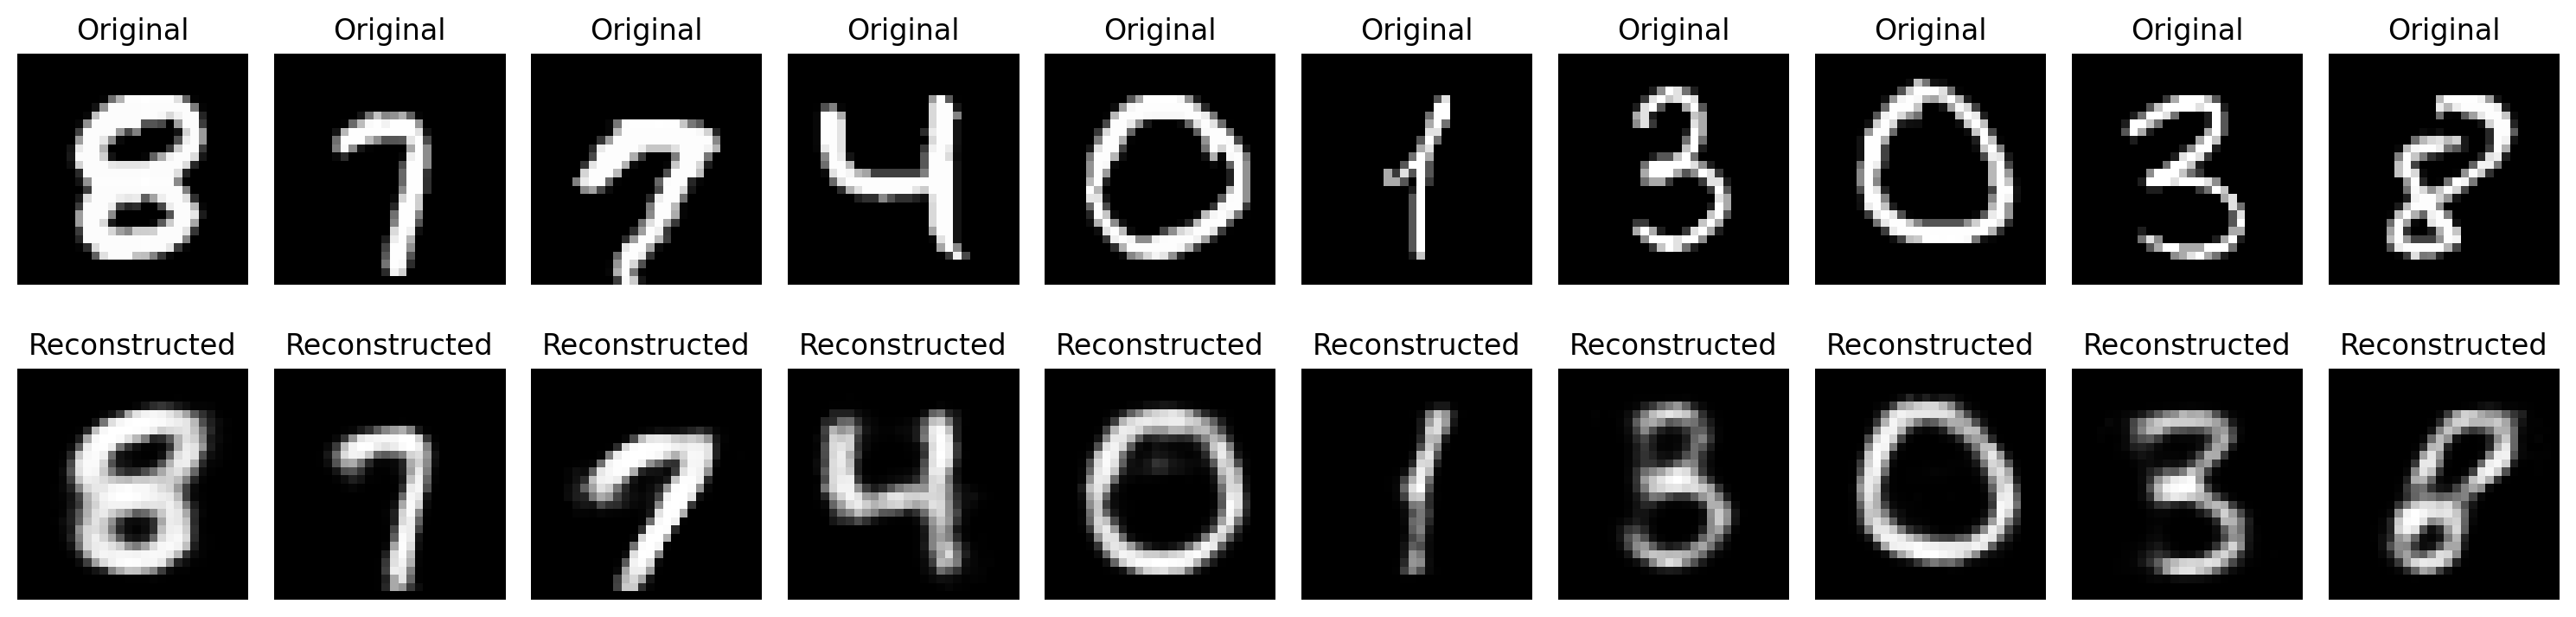


-----------------------------------------------------------------------------
------------- AUTOENCODER: $lambda$ = 0.01 -----------------------------------
Epoch 0. Training loss: 0.5031300812790339. Validation loss: 0.19409716801440463
Epoch 1. Training loss: 0.19790497170337898. Validation loss: 0.1744909921859173
Epoch 2. Training loss: 0.18229367564940316. Validation loss: 0.162360772680729
Epoch 3. Training loss: 0.17557468491775746. Validation loss: 0.15702277922883948
Epoch 4. Training loss: 0.17186286859214306. Validation loss: 0.155638391350178
Epoch 5. Training loss: 0.16951256105676293. Validation loss: 0.15320747577129526
Epoch 6. Training loss: 0.1674960090524771. Validation loss: 0.15039738752740495
Epoch 7. Training loss: 0.16572382813319564. Validation loss: 0.14920476567237936
Epoch 8. Training loss: 0.1642099994404072. Validation loss: 0.1490377610668223
Epoch 9. Training loss: 0.162815420020541. Validation loss: 0.14635992417944238


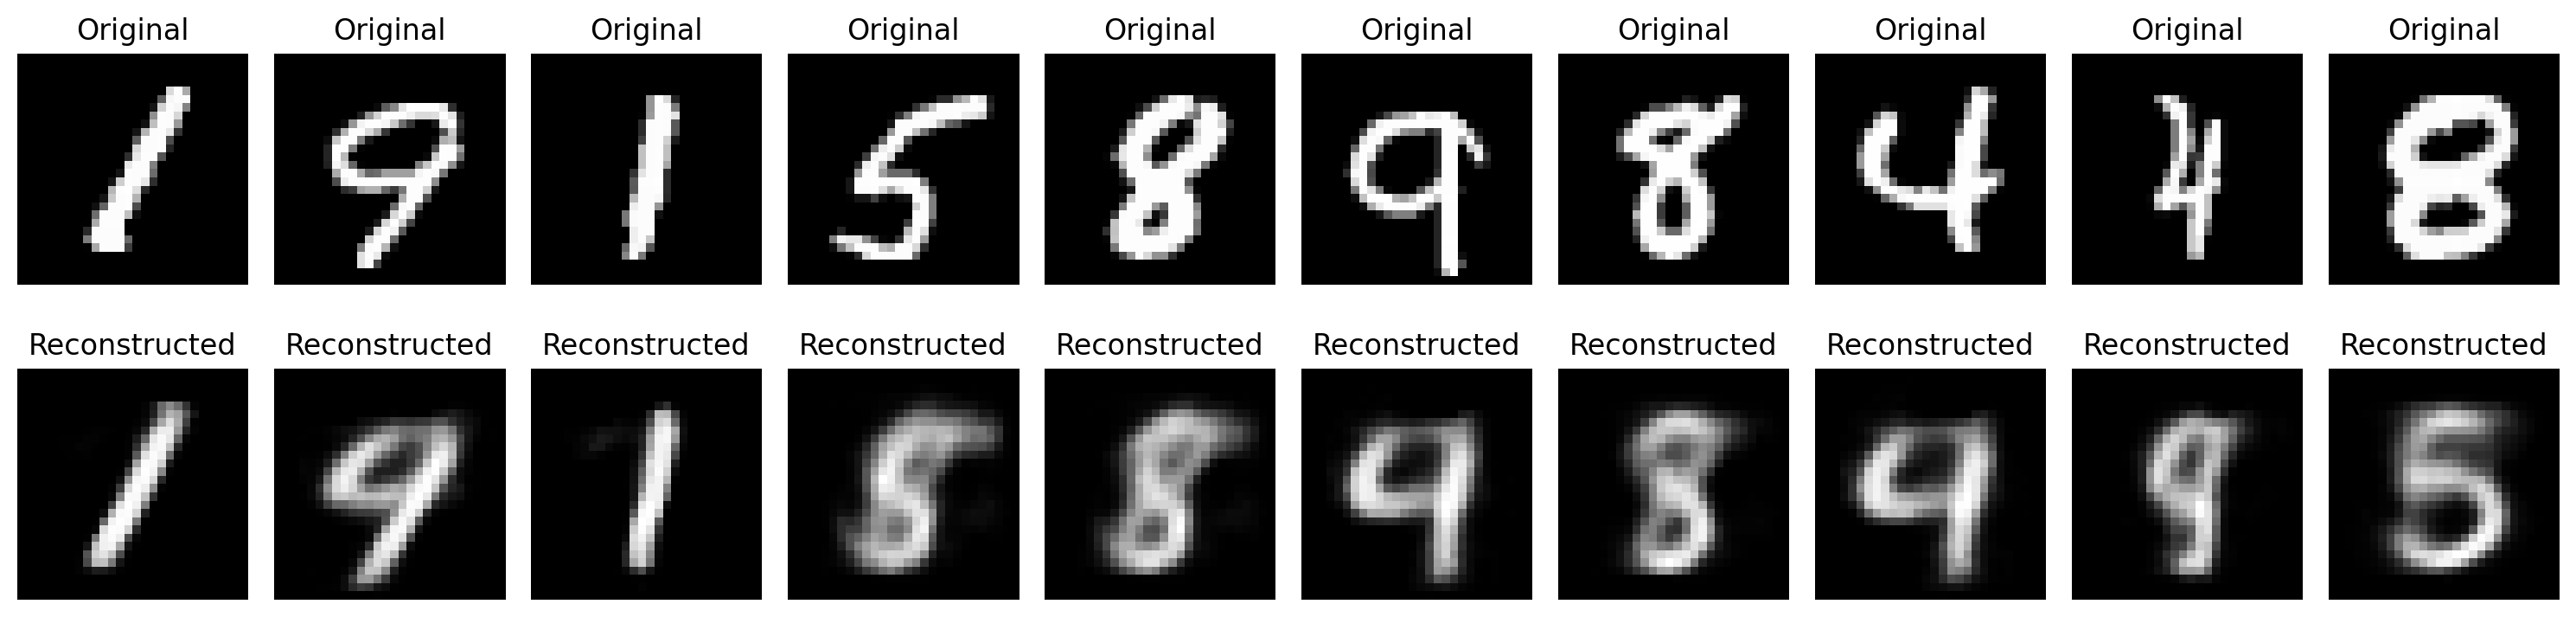


-----------------------------------------------------------------------------


In [ ]:
lambdas = np.geomspace(1e-6, 1e-2, 5)

results_train_lambda = {}
results_valid_lambda = {}

for l in lambdas:
  autoencoder =  Autoencoder_extended_regularized(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=10, lr=1e-3, l1_lambda=l)
  print(f'------------- AUTOENCODER: $lambda$ = {l} -----------------------------------')
  autoencoder.trainloop(trainloader, validloader)
  autoencoder.plot_reconstructions(testloader)
  results_train_lambda[str(l)] = autoencoder.loss_during_training
  results_valid_lambda[str(l)] = autoencoder.valid_loss_during_training
  print()
  print(f'-----------------------------------------------------------------------------')

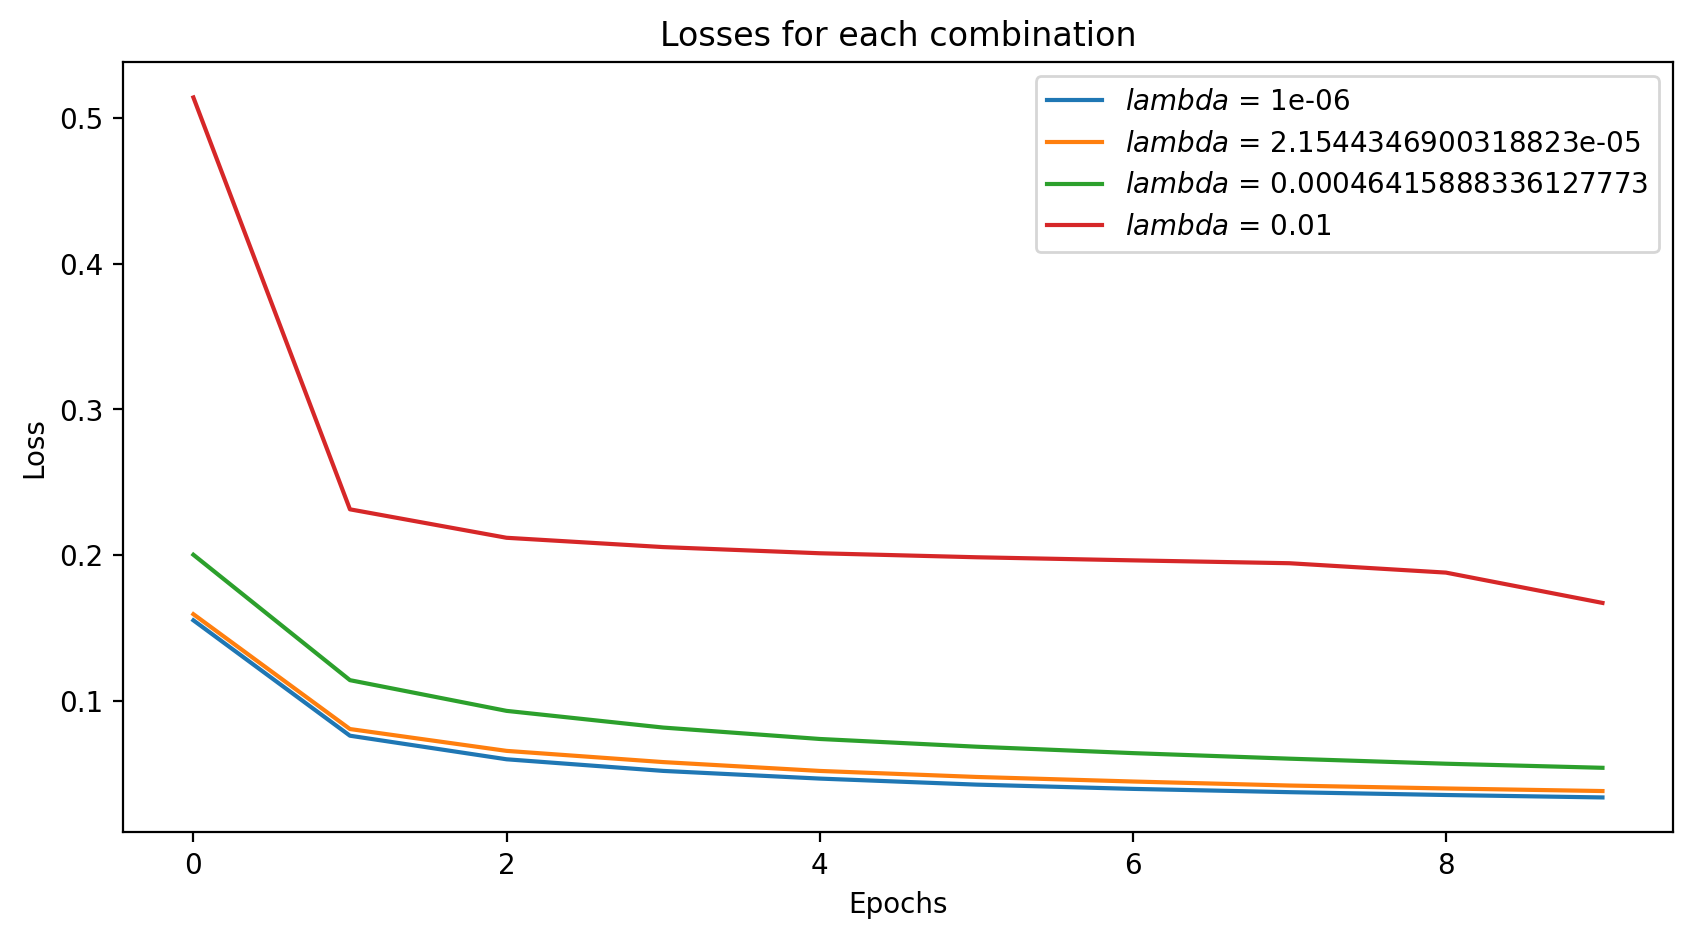

In [ ]:
plt.figure(figsize=(10,5))
for l, array in results_train_lambda.items():
    plt.plot(array, label=f'$lambda$ = {l}')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses for each combination')

# Show plot
plt.show()

Epoch 0. Training loss: 0.173604719478383. Validation loss: 0.10398059893161693
Epoch 1. Training loss: 0.09309071308763867. Validation loss: 0.07960156953715264
Epoch 2. Training loss: 0.07687399415722625. Validation loss: 0.07061085872193601
Epoch 3. Training loss: 0.0682970299332572. Validation loss: 0.0643093116105871
Epoch 4. Training loss: 0.06237951032182371. Validation loss: 0.06062904406101146
Epoch 5. Training loss: 0.05804532126057893. Validation loss: 0.05617041378579241
Epoch 6. Training loss: 0.05414758463898166. Validation loss: 0.055021860862665986
Epoch 7. Training loss: 0.05081742417744615. Validation loss: 0.04962744494067862
Epoch 8. Training loss: 0.04793025439456952. Validation loss: 0.04899132210523524
Epoch 9. Training loss: 0.04603800546399064. Validation loss: 0.045685504043989994
Epoch 10. Training loss: 0.04434403157475489. Validation loss: 0.04578031948272218
Epoch 11. Training loss: 0.04280361543219029. Validation loss: 0.04216798453571949
Epoch 12. Traini

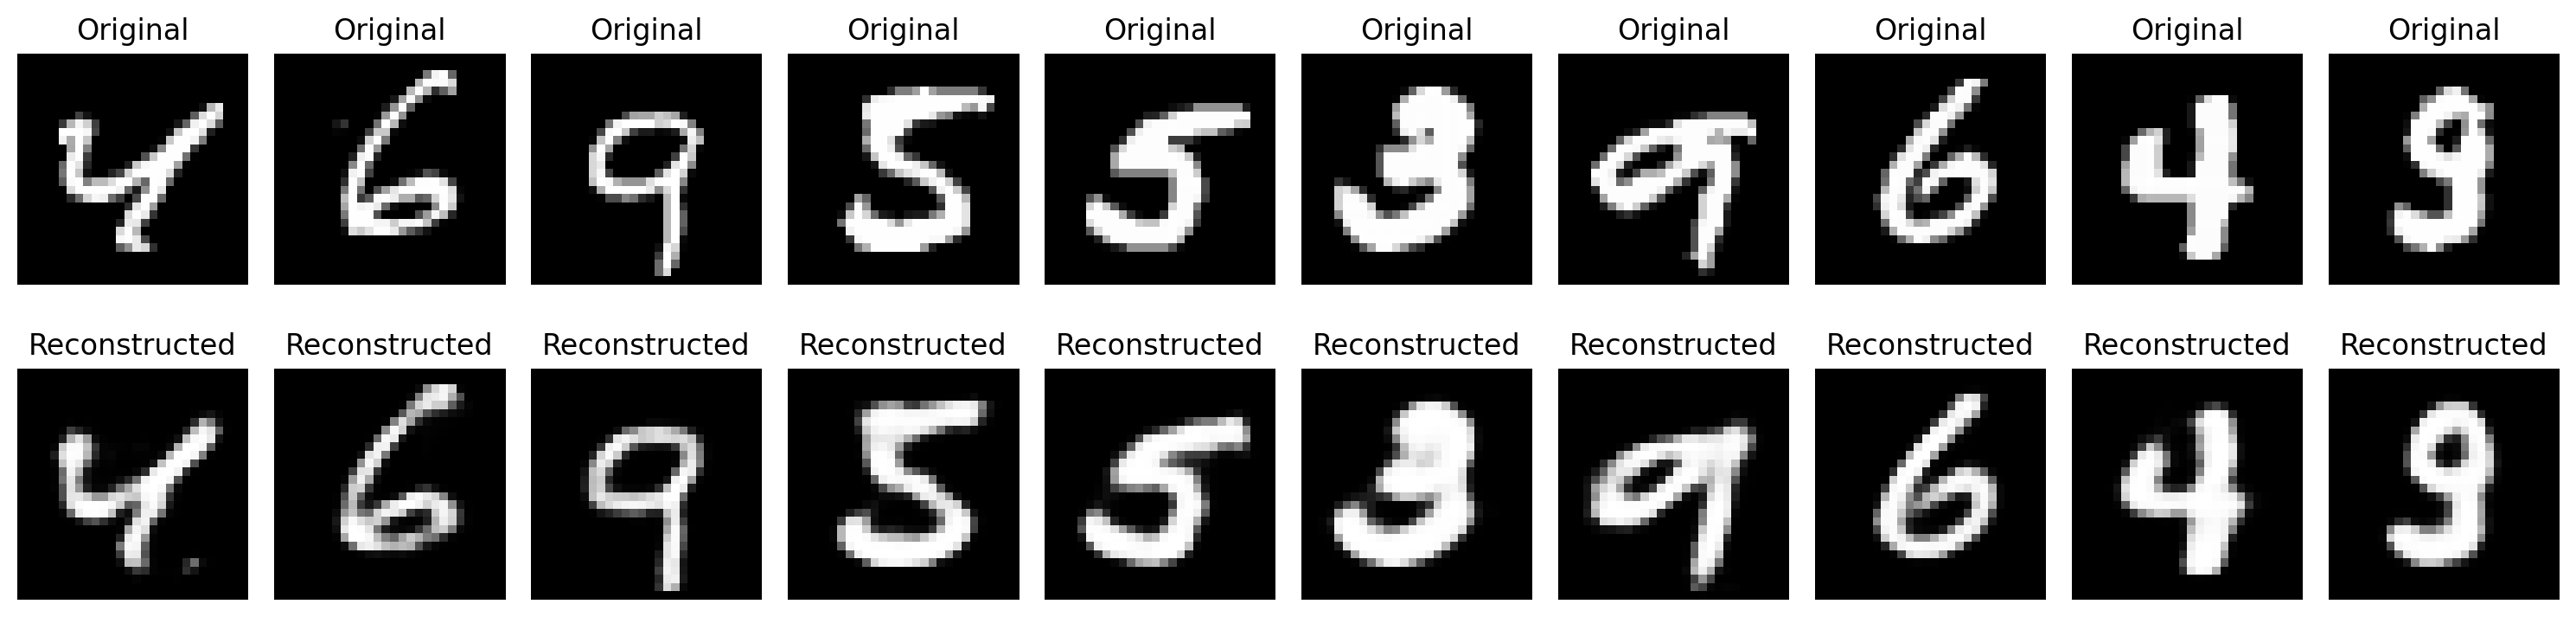

In [ ]:
autoencoder_regularized1 = Autoencoder_extended_regularized(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=50, lr=1e-3, dropout_prob=0, l1_lambda=1e-4)
autoencoder_regularized1.trainloop(trainloader, validloader)
autoencoder_regularized1.plot_reconstructions(testloader)


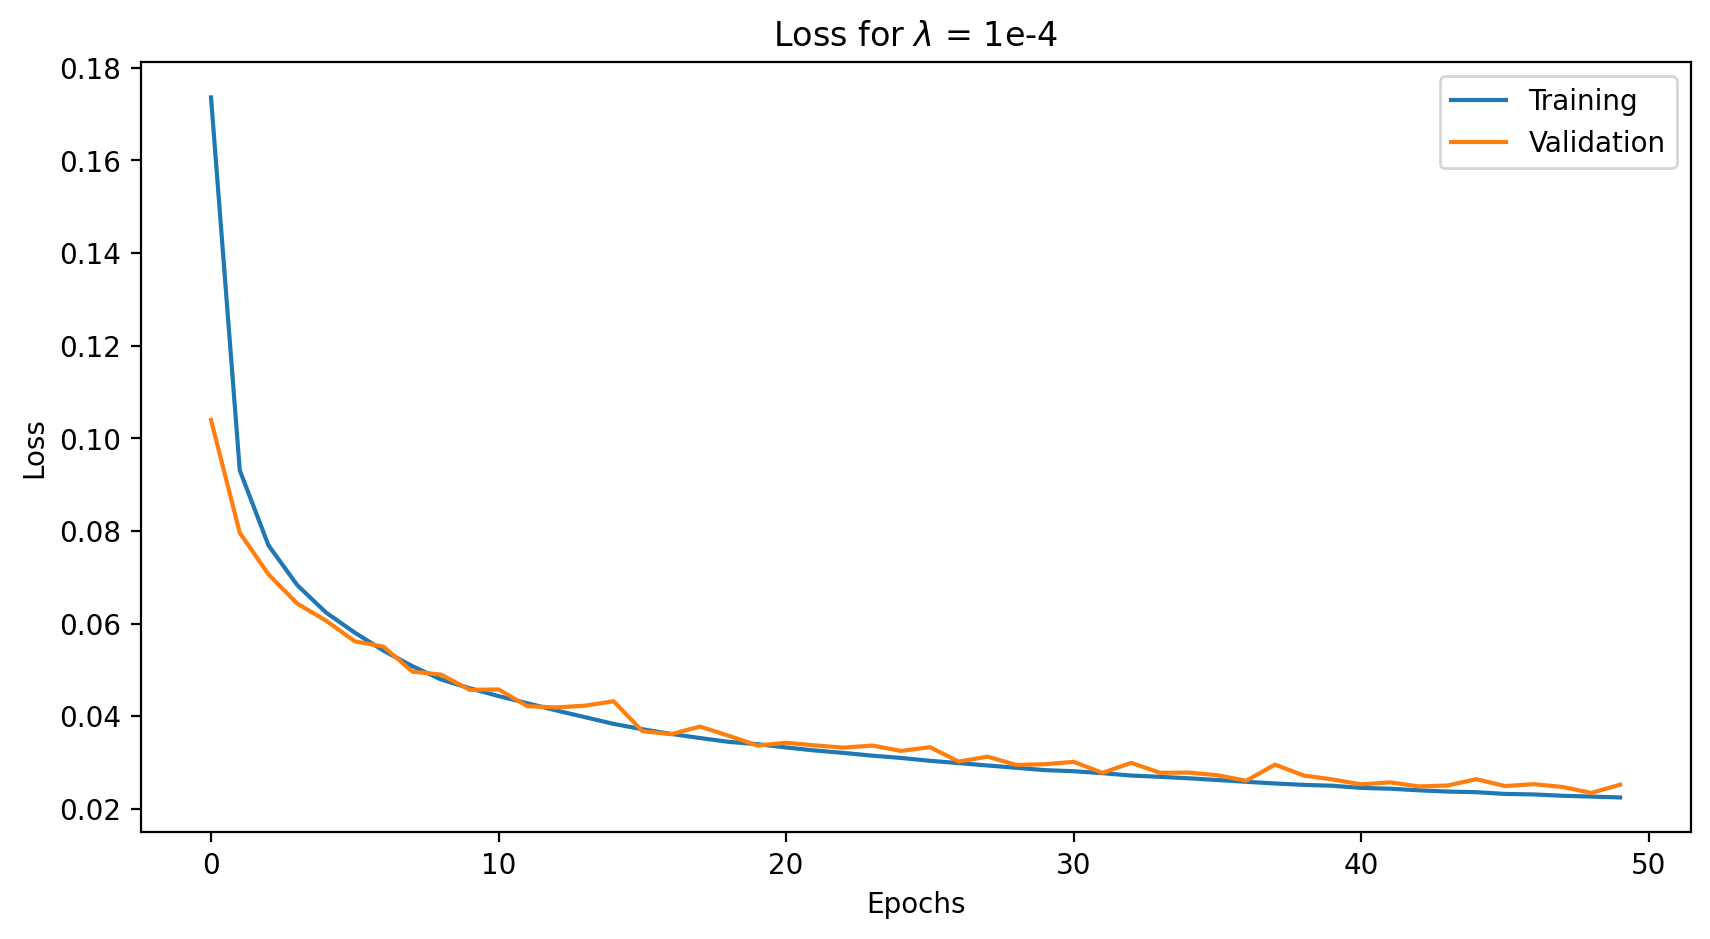

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(autoencoder_regularized1.loss_during_training, label=f'Training')
plt.plot(autoencoder_regularized1.valid_loss_during_training, label=f'Validation')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(r'Loss for $\lambda$ = 1e-4')

# Show plot
plt.show()

### Dropout regularization



In [ ]:
class Dropout(Autoencoder_extended_regularized):

  def __init__(self, dimx, hidden, projected, layers, epochs=30, lr=0.01, dropout_prob=0, l1_lambda=0):  # Add dropout rate argument

      super().__init__(dimx, hidden, projected, layers, epochs, lr, dropout_prob, l1_lambda)

      encoder_layers = []
      i = 0
      encoder_layers.append(nn.Linear(dimx, hidden[i]))
      encoder_layers.append(nn.ReLU())
      encoder_layers.append(nn.Dropout(dropout_prob))
      for i in range(1, layers-1):
          encoder_layers.append(nn.Linear(hidden[i-1], hidden[i]))
          encoder_layers.append(nn.ReLU())
          encoder_layers.append(nn.Dropout(dropout_prob))
      encoder_layers.append(nn.Linear(hidden[-1], projected))
      encoder_layers.append(nn.ReLU())
      self.encoder = nn.Sequential(*encoder_layers)

      decoder_layers = []
      i = 0
      decoder_layers.append(nn.Linear(projected, hidden[-(i+1)]))
      decoder_layers.append(nn.ReLU())
      decoder_layers.append(nn.Dropout(dropout_prob))
      for i in range(1, layers-1):
          decoder_layers.append(nn.Linear(hidden[-i], hidden[-(i+1)]))
          decoder_layers.append(nn.ReLU())
          decoder_layers.append(nn.Dropout(dropout_prob))
      decoder_layers.append(nn.Linear(hidden[-(layers-1)], dimx))
      decoder_layers.append(nn.Tanh())
      self.decoder = nn.Sequential(*decoder_layers)


Epoch 0. Training loss: 0.9258920075371861. Validation loss: 0.9252632105604132
Epoch 1. Training loss: 0.925899283029139. Validation loss: 0.9252436663242096
Epoch 2. Training loss: 0.9258875632658601. Validation loss: 0.925224774949094
Epoch 3. Training loss: 0.9258798513222825. Validation loss: 0.925222520118064
Epoch 4. Training loss: 0.9259169307452711. Validation loss: 0.9252431618406417
Epoch 5. Training loss: 0.9259141616692598. Validation loss: 0.9252305020677283
Epoch 6. Training loss: 0.9258985568515279. Validation loss: 0.9251972203559063
Epoch 7. Training loss: 0.9258953559805047. Validation loss: 0.9252413562003602
Epoch 8. Training loss: 0.9258901070464741. Validation loss: 0.9252590526925757
Epoch 9. Training loss: 0.9258802477270365. Validation loss: 0.9252321928105456


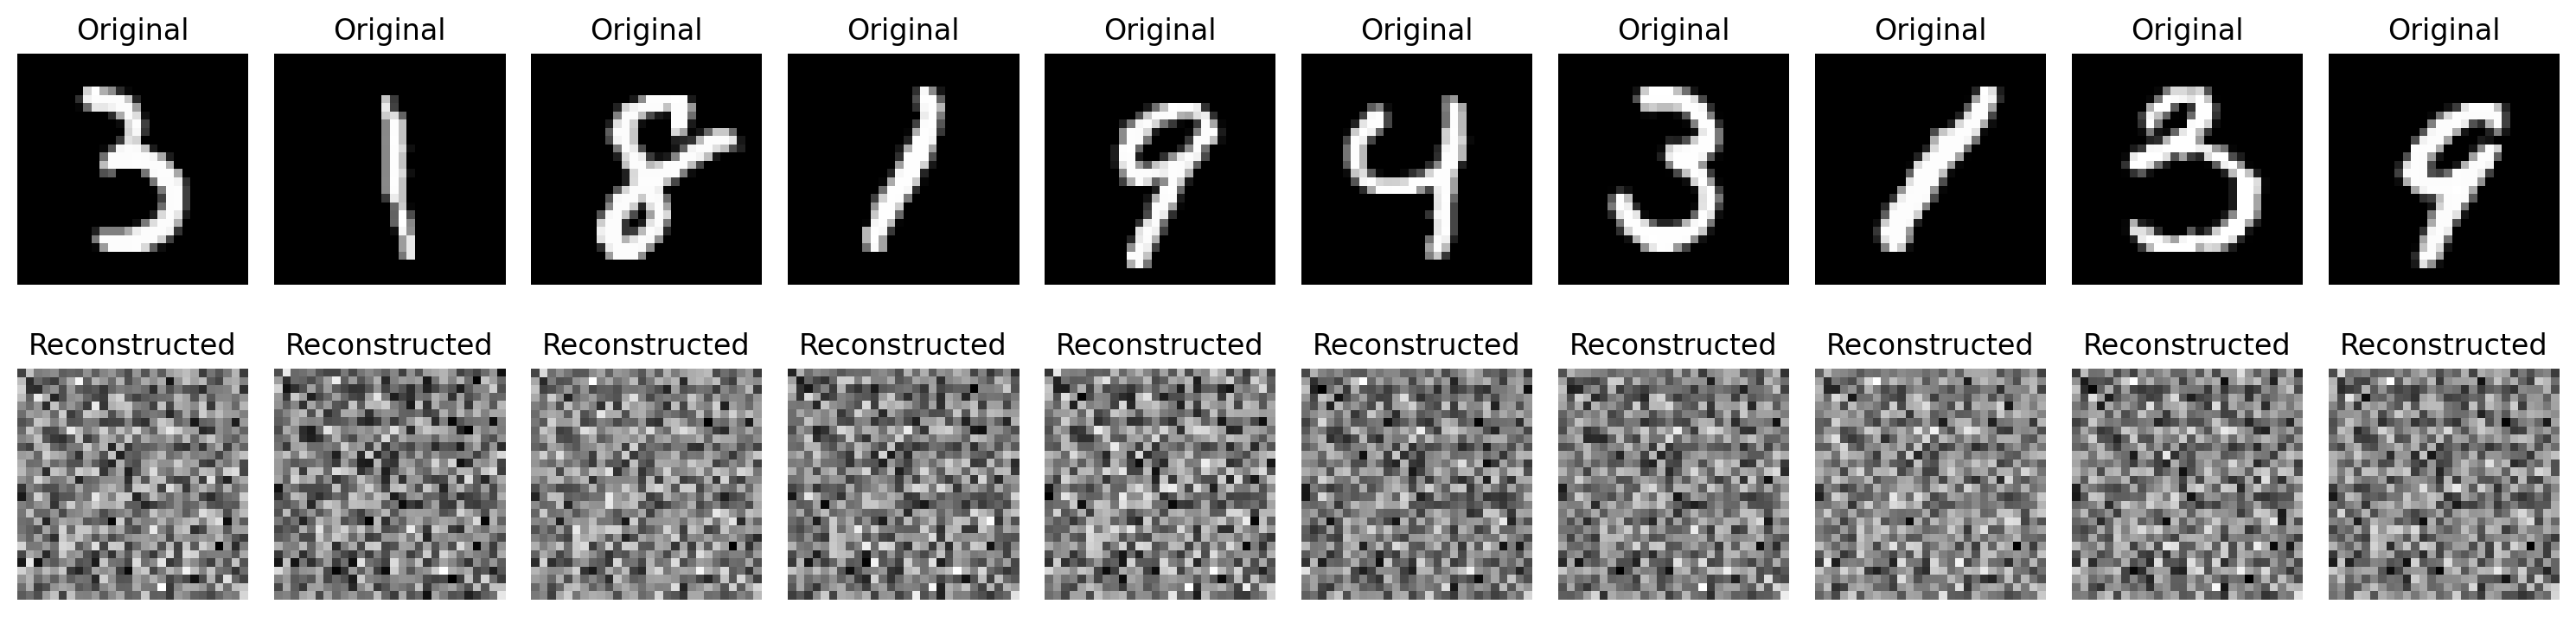

In [ ]:
autoencoder_regularized_dropout = Dropout(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=10, lr=1e-3, dropout_prob=0.2)
autoencoder_regularized_dropout.trainloop(trainloader, validloader)
autoencoder_regularized_dropout.plot_reconstructions(testloader)


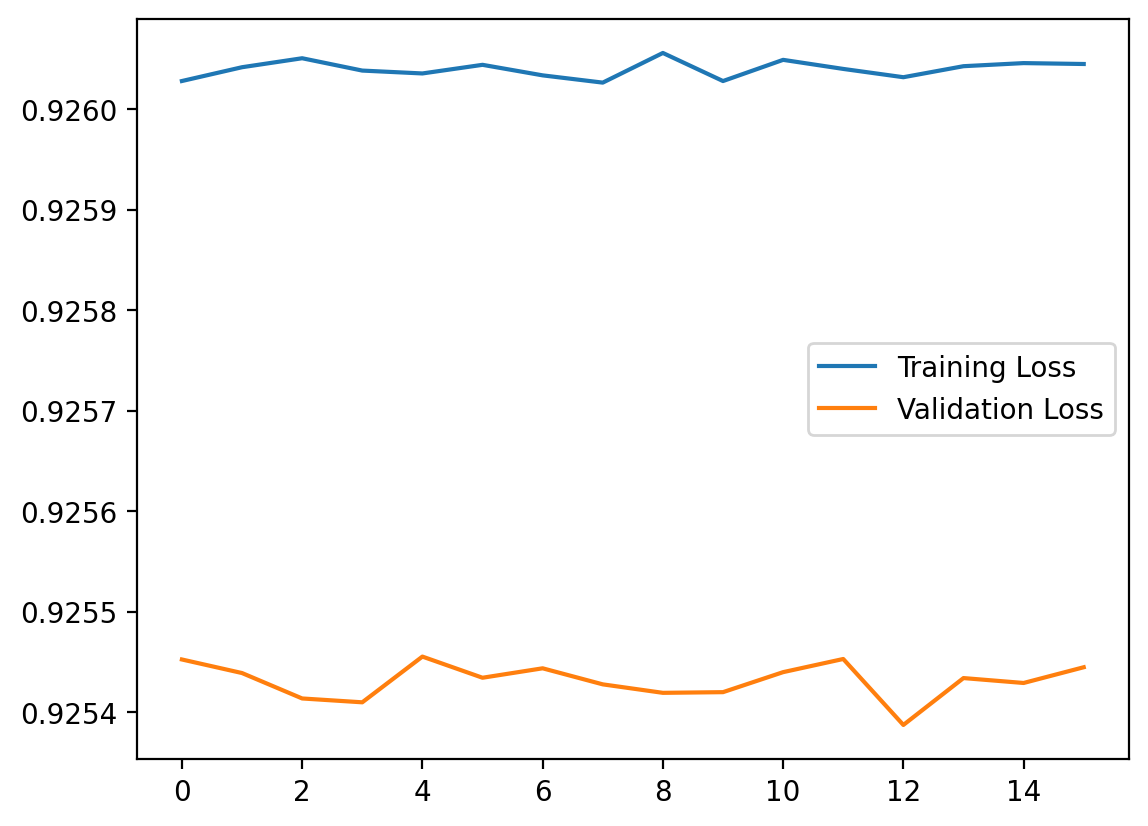

In [ ]:
plt.plot(autoencoder_regularized_dropout.loss_during_training,label='Training Loss')
plt.plot(autoencoder_regularized_dropout.valid_loss_during_training,label='Validation Loss')
plt.legend()

## 4. Denoising autoencoder

In [ ]:
class Denoiser(Autoencoder_extended_regularized):

    def __init__(self, dimx, hidden, projected, layers, epochs=30, lr=0.01, dropout_prob=0, l1_lambda=0):
        super().__init__(dimx, hidden, projected, layers, epochs, lr, dropout_prob, l1_lambda)

        self.performance_during_training = []
        self.performance_during_validation = []

    def add_noise(self, image, noise_level=0.6):
      """
        Adds Gaussian noise to an image tensor.

        Args:
            image (torch.Tensor): Input image tensor.
            noise_level (float, optional): Standard deviation of the noise (default 0.6).

        Returns:
            torch.Tensor: Noisy image tensor with the same dimensions as the input.
        """
      noise = torch.randn_like(image) * noise_level
      return image + noise

    def psnr(self, original, reconstructed, mse):
      """
        Calculates the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

        Args:
            original (torch.Tensor): Original image tensor.
            reconstructed (torch.Tensor): Reconstructed image tensor.
            mse (torch.Tensor): Mean Squared Error loss between original and reconstructed images.

        Returns:
            float: PSNR value in dB.
        """
      max_val = 2.0
      psnr = 10 * torch.log10(max_val**2 / mse)
      return psnr.detach().numpy()


    def trainloop(self, trainloader, validloader):
        for e in range(self.epochs):
            running_loss = 0.
            running_performance = 0.

            for (inputs, _) in trainloader:
                inputs = inputs.reshape(inputs.shape[0], -1)
                noisy_inputs = self.add_noise(inputs)
                out = self.forward(noisy_inputs)
                mse = self.criterion(out, inputs)

                l1_reg = 0
                for param in self.encoder[-2].parameters():
                    l1_reg += torch.norm(param, p=1)

                loss = mse + self.l1_lambda * l1_reg

                running_loss += loss.item()

                # Store the model performance
                running_performance += self.psnr(out, inputs, mse)

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))
            self.performance_during_training.append(running_performance / len(trainloader))

            with torch.no_grad():
                running_loss = 0.
                running_performance = 0.
                for (inputs, _) in validloader:
                    inputs = inputs.view(inputs.shape[0], -1)
                    noisy_inputs = self.add_noise(inputs)
                    out = self.forward(noisy_inputs)
                    loss = self.criterion(out, inputs)
                    running_loss += loss.item()
                    running_performance += self.psnr(out, inputs, mse)
                self.valid_loss_during_training.append(running_loss / len(validloader))
                self.performance_during_validation.append(running_performance / len(validloader))

            if (e % 1 == 0):
                print('----------------------')
                print(f'Epoch {e}.\n--- MSE --- \nTraining loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}')
                print(f'--- PSNR --- \nTraining performance: {self.performance_during_training[-1]}. Validation performance: {self.performance_during_validation[-1]}')

    def plot_reconstructions(self, dataloader, num_images=10):

        inputs_list = []
        noisy_list = []
        out_list = []
        num_samples_collected = 0
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.reshape(inputs.shape[0], -1)
                noisy_inputs = self.add_noise(inputs)
                out = self.forward(noisy_inputs)
                inputs_list.append(inputs.cpu().numpy())
                noisy_list.append(noisy_inputs.cpu().numpy())
                out_list.append(out.cpu().numpy())
                num_samples_collected += len(inputs)

                if num_samples_collected >= num_images:
                    break
        inputs = np.concatenate(inputs_list)[:num_images]
        noisy = np.concatenate(noisy_list)[:num_images]
        out = np.concatenate(out_list)[:num_images]

        plt.figure(figsize=(1.5*num_images, 6))
        plt.gray()

        for k in range(num_images):
            plt.subplot(3, num_images, k + 1)
            plt.imshow(inputs[k].reshape(28, 28))
            plt.title('Original')
            plt.axis('off')

            # Plot the noisy inputs
            plt.subplot(3, num_images, num_images + k + 1)
            plt.imshow(noisy[k].reshape(28, 28))
            plt.title('Noisy Original')
            plt.axis('off')

            plt.subplot(3, num_images, 2*num_images + k + 1)
            plt.imshow(out[k].reshape(28, 28))
            plt.title('Reconstructed')
            plt.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

----------------------
Epoch 0.
--- MSE --- 
Training loss: 0.17867021334611558. Validation loss: 0.11513487915409372
--- PSNR --- 
Training performance: 14.040096547793258. Validation performance: 15.161961555480957
----------------------
Epoch 1.
--- MSE --- 
Training loss: 0.10594077008268372. Validation loss: 0.09565233334581903
--- PSNR --- 
Training performance: 15.979546798901124. Validation performance: 16.162418365478516
----------------------
Epoch 2.
--- MSE --- 
Training loss: 0.09060424257239158. Validation loss: 0.08444297215405931
--- PSNR --- 
Training performance: 16.65668865225532. Validation performance: 17.729623794555664
----------------------
Epoch 3.
--- MSE --- 
Training loss: 0.08119084010832012. Validation loss: 0.07541877953930104
--- PSNR --- 
Training performance: 17.130172710527074. Validation performance: 18.22806167602539
----------------------
Epoch 4.
--- MSE --- 
Training loss: 0.07504298046379435. Validation loss: 0.07214004223016983
--- PSNR --- 
Tr

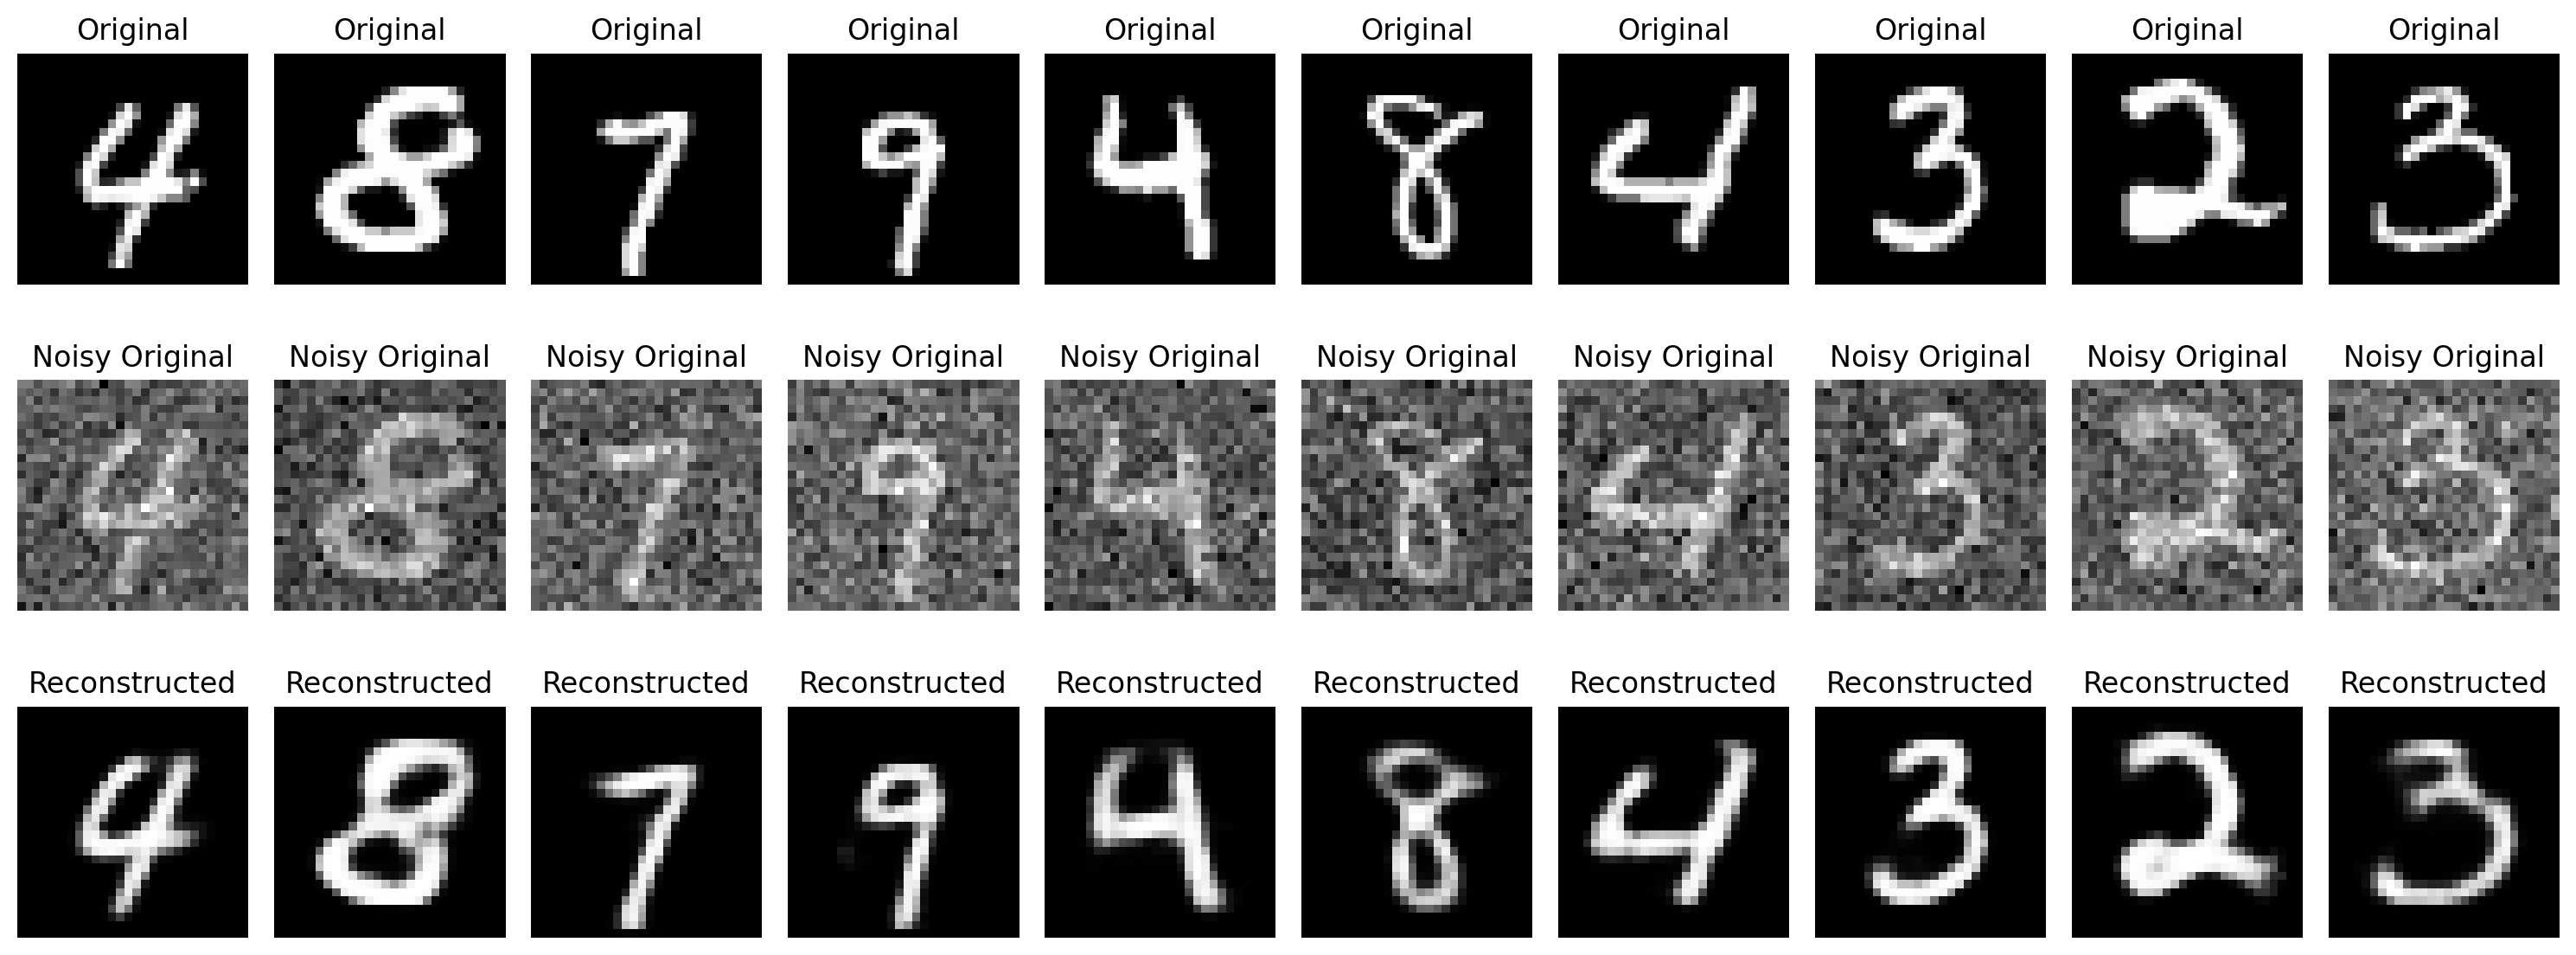

In [ ]:
denoiser =  Denoiser(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=50, lr=1e-3, dropout_prob=0, l1_lambda=1e-4)
denoiser.trainloop(trainloader, validloader)
denoiser.plot_reconstructions(testloader)

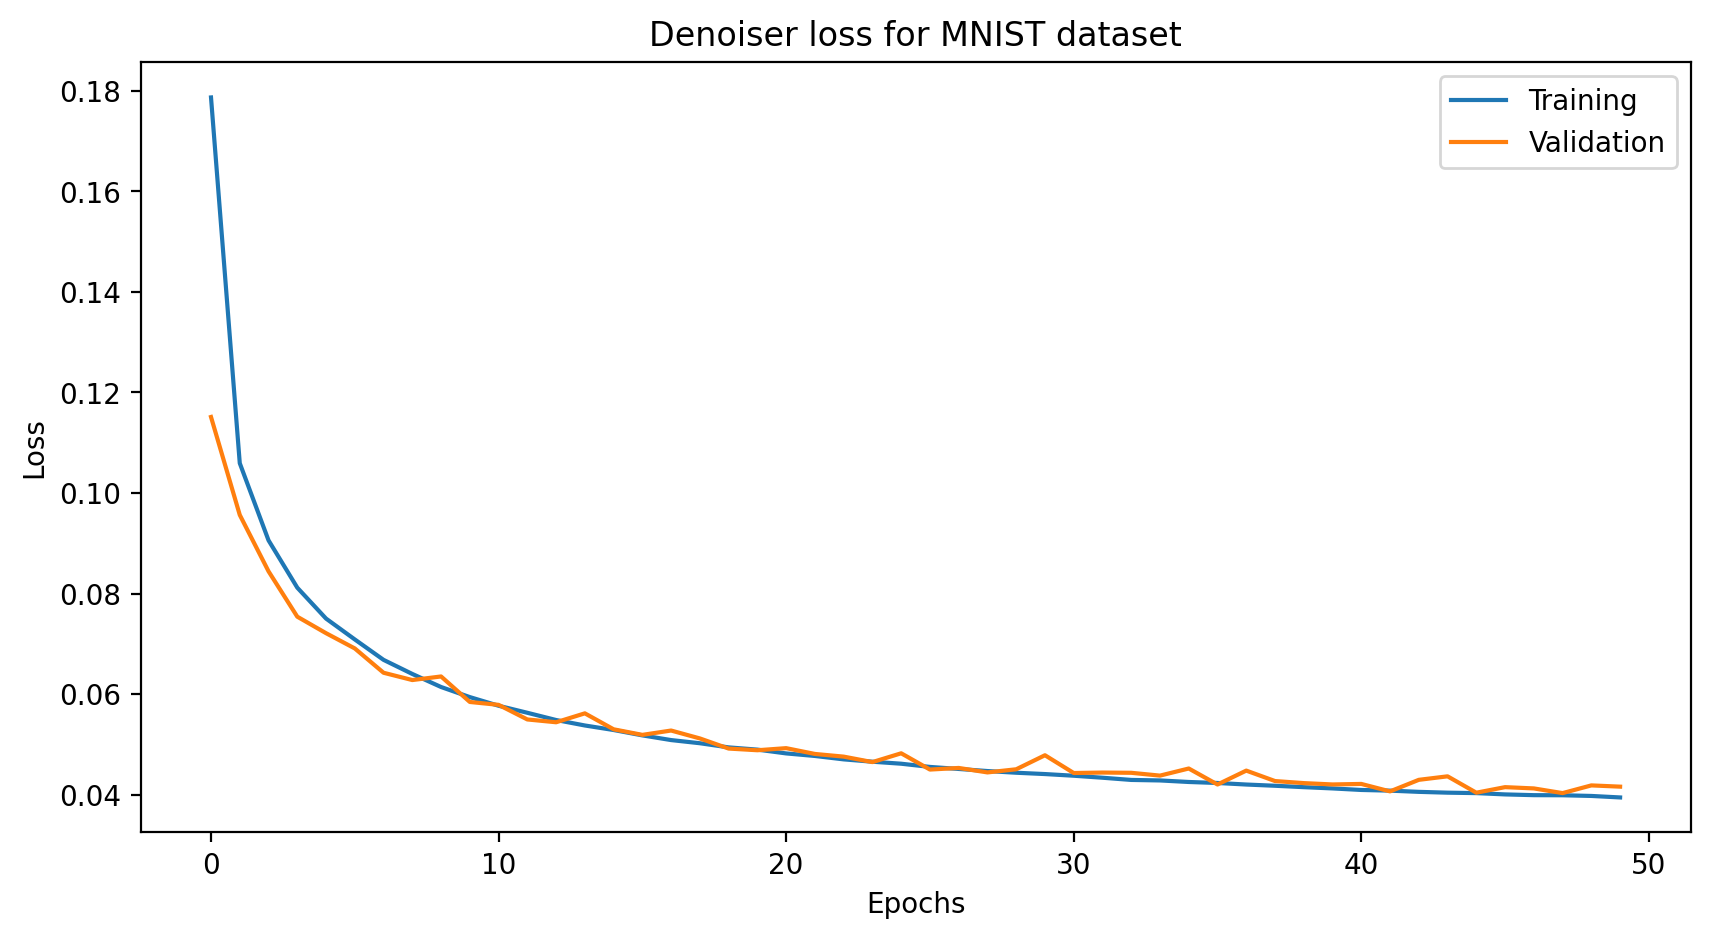

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(denoiser.loss_during_training, label='Training')
plt.plot(denoiser.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Denoiser loss for MNIST dataset')

plt.show()

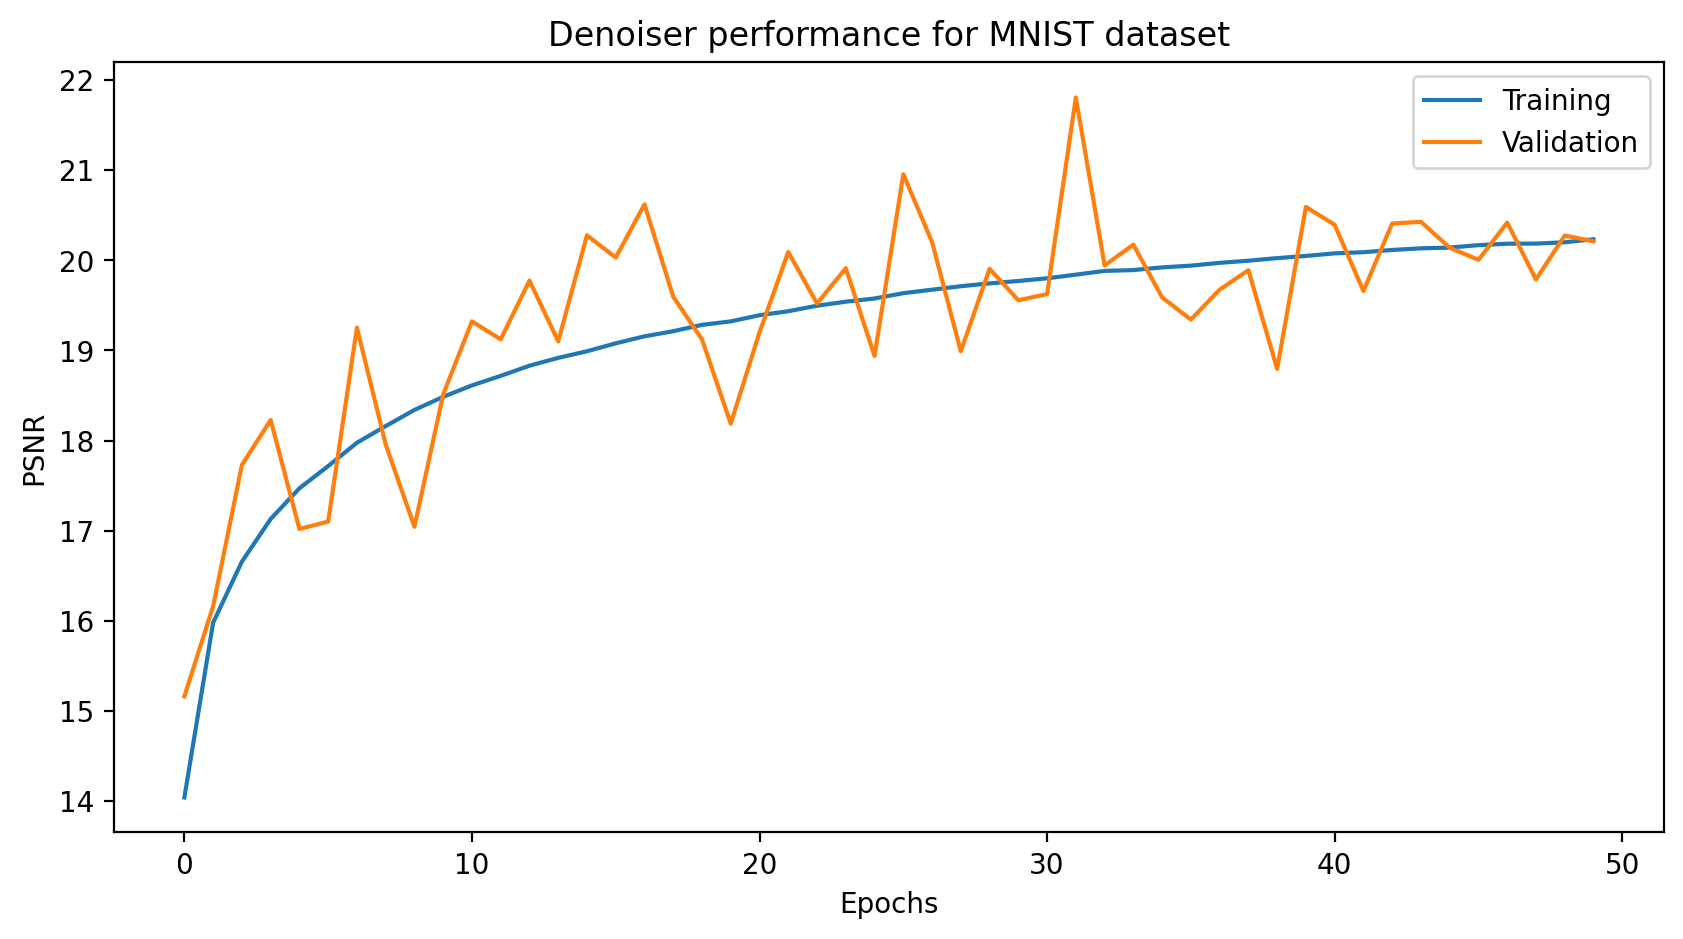

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(denoiser.performance_during_training, label='Training')
plt.plot(denoiser.performance_during_validation, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Denoiser performance for MNIST dataset')

plt.show()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

----------------------
Epoch 0.
--- MSE --- 
Training loss: 0.12898564755662598. Validation loss: 0.08317723800527288
--- PSNR --- 
Training performance: 15.646248199045658. Validation performance: 17.647462844848633
----------------------
Epoch 1.
--- MSE --- 
Training loss: 0.08242330486378209. Validation loss: 0.07839520507036371
--- PSNR --- 
Training performance: 17.076773299412295. Validation performance: 17.015033721923828
----------------------
Epoch 2.
--- MSE --- 
Training loss: 0.07515035137872804. Validation loss: 0.0712743397881376
--- PSNR --- 
Training performance: 17.4416515854272. Validation performance: 17.013399124145508
----------------------
Epoch 3.
--- MSE --- 
Training loss: 0.0705289301536554. Validation loss: 0.06741644579996454
--- PSNR --- 
Training performance: 17.704078923572194. Validation performance: 19.69739532470703
----------------------
Epoch 4.
--- MSE --- 
Training loss: 0.06696497180118141. Validation loss: 0.06510320589580434
--- PSNR --- 
Train

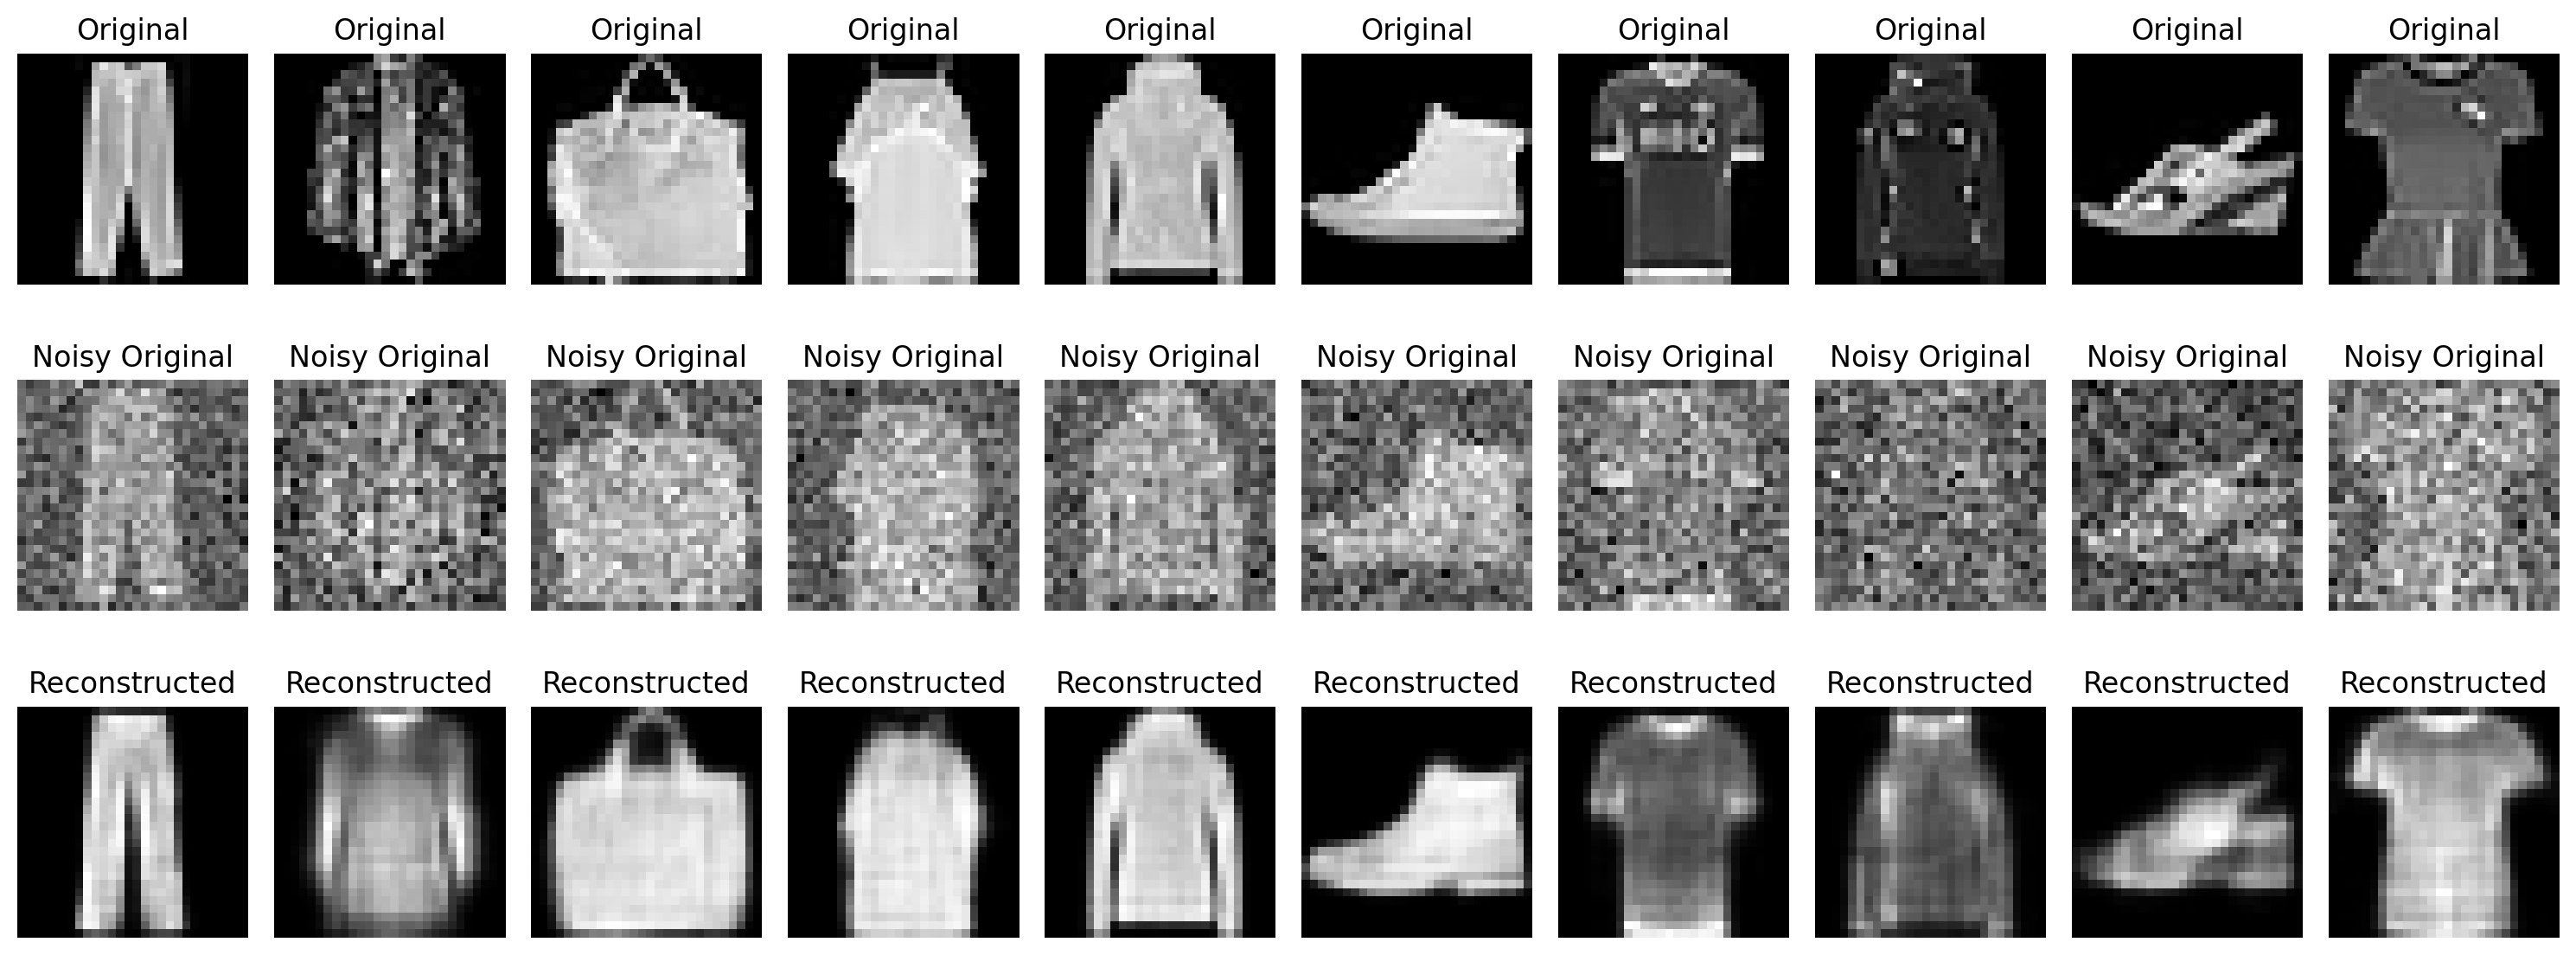

In [ ]:
denoiser =  Denoiser(dimx=784, hidden=[256, 128], projected=100, layers=3, epochs=50, lr=1e-3, dropout_prob=0, l1_lambda=1e-4)
denoiser.trainloop(trainloader, validloader)
denoiser.plot_reconstructions(testloader)

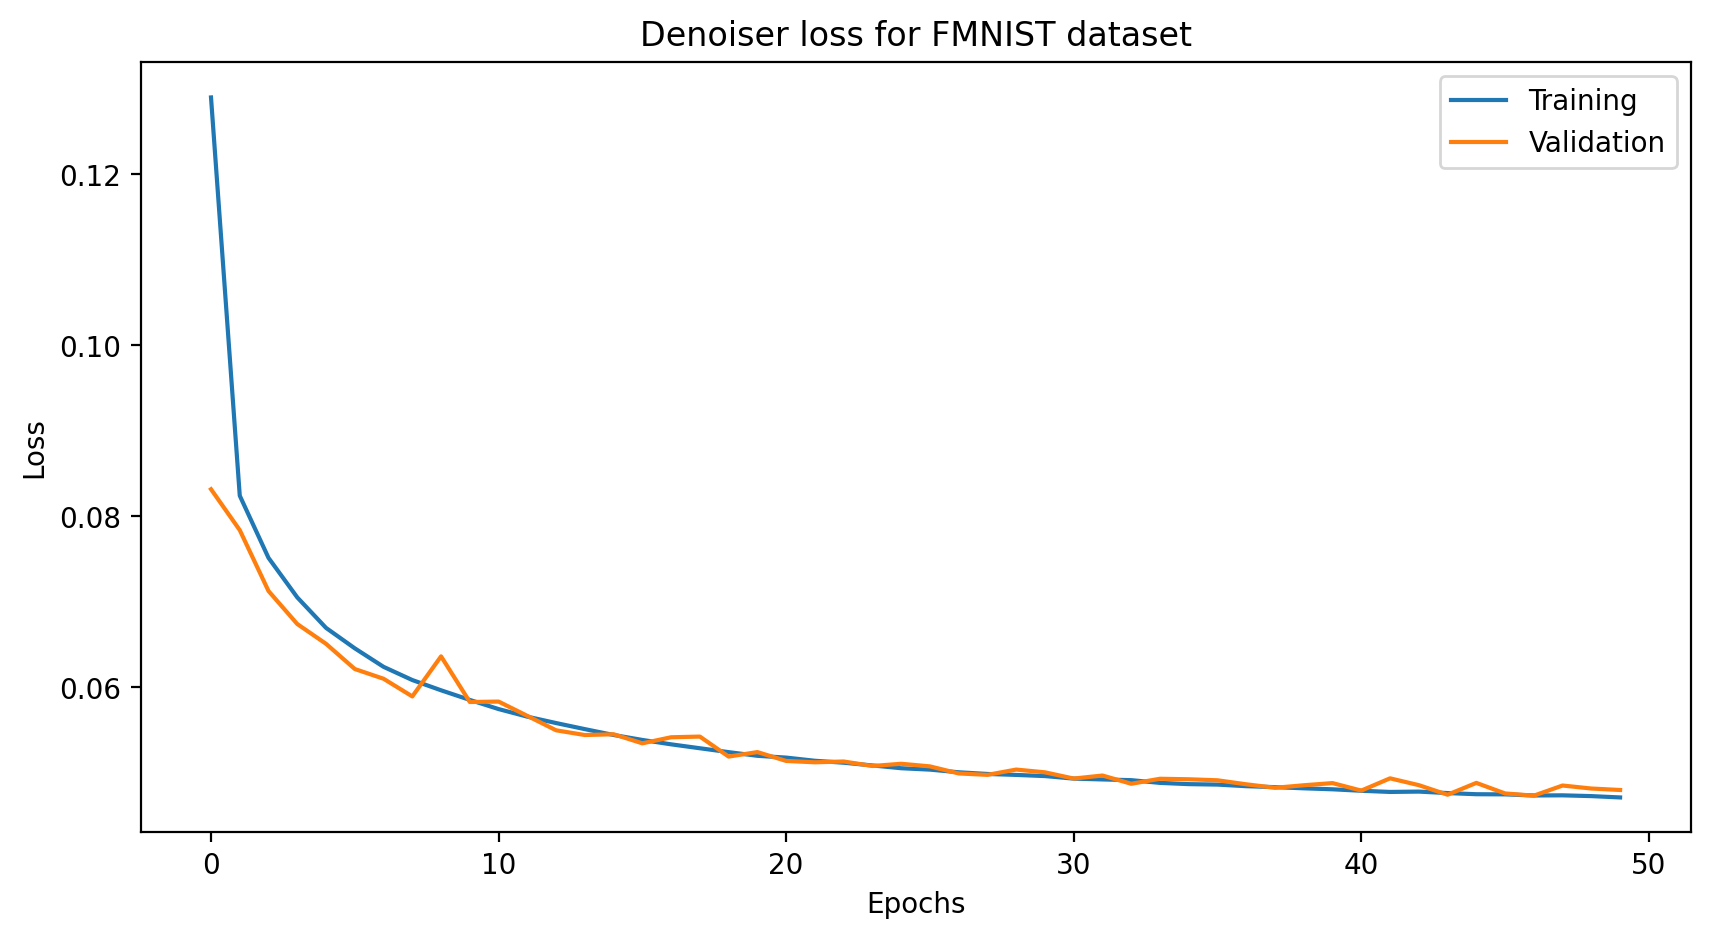

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(denoiser.loss_during_training, label='Training')
plt.plot(denoiser.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Denoiser loss for FMNIST dataset')

plt.show()

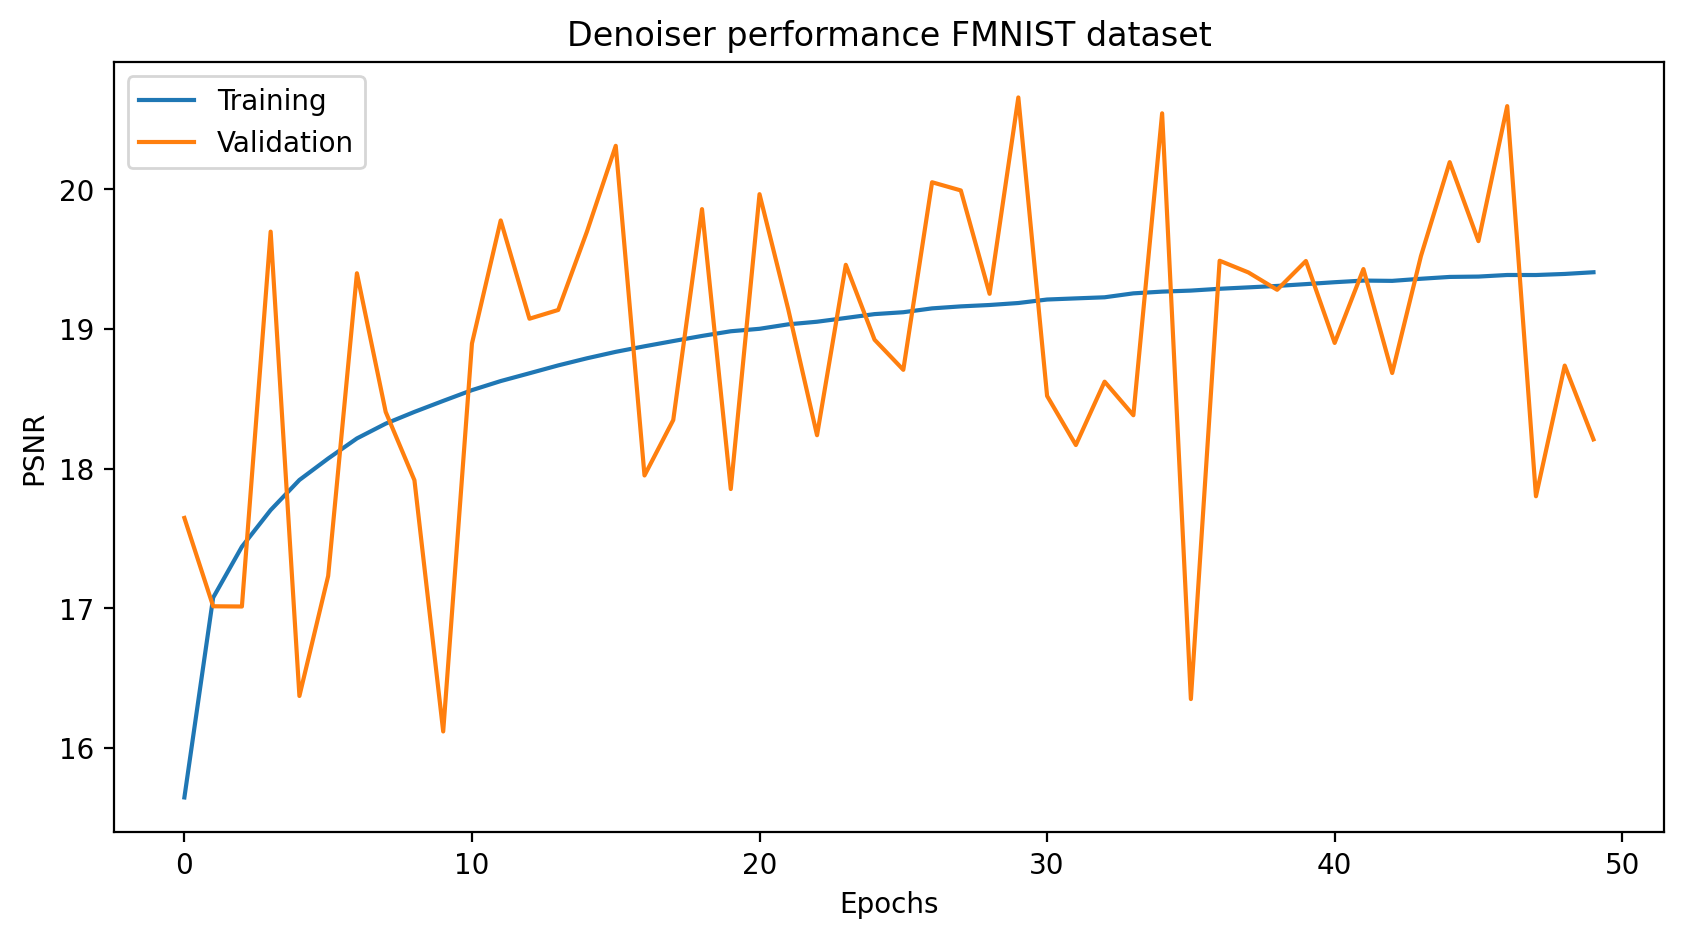

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(denoiser.performance_during_training, label='Training')
plt.plot(denoiser.performance_during_validation, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Denoiser performance FMNIST dataset')

plt.show()